# Gene-regulatory inference

This notebook contains the pipeline for checking the applicability of regulatory network inference methods based on scRNA-seq. The methods are extracted from [here](https://academic.oup.com/bib/article/22/3/bbaa190/5904505), [here](https://saezlab.org/project/modeling-signaling-networks-from-single-cell-data/) and [here](https://www.nature.com/articles/s41592-019-0690-6).

### The overview of GRN-inferring methods

In [5]:
_NET_FNAMES = glob(os.path.join(_PROJ_PATH, 'data/ndex/*/*.cx'))
_NET_NAMES = [net_fn[net_fn.find('ndex/')+5:-3] for net_fn in _NET_FNAMES]
_REMOVE_SINGLE_NODES = True

published_nets = {
    net_n: process_ndex_net(ndex2.create_nice_cx_from_file(net_fn).to_networkx(mode='default'), net_n, _REMOVE_SINGLE_NODES) for net_fn, net_n in zip(_NET_FNAMES, _NET_NAMES)
}

In [6]:
def draw_published_net(data):
    seed = 42
    G = published_nets[data]
    pos = nx.nx_agraph.pygraphviz_layout(G, prog="dot")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
    
    f, ax = plt.subplots(figsize=(40, 20))      
    nodes = nx.draw(G, pos, with_labels=True, arrowstyle="->", arrowsize=30, edge_color='k', 
                    node_color='pink', ax=ax, node_size=_NODE_SIZE)
    nx.draw_networkx_nodes(G.subgraph(TF_names), ax=ax, pos=pos, node_color='limegreen', 
                           node_size=_NODE_SIZE)
            
    ax.set_title(f'"{data}" network from NDEx', fontsize=20)
    plt.axis('off')    
    
widget = interact(draw_published_net, data=_NET_NAMES)

interactive(children=(Dropdown(description='data', options=('NK_cell/NK Signaling', 'B_cell/WP23 - B cell rece…

## <span style="color:salmon">GRNBoost2 + pySCENIC</span>

Here we just depict how to run this algorithms on a handful of genes in the notebook. Normally one would use the following way:

To run in CLI:

```
cd
python src/run_grnboost2.py -i <path_to_input> -o <path_to_output>
```

In [7]:
%%time

if False:
    print(f'Running GRNBoost2 with {expression_data.shape[1]} genes..')
    
    expression_data = HVG_ex_df

    # compute the GRN using grnboost2
    grnboost2_net = grnboost2(expression_data=expression_data, gene_names=None, tf_names=TF_names)

    grnboost2_net.head(3)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.9 µs


Instead of running everything here, we will run `grnboost2` in CLI and load results here.

In [8]:
%%time

grnboost2_meta = {}
p_bar = tqdm(_PATIENTS)

for pat in p_bar:
    p_bar.set_description(f'{pat} patient')
    grnboost2_meta[pat] = {}
    for fn in _FILE_PREFIXES[pat]:
        try:
            input_TF = pd.read_pickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{fn}_TF_cor.pickle'))
            input_ctx = pd.read_pickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{fn}_TF_ctx.pickle'))
        except (FileNotFoundError, pd.errors.EmptyDataError):
            input_TF = None
            ctx = None
            input_ctx = None
        try:
            input_all = pd.read_pickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{fn}_cor.pickle'))
        except (FileNotFoundError, pd.errors.EmptyDataError):
            input_all = None
        grnboost2_meta[pat][fn] = {
        'input_TF': input_TF,
        'input_all': input_all, 
        'filtered_TF': None,
        'filtered_all': None,
        'graph_TF': None,
        'graph_all': None,
        'full_graph_TF': None,
        'full_graph_all': None,
        'input_ctx': input_ctx,
        'filtered_ctx': None,
        'graph': None,
        'full_graph_ctx': None
        }    

print('The first 2 rows of GRNBoost2 output as an example (based on all genes and all cells)..')
display(grnboost2_meta[_PATIENTS[0]]['raw_data']['input_all'].head(2))
print('After processing of ctx output..')
display(grnboost2_meta[_PATIENTS[0]]['raw_data']['input_ctx'].head(2))

# Getting graph/adj_list availability matrices
_AVAIL_ADJ_LISTs = get_avail_adj_list_mat()
_AVAIL_Gs = get_avail_graph_mat()
    
for d_type in ['all', 'TF', 'ctx']:
    print(colored(d_type.upper(), 'cyan'))
    display(style_data_availability(_AVAIL_Gs[d_type].applymap(lambda x: np.nan if pd.isna(x) else '+' if x else '-')))

  0%|          | 0/6 [00:00<?, ?it/s]

The first 2 rows of GRNBoost2 output as an example (based on all genes and all cells)..


,TF,target,importance,regulation,rho
0,AC020656.1,LYZ,304.384463,1,0.695376
1,CDC42SE1,C1orf56,258.065352,1,0.764326


After processing of ctx output..


,TF,target,importance,regulation,rho
0,AR,STARD4,1.134836,1.0,0.039169
1,AR,CA2,5.515849,1.0,0.030785


ALL


,all_data,T_cells,Macrophage,NK_cell,Monocyte,DC,Epithelial_cells,B_cell,Neutrophils,Pre-B_cell_CD34-,CMP,GMP,HSC_-G-CSF,Pro-B_cell_CD34+,BM,Gametocytes,Neurons,Erythroblast,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,-,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
C,+,+,+,+,+,+,+,+,-,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
M,+,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
S,-,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
C141,+,+,+,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
C142,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan
C143,+,+,+,+,+,+,+,+,+,+,+,+,+,+,nan,+,+,nan,nan,nan,nan,nan,nan
C144,+,+,+,+,+,+,+,+,+,+,+,nan,+,+,+,nan,nan,+,nan,nan,nan,nan,nan
C145,+,+,+,+,+,+,+,+,+,+,nan,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan
C146,+,+,+,+,+,+,+,+,+,nan,nan,nan,+,nan,nan,+,nan,nan,+,+,+,+,nan


TF


,all_data,T_cells,Macrophage,NK_cell,Monocyte,DC,Epithelial_cells,B_cell,Neutrophils,Pre-B_cell_CD34-,CMP,GMP,HSC_-G-CSF,Pro-B_cell_CD34+,BM,Gametocytes,Neurons,Erythroblast,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,+,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
C,+,+,+,+,+,+,+,+,-,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
M,+,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
S,+,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
C141,+,+,+,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
C142,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan
C143,+,+,+,+,+,+,+,+,+,+,+,+,+,+,nan,+,+,nan,nan,nan,nan,nan,nan
C144,+,+,+,+,+,+,+,+,+,+,+,nan,+,+,+,nan,nan,+,nan,nan,nan,nan,nan
C145,+,+,+,+,+,+,+,+,+,+,nan,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan
C146,+,+,+,+,+,+,+,+,+,nan,nan,nan,+,nan,nan,+,nan,nan,+,+,+,+,nan


CTX


,all_data,T_cells,Macrophage,NK_cell,Monocyte,DC,Epithelial_cells,B_cell,Neutrophils,Pre-B_cell_CD34-,CMP,GMP,HSC_-G-CSF,Pro-B_cell_CD34+,BM,Gametocytes,Neurons,Erythroblast,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,+,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
C,+,+,+,+,+,+,+,+,-,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
M,+,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
S,+,+,+,+,+,+,+,+,+,+,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
C141,+,+,+,+,+,+,+,+,+,+,+,-,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
C142,+,+,+,+,+,+,+,+,+,+,+,-,-,-,-,nan,nan,nan,nan,nan,nan,nan,nan
C143,+,+,+,+,+,+,+,+,+,+,-,-,+,-,nan,-,-,nan,nan,nan,nan,nan,nan
C144,+,+,+,+,+,+,+,+,+,+,-,nan,-,-,-,nan,nan,-,nan,nan,nan,nan,nan
C145,+,+,+,+,+,+,+,+,+,+,nan,-,+,-,nan,nan,nan,nan,nan,nan,nan,nan,nan
C146,+,+,+,+,+,+,+,+,+,nan,nan,nan,-,nan,nan,-,nan,nan,-,-,-,-,nan


CPU times: user 12.3 s, sys: 2.87 s, total: 15.2 s
Wall time: 22.9 s


#### GENERAL STATISTICS

In [9]:
def cell_freq(pat, save_fig):
    
    color_bars = True
    add_non_cell_type = True
    start_index = 0 if add_non_cell_type else 2
    
    sns.set_style("whitegrid")
    
    f, ax = plt.subplots(figsize=(20, 10))
    cell_types = full_cell_type_freq.loc[pat].dropna().astype('int32')
    if add_non_cell_type:
        cell_types = pd.concat([
            pd.Series([sum(cell_types)], index=['all']),
            cell_types
        ])
    
    if not color_bars:
        cell_types = full_cell_type_freq.loc[pat].dropna().astype('int32')
        plots = cell_types.plot(ax=ax, kind='bar') 
        
        # Iterrating over the bars one-by-one
        for bar in plots.patches:
            plots.annotate(bar.get_height(), (bar.get_x() + bar.get_width() / 2,
                           bar.get_height()), ha='center', va='center',
                           size=15, xytext=(0, 8), textcoords='offset points')
    else:
        tmp_tf = pd.Series(
            ['g' if fn in get_avail_list('ctx', pat) else 'r' for fn in _ALL_FILE_PREFIXES[pat][start_index:]], 
            name='TF_present', 
            index=_ALL_FILE_PREFIXES[pat][start_index:]
        )
        tmp_tf.index = tmp_tf.index.map(lambda x: 'all' if x == 'raw_data' else x.replace('raw_data_', ''))
        tmp_all = pd.Series(
            ['g' if fn in get_avail_list('all', pat) else 'r' for fn in _ALL_FILE_PREFIXES[pat][start_index:]], 
            name='all_present', 
            index=_ALL_FILE_PREFIXES[pat][start_index:]
        )
        tmp_all.index = tmp_tf.index.map(lambda x: 'all' if x == 'raw_data' else x.replace('raw_data_', ''))
        tmp_df = pd.DataFrame(
            [
                (cell_types / 2).rename('TF'),
                (cell_types / 2).rename('all'), 
                tmp_tf,
                tmp_all
            ]
        ).T
    
        plots = tmp_df[['TF', 'all']].plot(ax=ax, kind='bar', stacked=True, legend=None)
        
        # Iterrating over the bars one-by-one
        for bar in plots.patches[:len(plots.patches) // 2]:
            plots.annotate(int(2 * bar.get_height()), (bar.get_x() + bar.get_width() / 2,
                           2 * bar.get_height()), ha='center', va='center',
                           size=15, xytext=(0, 8), textcoords='offset points')
            
        for bar, c in zip(plots.patches, tmp_tf.to_list() + tmp_all.to_list()):
            bar.set_color(c)
    
    backslash = '\n'
    ax.set_title(f"{'Cell' if not add_non_cell_type else 'Data/cell'} type frequency in {pat} patient ({int(full_meta['num_cells'][pat])} cells) "
                 f"{'' if not color_bars else f'{backslash}(TF_ctx - bottom, all - top)'}")
    ax.set_xlabel('Cell type')
    ax.set_ylabel('Frequency')
    
    plt.xticks(rotation=45)
    
    if save_fig:
        plt.savefig(os.path.join(_ALL_FIG_DIRS[pat], f'{pat}_full_cell_type_freq.png'), dpi=200, bbox_inches='tight')
    
widget = interact(cell_freq, pat=_ALL_PATIENTS, save_fig=[False, True])

interactive(children=(Dropdown(description='pat', options=('C51', 'C52', 'C141', 'C142', 'C148', 'C149', 'C100…

In [10]:
def genstats(pat, data_type, data, save_fig):
    
    sns.set_style("whitegrid")
    n_bins = 100
    #dtype_title = _DTYPE_TITLES[_DATA_TYPES.index(data_type)]
    #data_title = _ALL_TITLES[pat][_ALL_FILE_PREFIXES[pat].index(data)]
    
    try:
        df = grnboost2_meta[pat][data][f'input_{data_type}']
    except KeyError:
        df = get_adj_list(data, data_type, pat=pat)
    
    num_links = len(df)
    pos_links, neg_links = (df["rho"] > 0).sum(), (df["rho"] < 0).sum()
    top_tfs = df[['TF', 'target']].groupby('TF').size().nlargest(3)
    top_targets = df[['TF', 'target']].groupby('target').size().nlargest(3)
    import_50, import_75, import_max = df['importance'].median(), df['importance'].quantile(0.75), df['importance'].max()
    top_high_tfs = df.loc[lambda x: x.importance > import_50][['TF', 'target']].groupby('TF').size().nlargest(3)
    top_high_targets = df.loc[lambda x: x.importance > import_50][['TF', 'target']].groupby('target').size().nlargest(3)    
    
    print(f'The chosen dataset is "{data}_{data_type}" which contains {num_links} connections')
    print(f'Positive connections - {pos_links} ({pos_links/num_links*100:.1f} %), '
          f'negative connections - {neg_links} ({neg_links/num_links*100:.1f} %)')
    print(f'The dataset contains {df["TF"].nunique()} TFs out of {len(TF_names) if "TF" in data_type else ex_df.shape[1]} and {df["target"].nunique()} targets')
    print(f'TFs with maximum connections: {top_tfs.index[0]} ({top_tfs[0]}), {top_tfs.index[1]} ({top_tfs[1]}), {top_tfs.index[2]} ({top_tfs[2]}); '
          f'targets with maximum connections: {top_targets.index[0]} ({top_targets[0]}), {top_targets.index[1]} ({top_targets[1]}), {top_targets.index[2]} ({top_targets[2]})')
    print(f'TFs with maximum connections (importance > median): {top_high_tfs.index[0]} ({top_high_tfs[0]}), {top_high_tfs.index[1]} ({top_high_tfs[1]}), {top_high_tfs.index[2]} ({top_high_tfs[2]}); '
          f'targets with maximum connections (importance > median): {top_high_targets.index[0]} ({top_high_targets[0]}), {top_high_targets.index[1]} ({top_high_targets[1]}), {top_high_targets.index[2]} ({top_high_targets[2]})..')
    print()
    display(df.describe().drop(index=['count'], columns=['regulation']).T)
    print()
    
    cmap=plt.cm.plasma
    color_bars = False
    
    # Plotting gene-gene link importance distribution
    f, ax = plt.subplots(1, 2, figsize=(20, 8))

    if color_bars:
        y, x = np.histogram(df['importance'], n_bins, density=False)
        colors = [cmap((x_i - x.min()) / (x.max() - x.min())) for x_i in x]
        ax[0].bar(x[:-1], y, color=colors, width=x[1]-x[0])
        ax[0].set_yscale('log')
    else:
        df['importance'].plot(ax=ax[0], bins=n_bins, kind='hist', logy=True)
    ax[0].set_title(f'GRNBoost2-inferred gene-gene connection importance')
    ax[0].set_xlabel('Gene-gene connection importance')
    
    if color_bars:
        df_rho = df['rho'] if not np.all(np.isfinite(df['rho'])) else df['rho'][np.isfinite(df['rho'])]
        y_rho, x_rho = np.histogram(df_rho, n_bins, density=False)
        colors_rho = [None]*len(x)
        for i, rho in enumerate(x_rho):
            importance_closest = df.iloc[(df['rho']-rho).abs().argsort()[:3]]['importance'].mean()
            id_closest = (np.abs(x - importance_closest)).argmin()
            colors_rho[i] = colors[id_closest]
        ax[1].bar(x_rho[:-1], y_rho, color=colors_rho, width=x_rho[1] - x_rho[0])
        ax[1].set_yscale('log')
    else:
        df['rho'].plot(ax=ax[1], bins=n_bins, density=True, kind='hist', logy=True)
    ax[1].set_title(f'Correlation between linked genes')
    ax[1].set_xlabel('Spearman correlation')
    
    f.suptitle(f'{pat}, {data_type}, {data}', fontsize=20)
    
    if save_fig:
        plt.savefig(os.path.join(_ALL_FIG_DIRS[pat], f'{pat}_{data}_{data_type}_genstats.png'), dpi=200, bbox_inches='tight') 

def annotate_option(pat, data):
    if pat in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == pat] if pat != 'all_data' else full_meta
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(curr_meta[col_key].sum())} cells)'
    else:
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(full_meta.loc[pat, col_key])} cells)' 
        
def pick_pat_dtypes(_):
    data_dropdown.options = [(annotate_option(pat_dropdown.value, data), data) for data in get_avail_list(dtype_dropdown.value, pat_dropdown.value)]
      
dtype_dropdown = Dropdown(description='Data type:', options=_DATA_TYPES)
pat_dropdown = Dropdown(description='Patient:', options=[(f"{p}{' (' + full_meta.loc[p, 'group'] + ')' if p not in ['all_data'] + _PAT_CONS else ''}", p) for p in _AVAIL_Gs['all'].index])
data_dropdown = Dropdown(description='Data:', options=[(annotate_option('all_data', data), data) for data in get_avail_list('all', 'all_data')])
pat_dropdown.observe(pick_pat_dtypes, names='value')
dtype_dropdown.observe(pick_pat_dtypes, names='value')

widget = interact(genstats, pat=pat_dropdown, data_type=dtype_dropdown, data=data_dropdown, save_fig=[False, True])

interactive(children=(Dropdown(description='Patient:', options=(('all_data', 'all_data'), ('C', 'C'), ('M', 'M…

#### FILTERING

In [11]:
%%time

_RELOAD = False
filter_quantile = 0.95
filter_suffix = f"_filtered_{str(filter_quantile).replace('.', '_')}"

if _RELOAD:
    print(colored(f'RELOADING -> CHOSEN QUANTILE THRESHOLD: {filter_quantile}', 'green'))
    for pat in _PATIENTS:
        for data in _FILE_PREFIXES[pat]:
            input_TF = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{data}_TF_cor.tsv')
            input_ctx = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{data}_TF_ctx.tsv')
            input_all = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{data}_cor.tsv')
            !python /gpfs/home/bsc08/bsc08890/src/adj_list_to_filter.py -f {input_TF} -q {filter_quantile} &> /dev/null 
            !python /gpfs/home/bsc08/bsc08890/src/adj_list_to_filter.py -f {input_ctx} -q {filter_quantile} &> /dev/null 
            !python /gpfs/home/bsc08/bsc08890/src/adj_list_to_filter.py -f {input_all} -q {filter_quantile} &> /dev/null 
else:
    for pat in _PATIENTS:
        print(colored(f'PATIENT: {pat}', 'cyan'))
        for data in _FILE_PREFIXES[pat]:
            try:
                grnboost2_meta[pat][data]['filtered_TF'] = pd.read_pickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{data}_TF_cor{filter_suffix}.pickle'))
                grnboost2_meta[pat][data]['filtered_ctx'] = pd.read_pickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{data}_TF_ctx{filter_suffix}.pickle'))
                grnboost2_meta[pat][data]['filtered_all'] = pd.read_pickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{data}_cor{filter_suffix}.pickle'))
                print(colored(data.upper(), 'magenta'))
                print(f"Filtering - {colored('TF', 'red')}: {len(grnboost2_meta[pat][data]['input_TF'])} links -> {len(grnboost2_meta[pat][data]['filtered_TF'])} links; "
                      f"{colored('ALL', 'red')}: {len(grnboost2_meta[pat][data]['input_all'])} links -> {len(grnboost2_meta[pat][data]['filtered_all'])} links; "
                      f"{colored('CTX', 'red')}: {len(grnboost2_meta[pat][data]['input_ctx'])} links -> {len(grnboost2_meta[pat][data]['filtered_ctx'])} links")
            except FileNotFoundError:
                pass
        print()

PATIENT: C51
RAW_DATA
Filtering - TF: 2877680 links -> 143884 links; ALL: 4142154 links -> 207108 links; CTX: 43407 links -> 2171 links
RAW_DATA_T_CELLS
Filtering - TF: 723924 links -> 36197 links; ALL: 920050 links -> 46003 links; CTX: 26205 links -> 1311 links
RAW_DATA_MACROPHAGE
Filtering - TF: 2419619 links -> 120981 links; ALL: 3503322 links -> 175167 links; CTX: 36078 links -> 1804 links
RAW_DATA_NK_CELL
Filtering - TF: 315479 links -> 15774 links; ALL: 432373 links -> 21603 links; CTX: 9892 links -> 495 links
RAW_DATA_MONOCYTE
Filtering - TF: 484743 links -> 24238 links; ALL: 858973 links -> 42949 links; CTX: 20158 links -> 1008 links

PATIENT: C52
RAW_DATA
Filtering - TF: 2115483 links -> 105775 links; ALL: 3114156 links -> 155708 links; CTX: 30317 links -> 1516 links
RAW_DATA_T_CELLS
Filtering - TF: 93244 links -> 4663 links; ALL: 125153 links -> 6238 links; CTX: 1715 links -> 86 links
RAW_DATA_MACROPHAGE
Filtering - TF: 2023893 links -> 101195 links; ALL: 2858584 links -> 142

#### GETTING NETWORKX GRAPHS

In [12]:
%%time

if _RELOAD:
    print(colored(f'RE-CREATING GRAPH -> CHOSEN QUANTILE THRESHOLD: {filter_quantile}', 'green'))
    for pat in _PATIENTS:
        for data in _FILE_PREFIXES[pat]:
            input_TF = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{data}_TF_cor.pickle')
            input_ctx = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{data}_TF_ctx.pickle')
            input_all = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{data}_cor.pickle')
            !python /gpfs/home/bsc08/bsc08890/src/adj_list_to_graph.py -f {input_TF} &> /dev/null 
            !python /gpfs/home/bsc08/bsc08890/src/adj_list_to_graph.py -f {input_ctx} &> /dev/null 
            !python /gpfs/home/bsc08/bsc08890/src/adj_list_to_graph.py -f {input_all} &> /dev/null 
else:
    for pat in _PATIENTS:
        print(colored(f'PATIENT: {pat}', 'cyan'))
        for data in _FILE_PREFIXES[pat]:
            try:
                # all
                grnboost2_meta[pat][data]['full_graph_all'] = nx.read_gpickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'nx_graph', f'{data}_cor.gpickle'))
                grnboost2_meta[pat][data]['graph_all'] = nx.read_gpickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'nx_graph', f'{data}_cor{filter_suffix}.gpickle'))
                # TF
                grnboost2_meta[pat][data]['full_graph_TF'] = nx.read_gpickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'nx_graph', f'{data}_TF_cor.gpickle'))
                grnboost2_meta[pat][data]['graph_TF'] = nx.read_gpickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'nx_graph', f'{data}_TF_cor{filter_suffix}.gpickle'))
                # ctx
                grnboost2_meta[pat][data]['full_graph_ctx'] = nx.read_gpickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'nx_graph', f'{data}_TF_ctx.gpickle'))
                grnboost2_meta[pat][data]['graph_ctx'] = nx.read_gpickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'nx_graph', f'{data}_TF_ctx{filter_suffix}.gpickle'))
                print(colored(data.upper(), 'magenta'))
                print(f"The graphs contain - {colored('TF', 'red')}: {grnboost2_meta[pat][data]['graph_TF'].number_of_nodes()} nodes and {grnboost2_meta[pat][data]['graph_TF'].number_of_edges()} edges; "
                      f"{colored('ALL', 'red')}: {grnboost2_meta[pat][data]['graph_all'].number_of_nodes()} nodes and {grnboost2_meta[pat][data]['graph_all'].number_of_edges()} edges; "
                      f"{colored('CTX', 'red')}: {grnboost2_meta[pat][data]['graph_ctx'].number_of_nodes()} nodes and {grnboost2_meta[pat][data]['graph_ctx'].number_of_edges()} edges")
            except FileNotFoundError:
                pass
        print()

PATIENT: C51
RAW_DATA
The graphs contain - TF: 14108 nodes and 143884 edges; ALL: 16547 nodes and 207108 edges; CTX: 1501 nodes and 2171 edges
RAW_DATA_T_CELLS
The graphs contain - TF: 11194 nodes and 36197 edges; ALL: 11486 nodes and 46003 edges; CTX: 1306 nodes and 1311 edges
RAW_DATA_MACROPHAGE
The graphs contain - TF: 14340 nodes and 120981 edges; ALL: 16370 nodes and 175167 edges; CTX: 1220 nodes and 1804 edges
RAW_DATA_NK_CELL
The graphs contain - TF: 5536 nodes and 15774 edges; ALL: 6199 nodes and 21603 edges; CTX: 521 nodes and 495 edges
RAW_DATA_MONOCYTE
The graphs contain - TF: 7493 nodes and 24238 edges; ALL: 8188 nodes and 42949 edges; CTX: 988 nodes and 1008 edges

PATIENT: C52
RAW_DATA
The graphs contain - TF: 13685 nodes and 105775 edges; ALL: 15604 nodes and 155708 edges; CTX: 1023 nodes and 1516 edges
RAW_DATA_T_CELLS
The graphs contain - TF: 1938 nodes and 4663 edges; ALL: 2245 nodes and 6238 edges; CTX: 96 nodes and 86 edges
RAW_DATA_MACROPHAGE
The graphs contain - T

#### LOOKING AT HIGHEST IMPORTANCES

In [13]:
%autoreload 2
from src.func import *
def draw_top_importances_graph(pat, data_type, data, save_fig, top_n):
    
    seed = 42
    # dtype_title = _DTYPE_TITLES[_DATA_TYPES.index(data_type)]
    # data_title = _ALL_TITLES[pat][_ALL_FILE_PREFIXES[pat].index(data)]
    
    try:
        full_G = grnboost2_meta[pat][data][f'full_graph_{data_type}']
    except KeyError:
        full_G = get_nx_graph(data, data_type, pat=pat)
    
    out_link_dict = {(st, end): info['importance'] for st, end, info in full_G.edges(data=True)}
    out_dict_sorted = dict(sorted(out_link_dict.items(), key=lambda x: x[1], reverse=True)[:top_n])
    edges = list(out_dict_sorted.keys())
    G = full_G.edge_subgraph(edges)
    
    label_edges = False
    if_alpha_edges = False
    alpha = 0.5
    pos = nx.nx_agraph.pygraphviz_layout(G, prog="dot")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
    cmap = sns.light_palette("seagreen", as_cmap=True) 
    
    f, ax = plt.subplots(figsize=(30, 10))   
    
    draw_graph(G, pos=pos, ax=ax, TF_names=TF_names, label_edges=label_edges, node_size=_NODE_SIZE, if_alpha_edges=if_alpha_edges, cmap=cmap)
    
    f.suptitle(f'Top {top_n} links that have highest importances\n{pat}, {data_type}, {data}', fontsize=20)
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(os.path.join(_ALL_FIG_DIRS[pat], f'{pat}_{data}_{data_type}_top_{top_n}_link_importances.png'), bbox_inches='tight', dpi=200)    

def annotate_option(pat, data):
    if pat in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == pat] if pat != 'all_data' else full_meta
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(curr_meta[col_key].sum())} cells)'
    else:
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(full_meta.loc[pat, col_key])} cells)' 
        
def pick_pat_dtypes(_):
    data_dropdown.options = [(annotate_option(pat_dropdown.value, data), data) for data in get_avail_list(dtype_dropdown.value, pat_dropdown.value)]
      
dtype_dropdown = Dropdown(description='Data type:', options=_DATA_TYPES)
pat_dropdown = Dropdown(description='Patient:', options=[(f"{p}{' (' + full_meta.loc[p, 'group'] + ')' if p not in ['all_data'] + _PAT_CONS else ''}", p) for p in _AVAIL_Gs['all'].index])
data_dropdown = Dropdown(description='Data:', options=[(annotate_option('all_data', data), data) for data in get_avail_list('all', 'all_data')])
pat_dropdown.observe(pick_pat_dtypes, names='value')
dtype_dropdown.observe(pick_pat_dtypes, names='value')
        
widget = interact(
    draw_top_importances_graph, 
    pat=pat_dropdown, 
    data_type=dtype_dropdown,
    data=data_dropdown,
    save_fig=[False, True],
    top_n=IntSlider(min=1, max=151, step=1, value=50),
)

interactive(children=(Dropdown(description='Patient:', options=(('all_data', 'all_data'), ('C', 'C'), ('M', 'M…

#### LOOKING AT FIXED TFs AND THEIR TOP TARGETS

In [14]:
def draw_top_link_importance_fixed_TFs_graph(pat, data_type, data, top_n, TFs, save_fig):
    
    seed = 42
    #dtype_title = _DTYPE_TITLES[_DATA_TYPES.index(data_type)]
    #data_title = _ALL_TITLES[pat][_ALL_FILE_PREFIXES[pat].index(data)]
    top_n = top_n
    edges = []
    
    try:
        full_G = grnboost2_meta[pat][data][f'full_graph_{data_type}']
    except KeyError:
        full_G = get_nx_graph(data, data_type, pat=pat)
    
    # Check if all TFs are present in the graph
    if not all([tf in full_G.nodes() for tf in TFs]):
        warnings.warn(f"""Next TFs are not present in the graph:"""
                      f"""{", ".join([f"'{tf}'" for tf in TFs if tf not in full_G.nodes()])}""")
    TFs_to_plot = [tf for tf in TFs if tf in full_G.nodes()]
    
    for TF in TFs_to_plot:
        out_link_dict = {end: info['importance'] for st, end, info in full_G.edges(TF, data=True)}
        out_dict_sorted = dict(sorted(out_link_dict.items(), key=lambda x: x[1], reverse=True)[:top_n])
        edges += [(TF, target) for target in out_dict_sorted.keys()]
    G = full_G.edge_subgraph(edges)
    
    label_edges = True
    if_alpha_edges = False
    alpha = 0.5
    pos = nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)  # nx.nx_agraph.pygraphviz_layout(G, prog="dot")  # 
    cmap = sns.light_palette("seagreen", as_cmap=True)
    
    f, ax = plt.subplots(figsize=(30, 15))   
    
    draw_graph(G, pos=pos, ax=ax, TF_names=TFs_to_plot, label_edges=label_edges, node_size=_NODE_SIZE, if_alpha_edges=if_alpha_edges, cmap=cmap)
    
    ax.set_title(f'Graph with fixed genes (in green) and their {top_n} targets with highest importances ({pat}, {data_type}, {data})\n'
                 f'TFs: {", ".join(TFs_to_plot)}', fontsize=20)
    
    if save_fig:
        plt.savefig(os.path.join(_ALL_FIG_DIRS[pat], f'{pat}_{data}_{data_type}_top_{top_n}_tf_target_link_importances.png'), bbox_inches='tight', dpi=200) 

def annotate_option(pat, data):
    if pat in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == pat] if pat != 'all_data' else full_meta
        if data != 'all_data' and data != 'raw_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(curr_meta[col_key].sum())} cells)'
    else:
        if data != 'all_data' and data != 'raw_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(full_meta.loc[pat, col_key])} cells)' 
        
def pick_pat_dtypes(_):
    data_dropdown.options = [(annotate_option(pat_dropdown.value, data), data) for data in get_avail_list(dtype_dropdown.value, pat_dropdown.value)]
      
dtype_dropdown = Dropdown(description='Data type:', options=_DATA_TYPES[::-1])
pat_dropdown = Dropdown(description='Patient:', options=[(f"{p}{' (' + full_meta.loc[p, 'group'] + ')' if p not in ['all_data'] + _PAT_CONS else ''}", p) for p in _AVAIL_Gs['ctx'].index])
data_dropdown = Dropdown(description='Data:', options=[(annotate_option('all_data', data), data) for data in get_avail_list('ctx', 'all_data')])
pat_dropdown.observe(pick_pat_dtypes, names='value')
dtype_dropdown.observe(pick_pat_dtypes, names='value')
        
TFs = ['NFKB1', 'STAT3', 'MYC', 'ETS1']
TFs = 'STAT1, ETS1, JUND, REL, IRF7, ELF1'.split(', ')
widget = interact(
    draw_top_link_importance_fixed_TFs_graph, 
    pat=pat_dropdown, 
    data_type=dtype_dropdown, 
    data=data_dropdown,
    top_n=IntSlider(min=1, max=151, step=1, value=5),
    TFs=fixed(TFs),
    save_fig=[False, True]
)

interactive(children=(Dropdown(description='Patient:', options=(('all_data', 'all_data'), ('C', 'C'), ('M', 'M…

#### DRAWING GENES OF INTEREST

In [15]:
def draw_genes_from_list_graph(pat, data_type, data, genes, save_fig):
    
    seed = 42
    # dtype_title = _DTYPE_TITLES[_DATA_TYPES.index(data_type)]
    # data_title = _ALL_TITLES[pat][_ALL_FILE_PREFIXES[pat].index(data)]
    
    try:
        full_G = grnboost2_meta[pat][data][f'full_graph_{data_type}']
    except KeyError:
        full_G = get_nx_graph(data, data_type, pat=pat)
    
    # Check if all genes are present in the graph
    if not all([g in full_G.nodes() for g in genes]):
        warnings.warn(f"""Next genes are not present in the graph: """
                      f"""{", ".join([f"'{g}'" for g in genes if g not in full_G.nodes()])}""")
        
    genes_to_plot = [g for g in genes if g in full_G.nodes()]

    G = full_G.subgraph(genes_to_plot)
    
    label_edges = True
    if_alpha_edges = False
    alpha = 0.5
    pos = nx.nx_agraph.pygraphviz_layout(G, prog="dot")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
    cmap=plt.cm.plasma
    
    f, ax = plt.subplots(figsize=(30, 15))   
    
    draw_graph(G, pos=pos, ax=ax, TF_names=TF_names, label_edges=label_edges, node_size=_NODE_SIZE, if_alpha_edges=if_alpha_edges, cmap=cmap)
        
    ax.set_title(f'Graph with fixed genes of interest ({pat}, {data_type}, {data})', fontsize=20)
    
    if save_fig:
        plt.savefig(os.path.join(_ALL_FIG_DIRS['pat'], f'{pat}_{data}_{data_type}_genes_from_list.png'), bbox_inches='tight', dpi=200) 

def annotate_option(pat, data):
    if pat in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == pat] if pat != 'all_data' else full_meta
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(curr_meta[col_key].sum())} cells)'
    else:
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(full_meta.loc[pat, col_key])} cells)' 
        
def pick_pat_dtypes(_):
    data_dropdown.options = [(annotate_option(pat_dropdown.value, data), data) for data in get_avail_list(dtype_dropdown.value, pat_dropdown.value)]
      
dtype_dropdown = Dropdown(description='Data type:', options=_DATA_TYPES)
pat_dropdown = Dropdown(description='Patient:', options=[(f"{p}{' (' + full_meta.loc[p, 'group'] + ')' if p not in ['all_data'] + _PAT_CONS else ''}", p) for p in _AVAIL_Gs['all'].index])
data_dropdown = Dropdown(description='Data:', options=[(annotate_option('all_data', data), data) for data in get_avail_list('all', 'all_data')])
pat_dropdown.observe(pick_pat_dtypes, names='value')
dtype_dropdown.observe(pick_pat_dtypes, names='value')
        
genes = ['NFKB1', 'STAT3', 'MYC', 'ETS1'] 
widget = interact(
    draw_genes_from_list_graph, 
    pat=pat_dropdown, 
    data_type=dtype_dropdown, 
    data=data_dropdown,
    genes=fixed(genes),
    save_fig=[False, True]
)

interactive(children=(Dropdown(description='Patient:', options=(('all_data', 'all_data'), ('C', 'C'), ('M', 'M…

#### COMPARING WITH NDEX/SIGNOR

In [16]:
%autoreload 2
from src.func import *
def compare_with_ndex(pat, data_ndex, data_type, data_infer, save_fig):
    
    seed = 42
    label_edges = False
    if_alpha_edges = False
    node_size = 1500 # _NODE_SIZE
    font_size = 20
    alpha = 0.5
    # dtype_title = _DTYPE_TITLES[_DATA_TYPES.index(data_type)]
    # data_title = _ALL_TITLES[pat][_ALL_FILE_PREFIXES[pat].index(data_infer)]
    G_ndex = published_nets[data_ndex]
    # G_ndex = nx.bfs_tree(G_ndex, source='CREB1')  # Creating a tree-like structure of the networkx starting from `source`
    
    try:
        full_G = grnboost2_meta[pat][data_infer][f'full_graph_{data_type}']
    except KeyError:
        full_G = get_nx_graph(data_infer, data_type, pat=pat)
    
    f, ax = plt.subplots(1, 2, figsize=(30, 15), sharex=True, sharey=True) 
    
    blue = (221 / 256, 232 / 256, 250 / 256)
    dark_blue = (115 / 256, 141 / 256, 187 / 256)
    yellow = (253 / 256, 242 / 256, 208 / 256)
    dark_yellow = (209 / 256, 183 / 256, 101 / 256)
    red = (242 / 256, 208 / 256, 204 / 256)
    dark_red = (172/ 256, 90 / 256, 84 / 256)
    
    processes = [n for n in G_ndex.nodes() if n in _NDEX_PROCESSES]
    pos_ndex = nx.nx_agraph.pygraphviz_layout(G_ndex, prog="dot")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
    nodes = nx.draw(G_ndex, pos_ndex, ax=ax[0], with_labels=True, arrowstyle="->", arrowsize=30, 
                    edge_color='k', node_color=yellow, edgecolors=dark_yellow, node_size=node_size)
    nx.draw_networkx_nodes(G_ndex.subgraph(TF_names), ax=ax[0], pos=pos_ndex, node_color=blue, edge_colors=dark_blue, 
                           node_size=node_size)
    nx.draw_networkx_nodes(G_ndex.subgraph(processes), ax=ax[0], pos=pos_ndex, node_color='white', edgecolors=dark_red, 
                           node_size=node_size)
    ax[0].set_title(f'"{data_ndex[data_ndex.find("/") + 1:]}" network from NDEx', fontsize=25)
    
    ndex_connections = {}
    for G_node in G_ndex.nodes():
        node = G_node.replace('_', '')
        neighbors = set(map(lambda x: x.replace('_', ''), G_ndex.neighbors(G_node))).difference({node})
        if node not in ndex_connections:
            ndex_connections[node] = neighbors
        else:
            ndex_connections[node] = ndex_connections[node].union(neighbors)
    
    # Check if all genes are present in the graph
    if not all([g in full_G.nodes() for g in G_ndex.nodes()]):
        warnings.warn(f"""Next genes are not present in the graph: """
                      f"""{", ".join([f"'{g}'" for g in G_ndex.nodes() if g not in full_G.nodes()])}""")
        
    genes_to_plot = [g for g in G_ndex.nodes() if g in full_G.nodes()]
    G = full_G.subgraph(genes_to_plot)
    
    pos = {node: pos_ndex[node] for node in G.nodes() if node in pos_ndex.keys()}  # nx.nx_agraph.pygraphviz_layout(G, prog="dot")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
    cmap = sns.light_palette("seagreen", as_cmap=True) 
    
    draw_graph(G, pos=pos, ax=ax[1], TF_names=TF_names, label_edges=label_edges, 
               node_size=node_size, if_alpha_edges=if_alpha_edges, plot_cmap=True, cmap=cmap, label_font_size=font_size)
    # ax[1].set_title(f'Inferred GRN - same list of genes ({pat}, {data_type}, {data})', fontsize=25)
    ax[1].set_title(f'Inferred pathway based on T cells', fontsize=25)
    
    direct_connections = {}
    indirect_connections = {}
    
    for G_node in G.nodes():
        node = G_node.replace('_', '')
        # Neighbors search
        neighbors = set(map(lambda x: x.replace('_', ''), G.neighbors(G_node))).difference({node})
        if node not in direct_connections:
            direct_connections[node] = neighbors
        else:
            direct_connections[node] = direct_connections[node].union(neighbors)
        # Descendants search
        descendants = set(map(lambda x: x.replace('_', ''), nx.algorithms.dag.descendants(G, G_node))).difference({node})
        if node not in indirect_connections:
            indirect_connections[node] = descendants
        else:
            indirect_connections[node] = indirect_connections[node].union(descendants)
        
    direct_edge_matches = 0
    indirect_edge_matches = 0
    
    for ndex_node, ndex_neighbors in ndex_connections.items():
        if ndex_node in direct_connections.keys():
            direct_edge_matches += len(ndex_neighbors.intersection(direct_connections[ndex_node]))
        if ndex_node in indirect_connections.keys():
            indirect_edge_matches += len(ndex_neighbors.intersection(indirect_connections[ndex_node]))
            
    print(f'Overall, we have {direct_edge_matches} matched connections out of total {G_ndex.number_of_edges()} connections ({direct_edge_matches/G_ndex.number_of_edges()*100:.1f} %) that are in NDEx graph..')
    print(f'If we take indirect connections too (descendants), then we have {indirect_edge_matches} matched connections out of total {G_ndex.number_of_edges()} ({indirect_edge_matches/G_ndex.number_of_edges()*100:.1f} %) that are in NDEx graph..')
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(f'figs/ndex_{data_infer}.pdf', bbox_inches='tight')
        # plt.savefig(os.path.join(_ALL_FIG_DIRS[pat], f"{pat}_{data_infer}_{data_type}_with_ndex_{data_ndex.replace('/', '_').replace(' ', '_')}.png"), bbox_inches='tight', dpi=200) 
    
def annotate_option(pat, data):
    if pat in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == pat] if pat != 'all_data' else full_meta
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(curr_meta[col_key].sum())} cells)'
    else:
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(full_meta.loc[pat, col_key])} cells)' 
        
def pick_pat_dtypes(_):
    data_dropdown.options = [(annotate_option(pat_dropdown.value, data), data) for data in get_avail_list(dtype_dropdown.value, pat_dropdown.value)]
      
dtype_dropdown = Dropdown(description='Data type:', options=_DATA_TYPES)
pat_dropdown = Dropdown(description='Patient:', options=[(f"{p}{' (' + full_meta.loc[p, 'group'] + ')' if p not in ['all_data'] + _PAT_CONS else ''}", p) for p in _AVAIL_Gs['all'].index])
data_dropdown = Dropdown(description='Data:', options=[(annotate_option('all_data', data), data) for data in get_avail_list('all', 'all_data')])
pat_dropdown.observe(pick_pat_dtypes, names='value')
dtype_dropdown.observe(pick_pat_dtypes, names='value')
    
widgets = interactive(
    compare_with_ndex, 
    pat=pat_dropdown,
    data_ndex=_NET_NAMES,
    data_type=dtype_dropdown, 
    data_infer=data_dropdown,
    save_fig=[False, True],
)   

#controls = HBox(widgets.children, layout = Layout(flex_flow='row wrap'))
#controls
widgets

interactive(children=(Dropdown(description='Patient:', options=(('all_data', 'all_data'), ('C', 'C'), ('M', 'M…

#### FINDING COMMUNITIES

In [17]:
%%time
from src.func import *
%autoreload 2
def plot_communities(pat, data_type, data, algo, anno_db, wordcloud_display, save_fig):
    
    seed = 42
    # dtype_title = _DTYPE_TITLES[_DATA_TYPES.index(data_type)]
    # data_title = _ALL_TITLES[pat][_ALL_FILE_PREFIXES[pat].index(data)]
    
    try:
        G = grnboost2_meta[pat][data][f'graph_{data_type}']
    except KeyError:
        G = get_nx_graph(data, data_type, pat=pat, get_filtered=filter_quantile)
        
    print(f'The chosen graph for pat={colored(pat, "red")}, data={colored(data, "red")}, data_type={colored(data_type, "red")}:')
    print(f'Number of nodes: {colored(G.number_of_nodes(), "cyan")}; Number of edges: {colored(G.number_of_edges(), "cyan")}')
        
    if algo == 'louvain':
        partition = community_louvain.best_partition(G.to_undirected(), weight='importance', random_state=seed)
    else:
        G_igraph = ig.Graph.from_networkx(G.to_undirected())
        la_partition = la.find_partition(G_igraph, la.ModularityVertexPartition, weights='importance', seed=seed)
        partition = {G_igraph.vs[node]['_nx_name']: i for i, cluster_nodes in enumerate(la_partition) for node in cluster_nodes}

    num_partitions = len(set(partition.values()))
    print(f'Number of partitions using {algo} algorithm: {colored(num_partitions, "cyan")}')
        
    f, ax = plt.subplots(figsize=(25, 45))
    cmap = ListedColormap(sns.color_palette(cc.glasbey_bw, n_colors=num_partitions).as_hex())
    
    # Getting positions of squeezed graph
    squeezed_G, squeezed_partition = squeeze_graph(G, partition)
    print('Computed a squeezed graph representation..')
    
    squeezed_pos = netgraph_community_layout(squeezed_G, squeezed_partition, seed=seed)  # nx.nx_agraph.pygraphviz_layout(G.to_undirected(), prog="sfdp")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
    print('Computed node positions of the squeezed graph representation..')
    plot_cloud(G, partition, squeezed_pos, ax=ax, anno_db=anno_db, 
               filter_genes=True, limit_anno_until=50, 
               display_func=True if wordcloud_display == 'funcs' else False)
    print('Finished plotting a word cloud..')
    nx.draw(squeezed_G, squeezed_pos, ax=ax, arrowstyle="->", arrowsize=20, connectionstyle=f'arc3, rad = 0.25', edge_color='k', width=0.4, node_color='k', node_size=50, alpha=0.01)
    nx.draw_networkx_nodes(squeezed_G, squeezed_pos, ax=ax, node_size=100, nodelist=list(squeezed_partition.keys()), node_color=list(squeezed_partition.values()), cmap=cmap, alpha=0.01)
    print('Finished plotting gene nodes..')
    ax.set_title(f'Found communities ({pat}, {data_type}, {data})', fontsize=30)
    
    plt.axis('off')
    
    if save_fig:
        plt.savefig(os.path.join(_ALL_FIG_DIRS[pat], f"{pat}_{data}_{data_type}_communities_{wordcloud_display}.png"), bbox_inches='tight', dpi=400)
    
def annotate_option(pat, data):
    if pat in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == pat] if pat != 'all_data' else full_meta
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(curr_meta[col_key].sum())} cells)'
    else:
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return f'{data} ({int(full_meta.loc[pat, col_key])} cells)' 
        
def pick_pat_dtypes(_):
    data_dropdown.options = [(annotate_option(pat_dropdown.value, data), data) for data in get_avail_list(dtype_dropdown.value, pat_dropdown.value)]
      
dtype_dropdown = Dropdown(description='Data type:', options=_DATA_TYPES)
pat_dropdown = Dropdown(description='Patient:', options=[(f"{p}{' (' + full_meta.loc[p, 'group'] + ')' if p not in ['all_data'] + _PAT_CONS else ''}", p) for p in _AVAIL_Gs['all'].index])
data_dropdown = Dropdown(description='Data:', options=[(annotate_option('all_data', data), data) for data in get_avail_list('all', 'all_data')])
pat_dropdown.observe(pick_pat_dtypes, names='value')
dtype_dropdown.observe(pick_pat_dtypes, names='value')
        
widget = interactive(
    plot_communities, 
    {'manual': True},
    pat=pat_dropdown, 
    data_type=dtype_dropdown, 
    data=data_dropdown,
    algo=['leiden', 'louvain'],
    anno_db=['GO', 'hallmark', 'KEGG', 'immunological'],
    wordcloud_display=['funcs', 'genes'],
    save_fig=[False, True]
)
display(widget)

interactive(children=(Dropdown(description='Patient:', options=(('all_data', 'all_data'), ('C', 'C'), ('M', 'M…

CPU times: user 381 ms, sys: 101 ms, total: 482 ms
Wall time: 999 ms


#### Checking if importance scores from CTX correspond to importance scores from all

In [18]:
def compare_ctx_all(pat, data):
    
    adj_list_ctx = get_adj_list(data, 'ctx', pat, get_filtered=filter_quantile)
    adj_list_all = get_adj_list(data, 'all', pat, get_filtered=filter_quantile)
    
    merged = adj_list_ctx.merge(adj_list_all, on=['TF', 'target'], how='inner', suffixes=('_ctx', '_all'))
    
    f, ax = plt.subplots(figsize=(15, 7))
    sns.histplot(np.log10(merged['importance_ctx'] / merged['importance_all']), ax=ax)
    ax.set_title(f'The distribution of fold change in edge importances\n({pat}, {data_type}, {data})')
    ax.set_xlabel('Importance log(FC)')
    ax.set_ylabel('Count')
    
    merged['FC'] = merged['importance_ctx'] / merged['importance_all']
    
    f, ax = plt.subplots(figsize=(15, 7))
    tmp_data = pd.DataFrame({
        'importance': pd.concat([merged['importance_ctx'], merged['importance_all']]), 
        'Graph': ['ctx']*len(merged) + ['all']*len(merged)
    }).reset_index(drop=True)
    sns.histplot(data=tmp_data, x='importance', hue='Graph', kde=True, palette=sns.color_palette('bright')[:2], ax=ax)
    ax.set_title(f'The difference in distribution of edge importances {data} {pat}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Count')
    
def annotate_option(pat, data):
    if pat in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta if pat == 'all_data' else full_meta[full_meta['group'] == pat]
        if data == 'all_data' or data == 'raw_data':
            col_key = 'num_cells'
        else:
            col_key = data.replace("raw_data_", "")
        return f'{data} ({int(curr_meta[col_key].sum())} cells)'
    else:
        if data == 'all_data' or data == 'raw_data':
            col_key = 'num_cells'
        else:
            col_key = data.replace("raw_data_", "")
        return f'{data} ({int(full_meta.loc[pat, col_key])} cells)' 
        
def pick_pat_dtypes(_):
    data_dropdown.options = [(annotate_option(pat_dropdown.value, data), data) for data in get_avail_list('ctx', pat_dropdown.value)]
      
pat_dropdown = Dropdown(description='Patient:', options=[(f"{p}{' (' + full_meta.loc[p, 'group'] + ')' if p not in ['all_data'] + _PAT_CONS else ''}", p) for p in _AVAIL_Gs['all'].index])
data_dropdown = Dropdown(description='Data:', options=[(annotate_option('all_data', data), data) for data in get_avail_list('all', 'all_data')])
pat_dropdown.observe(pick_pat_dtypes, names='value')
        
widget = interactive(
    compare_ctx_all, 
    {'manual': True},
    pat=pat_dropdown, 
    data=data_dropdown,
)
display(widget)

interactive(children=(Dropdown(description='Patient:', options=(('all_data', 'all_data'), ('C', 'C'), ('M', 'M…

#### DIFFERENTIAL ANALYSIS OF GRAPHS
##### Checking reproducibility

In [19]:
def G_reproducibility_ana(data_type, data, save_fig, plot_title):
    
    top_n = 5
    seed = 42
    sns.set_style("whitegrid")
    n_bins = 100
    
    # Producing dataframe that shows overlapping between networks associated with the same severity group
    overlap_dfs = {
        group: pd.DataFrame(
            columns=full_meta['group'].loc[lambda x: x == group].index, 
            index=full_meta['group'].loc[lambda x: x == group].index
        ) for group in _PAT_CONS
    }
    
    pat_con_colors = [colors['green'], colors['yellow'], colors['red']]
    
    # Iterating over each severity group
    for group, curr_c in zip(_PAT_CONS, pat_con_colors):
        adj_lists = {}
        group_pats = full_meta['group'].loc[lambda x: x == group].index
        for pat_1 in group_pats:
            for pat_2 in group_pats:
                if pat_1 != pat_2:
                
                    # Reading adjacency lists
                    adj_list_1 = get_adj_list(data, data_type, pat=pat_1, get_filtered=filter_quantile)
                    adj_list_2 = get_adj_list(data, data_type, pat=pat_2, get_filtered=filter_quantile)
                    
                    # Creating merged list
                    merged = adj_list_1.merge(adj_list_2, on=['TF', 'target'], how='inner', suffixes=('_pat', '_all'))

                    # print(f'Overall {len(merged)} out of {len(adj_list_1)} edges are preserved ({len(merged) / len(adj_list_1) * 100:.1f} %) in "{pat_1}" network by merging with "{pat_2}" network..')
                    # print(f'Overall {len(merged)} out of {len(adj_list_2)} edges are preserved ({len(merged) / len(adj_list_2) * 100:.1f} %) in "{pat_2}" network by merging with "{pat_1}" network..')
                    
                    # Storing adjacency lists
                    if pat_1 not in adj_lists:
                        adj_lists[pat_1] = adj_list_1
                    if pat_2 not in adj_lists:
                        adj_lists[pat_2] = adj_list_2
             
        # Creating a venn diagramm for the curr group
        f, ax = plt.subplots(figsize=(15, 7))
        plot_venn = venn if len(adj_lists) < 5 else pseudovenn
        plot_venn({
            pat: set(zip(adj_list['TF'], adj_list['target'])) for pat, adj_list in adj_lists.items()
        }, fmt='{percentage:.1f}%', cmap=[curr_c]*len(adj_lists), hint_hidden=False, ax=ax)
        ax.set_title(f'Venn diagramm of the edge presence of different patient-networks\nin "{group}" severity groupb ({data}, {data_type})')
        ax.get_legend().remove()
        if save_fig:
            plt.savefig(os.path.join(_FIG_HOME, f'{plot_title}_{group}.pdf'))
        
        # Plotting the distributions of the edge importances
        f, ax = plt.subplots(figsize=(15, 7))
        tmp_data = pd.concat([adj_list.assign(patient=pat) for pat, adj_list in adj_lists.items()]).reset_index(drop=True)
        sns.histplot(data=tmp_data, x='importance', hue='patient', kde=True, palette=sns.color_palette('bright')[:len(adj_lists)], ax=ax)
        ax.set_title(f'The difference in distribution of edge importances {data}, {data_type}')
        ax.set_xlabel('Importance')
        ax.set_ylabel('Count')
        
        CVs = tmp_data.groupby(['TF', 'target'])['importance'].agg(lambda x: np.std(x) / np.mean(x))
        print(f'The approximate coefficient of variation of the edge importance in '
              f'"{group}" type of patients: ({np.mean(CVs) * 100:.2f} +- {np.std(CVs) * 100:.2f}) %')
        
    if save_fig:
        i = 0
        while os.path.exists(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf')):
            i += 1
        plt.savefig(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf'), bbox_inches='tight')
        col_key = data.replace("raw_data_", "")

        
widget = interactive(
    G_reproducibility_ana, 
    {'manual': True},
    data_type=_DATA_TYPES[::-1], 
    data=full_meta.columns[3:],
    save_fig=[False, True],
    plot_title=['mpl_plot']
)
display(widget)

interactive(children=(Dropdown(description='data_type', options=('ctx', 'TF', 'all'), value='ctx'), Dropdown(d…

##### Unique links in subnetwork
Here we will try to find differences in graphs for each specific cell type between patients..

In [20]:
def DG_ana(pat, data_type, data, compare_with, quantile_normalization, save_fig, plot_title):
    
    def quantile_normalization(merged):
        tmp = merged[['importance_pat', 'importance_all']]
        rank_mean = tmp.stack().groupby(tmp.rank(method='first').stack().astype(int)).mean()
        tmp = tmp.rank(method='min').stack().astype(int).map(rank_mean).unstack()

        merged['importance_pat'], merged['importance_all'] = tmp['importance_pat'], tmp['importance_all']

        return merged
    
    top_n = 5
    seed = 42
    sns.set_style("whitegrid")
    n_bins = 100
    # dtype_title = _DTYPE_TITLES[_DATA_TYPES.index(data_type)]
    # data_title = _ALL_TITLES[pat][_ALL_FILE_PREFIXES[pat].index(data)]
    
    # Loading the adjacency lists for a patient and for the merged data
    adj_list_pat = get_adj_list(data, data_type, pat=pat)  #, get_filtered=filter_quantile)
    if compare_with == 'same_pat_type':
        # loading data with 'data' cells from patient of the same condition
        adj_list_all = get_adj_list(data, data_type, pat=full_meta.loc[pat, 'group'])  # , get_filtered=filter_quantile)
        data_all, pat_all = data, full_meta.loc[pat, 'group']
    elif compare_with == 'same_cell_type':
        # loading data with 'data' cells from all patients but same cell type
        adj_list_all = get_adj_list(data, data_type)  # , get_filtered=filter_quantile)
        data_all, pat_all = data, 'all_data'
    else:
        # loading all data
        adj_list_all = get_adj_list('all_data', data_type)  # , get_filtered=filter_quantile)
        data_all, pat_all = 'all_data', 'all_data'
    
    # Getting the merged df, left-unique df, right-unique df
    merged = adj_list_pat.merge(adj_list_all, on=['TF', 'target'], how='inner', suffixes=('_pat', '_all'))
    left_links = adj_list_pat.merge(adj_list_all, on=['TF', 'target'], how='left', suffixes=('_pat', '_all'), indicator=True).loc[lambda x: x['_merge'] == 'left_only']
    right_links = adj_list_pat.merge(adj_list_all, on=['TF', 'target'], how='right', suffixes=('_pat', '_all'), indicator=True).loc[lambda x: x['_merge'] == 'right_only']
    
    # if quantile_normalization:
    #     merged = quantile_normalization(merged)
    
    print(f'Overall {len(merged)} out of {len(adj_list_pat)} edges are preserved ({len(merged) / len(adj_list_pat) * 100:.1f} %) in patient {pat}, cell type {data}.')
    print(f'Overall {len(merged)} out of {len(adj_list_all)} edges in merged data ({pat_all}, {data_all}) ({len(merged) / len(adj_list_all) * 100:.1f} %) overlap with patient {pat}, cell type {data}.')
    
    # Getting fold change
    merged['FC'] = merged['importance_pat'] / merged['importance_all']
    merged = merged.sort_values(by='FC', ascending=False)
    
    print()
    print(f'Top {top_n} "over-expressed" links in {pat} patient, cell type {data}:')
    display(merged.head(top_n))
    
    print()
    print(f'Top {top_n} "under-expressed" links in {pat} patient, cell type {data}')
    display(merged.tail(top_n))
    
    print()
    print(f'Top {top_n} unique links in {pat} patient, cell type {data}')
    display(left_links.sort_values(by='importance_pat', ascending=False).head(top_n))
    
    print()
    print(f'Top {top_n} unique links in {pat_all} patient, cell type {data_all}')
    display(right_links.sort_values(by='importance_all', ascending=False).head(top_n))
    
    # Plotting the log FC distribution
    f, ax = plt.subplots(figsize=(15, 7))
    sns.histplot(np.log10(merged['importance_pat'] / merged['importance_all']), ax=ax)
    ax.set_title(f'The distribution of fold change in edge importances\n({pat}, {data_type}, {data})')
    ax.set_xlabel('Importance log(FC)')
    ax.set_ylabel('Count')
    
    # Plotting the distribution of edge importance
    f, ax = plt.subplots(figsize=(15, 7))
    tmp_data = pd.DataFrame({
        'importance': pd.concat([merged['importance_pat'], merged['importance_all']]), 
        'Graph': [pat]*len(merged) + [pat_all]*len(merged)
    }).reset_index(drop=True)
    sns.histplot(data=tmp_data, x='importance', hue='Graph', kde=True, palette=sns.color_palette('bright')[:2], ax=ax)
    ax.set_title(f'The difference in distribution of edge importances {data}, {data_type}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Count')
    ax.set_xscale('log')
    
    # Plotting the graph, highlighting the unique links
#     f, ax = plt.subplots(figsize=(25, 45))
    
#     G = nx.from_pandas_edgelist(merged, source='TF', target='target', 
#                                 edge_attr=['FC', 'importance_pat', 'importance_all'], 
#                                 create_using=nx.DiGraph)
#     pos = nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
#     cmap = sns.color_palette("Reds", as_cmap=True)
    
#     nx.draw(G, pos, ax=ax, arrowstyle="->", arrowsize=20, 
#             connectionstyle=f'arc3, rad = 0.25', width=0.4, 
#             edge_color='k', node_color='k', node_size=50, alpha=0.2) 
#     nx.draw_networkx_edges(
#         G, pos, ax=ax, arrowstyle="->", arrowsize=20, 
#         edgelist = [(row['TF'], row['target']) for _, row in merged.head(10).iterrows()],
#         connectionstyle=f'arc3, rad = 0.25', width=1, edge_color='r',
#         alpha=0.5
#     )

#     ax.set_title(f'Differentially significnat links',fontsize=30)
#     plt.axis('off')
    
    # if save_fig:
    #     i = 0
    #     while os.path.exists(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf')):
    #         i += 1
    #     plt.savefig(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf'), bbox_inches='tight')
    
def annotate_option(pat, data):
    if pat in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta if pat == 'all_data' else full_meta[full_meta['group'] == pat]
        if data == 'all_data' or data == 'raw_data':
            col_key = 'num_cells'
        else:
            col_key = data.replace("raw_data_", "")
        return f'{data} ({int(curr_meta[col_key].sum())} cells)'
    else:
        if data == 'all_data' or data == 'raw_data':
            col_key = 'num_cells'
        else:
            col_key = data.replace("raw_data_", "")
        return f'{data} ({int(full_meta.loc[pat, col_key])} cells)' 
        
def pick_pat_dtypes(_):
    data_dropdown.options = [(annotate_option(pat_dropdown.value, data), data) for data in get_avail_list(dtype_dropdown.value, pat_dropdown.value)]
      
dtype_dropdown = Dropdown(description='Data type:', options=_DATA_TYPES)
pat_dropdown = Dropdown(description='Patient:', options=[(f"{p}{' (' + full_meta.loc[p, 'group'] + ')' if p not in ['all_data'] + _PAT_CONS else ''}", p) for p in _AVAIL_Gs['all'].index])
data_dropdown = Dropdown(description='Data:', options=[(annotate_option('all_data', data), data) for data in get_avail_list('all', 'all_data')])
pat_dropdown.observe(pick_pat_dtypes, names='value')
dtype_dropdown.observe(pick_pat_dtypes, names='value')
        
widget = interactive(
    DG_ana, 
    {'manual': True},
    pat=pat_dropdown, 
    data_type=dtype_dropdown, 
    data=data_dropdown,
    compare_with=['same_cell_type', 'same_pat_type', 'all_cells'],
    quantile_normalization=[True, False],
    save_fig=[False, True],
    plot_title='mpl_plot'
)
display(widget)

interactive(children=(Dropdown(description='Patient:', options=(('all_data', 'all_data'), ('C', 'C'), ('M', 'M…

##### Unique links in subnetwork (TF->targets)

In [21]:
types = ['C', 'M', 'S']
data = 'T_cells'
adj_lists = {
        t: get_adj_list(data, data_type='ctx', pat=t, get_filtered=filter_quantile) for t in types
    }
agg_adj_list = get_adj_list(data, data_type='ctx', get_filtered=filter_quantile)

In [22]:
from scipy.stats import ks_2samp, anderson_ksamp

In [23]:
ks_2samp(adj_lists['C']['importance'], adj_lists['M']['importance'])

Ks_2sampResult(statistic=0.5575549381306655, pvalue=4.55013115586711e-05)

In [24]:
anderson_ksamp([adj_lists['C']['importance'], adj_lists['M']['importance'], adj_lists['S']['importance'], agg_adj_list['importance']])

/apps/PYTHON/3.7.4/INTEL/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: p-value floored: true value smaller than 0.001
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=1808.8958370614314, critical_values=array([0.49854918, 1.3236709 , 1.91577682, 2.49304213, 3.24593219,
       3.82285604, 5.12078789]), significance_level=0.001)

In [25]:
def DG_ana_TF_target(data, regulon, max_plot_len, thresh, shift_tfs_by, is_filtered, save_fig, plot_legend, plot_title):
    
    from matplotlib.lines import Line2D
    from itertools import chain, zip_longest
    
    warnings.simplefilter("ignore")
    
    def make_proxy(clr, **kwargs):
        return Line2D([], [], color=clr, **kwargs)
    
    def quantile_normalization(merged):
        tmp = merged[[col for col in merged.columns if col.startswith('importance')]]
        rank_mean = tmp.stack().groupby(tmp.rank(method='first').stack().astype(int)).mean()
        tmp = tmp.rank(method='min').stack().astype(int).map(rank_mean).unstack()

        for col in tmp.columns:
            merged[col] = tmp[col]
        
        return merged

    types = ['C', 'M', 'S', 'all']
    colors_to_plot = {
        'C': colors['green'],
        'M': colors['yellow'],
        'S': colors['red'],
        'A': 'gray'
    }
    
    blue = (221 / 256, 232 / 256, 250 / 256)
    dark_blue = (115 / 256, 141 / 256, 187 / 256)
    yellow = (253 / 256, 242 / 256, 208 / 256)
    dark_yellow = (209 / 256, 183 / 256, 101 / 256)

    top_n = 15
    log_FC_thresh = 2
    # max_plot_len = 4

    seed = 42
    np.random.seed(seed)
    sns.set_style("whitegrid")
    node_size = 800
    alpha = 0.5

    # Getting adjacency lists
    adj_lists = {
        t: get_adj_list(data, data_type='ctx', pat=t, get_filtered=filter_quantile if is_filtered else None) for t in types
    }

    # Getting viper TF scores
    tf_mats = {
        t: get_viper_mat(data, pat=t, regulon=regulon) for t in types
    }

    # Finding common tfs, subsetting
    common_tfs = set(tf_mats['C'].index) \
        .intersection(set(tf_mats['M'].index)) \
        .intersection(set(tf_mats['S'].index)) \
        .intersection(set(tf_mats['all'].index))
    tf_mats = {
        t: mat.loc[mat.index.isin(common_tfs)] for t, mat in tf_mats.items()
    }

    # Plotting VIPER score distribution across samples
    f, ax = plt.subplots(figsize=(15, 7))
    tmp_data = pd.concat([
        pd.DataFrame({
            'score': tf_mats[t].values.reshape(-1),
            'type': [t]*tf_mats[t].size
        }) for t in types
    ]).reset_index(drop=True)
    sns.histplot(data=tmp_data, x='score', hue='type', kde=True, palette=sns.color_palette('bright')[:4], ax=ax)
    ax.set_title(f'The difference in VIPER scores between data {data}')
    ax.set_xlabel('Viper score')
    ax.set_ylabel('Count')

    # Finding TFs that are active in all 4 data sets
    active_tfs = {
        t: tf_mats[t].loc[tf_mats[t].median(axis=1) > thresh].index for t in types
    }
    common_viper_tfs =set(active_tfs['C']) \
        .intersection(set(active_tfs['M'])) \
        .intersection(set(active_tfs['S'])) \
        .intersection(set(active_tfs['all']))
    
    print(f'With the threshold={thresh} we have {len(common_viper_tfs)} TFs that are active (according to VIPER) in {data}..')

    # Adding _all, _C, _M, _S suffixes to each adjacency list
    adj_lists = {
        t: el.rename(
            columns={col: f'{col}_{t}' for col in el.columns if col not in ['TF', 'target']}
        ) for t, el in adj_lists.items()
    }

    # Finding TF regulons that are present in at least one adjacency list, filling NaN importances with 0
    merged = (
        reduce(
            lambda left, right: pd.merge(left, right, on=['TF', 'target'], how='outer'), 
            adj_lists.values()
        ).loc[lambda x: x['TF'] != x['target']]  # filtering out self-loopt
        .fillna(0)  # NaN -> 0
    )
    merged = merged[[col for col in merged if col.startswith('importance') or col in ['TF', 'target']]]  # keeping only importances

    # Quantile normalization
    merged = quantile_normalization(merged)

    # Getting only TF regulons that are active according to VIPER score
    final_merged = merged[merged['TF'].isin(common_viper_tfs)]
    final_TFs = list(final_merged.TF.unique())
    
    print(f'After data merging we have {len(common_viper_tfs)} TFs that we can work with..')

    # Plotting 4 TF-target clusters starting with the ones that have highest amount of links
    tfs_to_plot = list(
        final_merged.groupby('TF')['target'].nunique().sort_values(ascending=False).index[shift_tfs_by:max_plot_len + shift_tfs_by]
    )
    f, ax = plt.subplots(figsize=(12, 3*len(tfs_to_plot)), 
                         nrows=len(tfs_to_plot) // 2 + len(tfs_to_plot) % 2, 
                         ncols=2)
    bbox = dict(boxstyle="round", ec="g", fc="aliceblue", alpha=0.5)
    ax_flattened = ax.flatten()
    
    enriched_genes = {
        tag: [] for tag in colors_to_plot.keys()
    }

    for tf, a in zip(tfs_to_plot, ax_flattened):

        # Obtaining adj list for the current TF
        curr_adj_list = final_merged[final_merged['TF'] == tf]

        # Obtaining log_FC w.r.t 'importance_all' and defining the color
        targets_to_drop = []
        for i, row_i in curr_adj_list.iterrows():
            vals = row_i.loc[[f'importance_{t}' for t in types]] + 1  # adding 1 in case of zero

            log_FCs = []
            for t, v in zip(types, vals):
                curr_adj_list.loc[i, f'logFC_{t}'] = np.log2(v / vals['importance_all'])
                log_FCs.append(np.log2(v / vals['importance_all']))

            log_FCs = pd.Series(log_FCs, index=types)
            if (log_FCs > log_FC_thresh).sum() == 1:  # if only one link has positive expression
                tag = log_FCs.index[log_FCs > log_FC_thresh][0].replace('importance_', '')
                curr_adj_list.loc[i, 'tag'] = tag
                curr_adj_list.loc[i, 'color'] = colors_to_plot[tag]
                curr_adj_list.loc[i, 'importance'] = curr_adj_list.loc[i, f'importance_{tag}']
            elif (log_FCs > log_FC_thresh).sum() > 1:
                tag = 'A'
                curr_adj_list.loc[i, 'tag'] = tag
                curr_adj_list.loc[i, 'color'] = colors_to_plot[tag]
                curr_adj_list.loc[i, 'importance'] = curr_adj_list.loc[
                    i, filter(lambda x: x.startswith('importance'), curr_adj_list.columns)
                ].mean()
            else:
                targets_to_drop.append(row_i['target'])
                
        print()
        print(colored(f'For {tf} TF we have {len(curr_adj_list)} targets..', 'cyan'))
        
        for tag in colors_to_plot.keys():
            print(colored(f'{tag}-specific genes:', 'green'))
            print(', '.join(curr_adj_list['target'][curr_adj_list['tag'] == tag].to_list()))
            print()
            enriched_genes[tag] += curr_adj_list['target'][curr_adj_list['tag'] == tag].to_list()
            with open(f'tmp/cohort_ana/tmp_enrichr_{data}_{tag}_{tf}_target_list.tsv', 'w') as wf:
                wf.write('\n'.join(curr_adj_list['target'][curr_adj_list['tag'] == tag]))

        # Keeping only top_n diverse links
        sort_ind_by_color = curr_adj_list.sort_values('importance', ascending=False) \
            .groupby('color').head(len(curr_adj_list)).reset_index() \
            .groupby('color')['index'].agg(lambda x: x.to_list()).to_list()
        alter_c_ind = [
            el for el in chain.from_iterable(zip_longest(*sort_ind_by_color)) if el is not None
        ]
        curr_adj_list = curr_adj_list.reindex(alter_c_ind)[:top_n]

        G = nx.from_pandas_edgelist(curr_adj_list, 'TF', 'target', ['tag', 'color', 'importance'], 
                                    create_using=nx.DiGraph)
        pos = nx.nx.spring_layout(G, seed=seed)

        edges, importances = zip(*nx.get_edge_attributes(G, 'importance').items())
        widths = scale(importances, 1, 6)

        # Plotting TF nodes
        nx.draw_networkx_nodes(G, pos, nodelist=curr_adj_list['TF'], 
                               node_color=blue, ax=a, node_size=node_size, 
                               edgecolors=dark_blue)

        # Ploting labels
        nx.draw_networkx_labels(G, pos, ax=a)
        
        # Plotting target nodes
        nx.draw_networkx_nodes(G, pos, nodelist=curr_adj_list['target'], 
                               node_color=yellow, ax=a, node_size=node_size, 
                               edgecolors=dark_yellow)

        # Plotting edges
        G_colors = [G[u][v]['color'] for u,v in G.edges()]
        nx.draw_networkx_edges(G, pos, ax=a, edge_color=G_colors, arrowstyle="->", arrowsize=30, 
                                   node_size=node_size, width=widths)

        a.axis('off')

    # generating legend
    if plot_legend:
        proxies = [make_proxy(c, lw=5) for c in colors_to_plot.values()]
        labels = [f'active in {tag} patients' for tag in colors_to_plot.keys()]
        f.legend(proxies, labels, frameon=False, loc='center right')

    f.suptitle(f'Active links in different regulons, {data}', fontsize=20)
    
    for tag in colors_to_plot.keys():
        with open(f'tmp/cohort_ana/tmp_enrichr_{data}_{tag}_target_list.tsv', 'w') as f:
            f.write('\n'.join(enriched_genes[tag]))
    
    if save_fig:
        i = 0
        while os.path.exists(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf')):
            i += 1
        plt.savefig(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf'), bbox_inches='tight')
        
widget = interactive(
    DG_ana_TF_target, 
    {'manual': True},
    data=['all_data', 'Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    regulon=['pyscenic', 'dorothea'],
    max_plot_len=range(1, 20),
    thresh=[1, 0, 2, 3],
    shift_tfs_by=[0, 1, 2, 3, 4, 5],
    is_filtered=[False, True],
    save_fig=[False, True],
    plot_legend=[False, True],
    plot_title='tf_target_enriched'
)
display(widget)

interactive(children=(Dropdown(description='data', options=('all_data', 'Macrophage', 'T_cells', 'DC', 'Monocy…

##### TFs shared between types

In [26]:
def TFs_shared(data, save_fig):

    types = ['C', 'M', 'S']

    TFs = {
        t: set(get_adj_list(data, data_type='ctx', pat=t, get_filtered=filter_quantile)['TF']) for t in types
    }
    
    f, ax = plt.subplots(figsize=(15, 7))
    
    matplotlib_venn_wordcloud.venn3_wordcloud(list(TFs.values()), 
                                              set_edgecolors=[colors['green'], colors['yellow'], colors['red']],
                                              ax=ax)
    
    ax.set_title(data)
    
    if save_fig:
        plt.savefig('figs/tf_shared.pdf')
    
widget = interactive(
    TFs_shared, 
    {'manual': True},
    data=['all_data', 'Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    save_fig=[False, True],
)
display(widget)

interactive(children=(Dropdown(description='data', options=('all_data', 'Macrophage', 'T_cells', 'DC', 'Monocy…

#### COMMUNITY ANALYSIS

##### General stats

In [27]:
def community_ana_agg(data, db, save_fig):
    
    import textwrap
    
    top_n = 10
    seed = 42
    sns.set_style("whitegrid")
    n_bins = 100
    algo = 'leiden'
    len_wrap = 100
    
    wrap_text = lambda x: '\n    '.join(textwrap.wrap(x, width=len_wrap))
        
    # Loading data
    data_folder = 'all_data' if data == 'raw_data' else data.replace('raw_data_', '')

    data_to = os.path.join(_DATA_HOME, 'cell_types', data_folder, 'data', 'grnboost2', f'{algo}_communities')
        
    data_all = pd.read_pickle(os.path.join(data_to, f'raw_data_communities_info.pickle'))
    data_C, data_M, data_S = [
        pd.read_pickle(os.path.join(data_to, f'raw_data_{pat}_type_communities_info.pickle')) for pat in ['C', 'M', 'S']
    ]
    
    print(f'STATS FOR {data.upper()}')
    print()
    for curr_type in ['all', 'C', 'M', 'S']:
        curr = eval(f'data_{curr_type}')
        print(f'Overall the {colored(annotate_option(curr_type, data) + f" {curr_type}", "cyan")} contains {colored(str(len(curr)), "cyan")} clusters..')
        print('The number of nodes and edges in each cluster:')
        display(pd.DataFrame(curr[['num_nodes', 'num_edges']]).T.assign(sum=curr[['num_nodes', 'num_edges']].sum()))
    print()
    print(colored(f'Top {top_n} main functions according to {db}:', 'cyan'))
    for i in range(len(data_all)):
        print(wrap_text(f'{colored(i, "cyan")} --> ' + ' '.join(
            re.findall(r'>>>.*?<<<', data_all.loc[i, f'main_functions_{db}'])[:top_n]
        ).replace('>>', '').replace('<<', '')))
    print()
        
    # Loading lists of TFs from Lambert 2018 and DoRothEA, in the latter case we will keep only confident regulons
    lambert_TF_names = pd.read_csv(os.path.join(_PROJ_PATH, 'data/TF_lists/lambert2018.txt'), header=None)[0].to_list()
    dorothea_TF_names = list(
        pd.read_csv(os.path.join(_PROJ_PATH, 'data/TF_lists/dorothea_regulons.tsv'), sep='\t') \
            .loc[lambda x: x['confidence'].isin(['A', 'B', 'C'])]['tf'].unique()
    )
        
    print(colored(f'Top {top_n} main genes:', 'cyan'))
    doro_c, lamb_c, both_c = 'green', 'red', 'magenta'
    print(f"{colored('DoRothEA TFs', doro_c)}, {colored('Lambert TFs', lamb_c)}, {colored('DoRothEA+Lambert TFs', both_c)}")
    for i in range(len(data_all)):
        top_genes = list(map(lambda x: x[:x.find(' ')], data_all['sorted_central_genes_scores'][i].split('; ')))[:top_n]
        top_scores = list(map(lambda x: x[x.find('(') + 1:x.find(')')], data_all['sorted_central_genes_scores'][i].split('; ')))[:top_n]
        out = f'{colored(i, "cyan")} --> '
        for g, s in zip(top_genes, top_scores):
            if g in lambert_TF_names and g in dorothea_TF_names:
                out += f'{colored(g, both_c)} ({s}), '
            elif g not in lambert_TF_names and g in dorothea_TF_names:
                out += f'{colored(g, doro_c)} ({s}), '
            elif g in lambert_TF_names and g not in dorothea_TF_names:
                out += f'{colored(g, lamb_c)} ({s}), '
            else:
                out += f'{g} ({s}), '
        print(wrap_text(out[:-2]))
    print()
    
    print(colored(f'Top {top_n} newly-discovered gene-gene link using KEGG', 'cyan'))
    norm_c, doro_c, lamb_c, both_c = 'yellow', 'green', 'red', 'magenta'
    print(f"{colored('Regular', norm_c)}, {colored('DoRothEA TFs', doro_c)}, {colored('Lambert TFs', lamb_c)}, {colored('DoRothEA+Lambert TFs', both_c)}")
    for i in range(len(data_all)):
        top_links = [
            (l[:l.find(' ')], l[l.find('>') + 1:l.rfind('(') - 1]) \
                for k, l in enumerate(data_all['new_gene_gene_links_KEGG'][i].split('; ')) if k < top_n
        ]
        top_annos = [
            (l[l.find('('): l.find(')') + 1], l[l.rfind('('): l.rfind(')') + 1]) \
                for l in data_all['new_gene_gene_links_KEGG'][i].split('; ')
        ]
        out = f'{colored(i, "cyan")} --> '
        for l, a in zip(top_links, top_annos):
            if l[0] in lambert_TF_names and l[0] in dorothea_TF_names:
                out += f'{colored(l[0], both_c)} {a[0]} '
            elif l[0] not in lambert_TF_names and l[0] in dorothea_TF_names:
                out += f'{colored(l[0], doro_c)} {a[0]} '
            elif l[0] in lambert_TF_names and l[0] not in dorothea_TF_names:
                out += f'{colored(l[0], lamb_c)} {a[0]} '
            else:
                out += f'{colored(l[0], norm_c)} {a[0]} '
                
            out += '<-> '
            
            if l[1] in lambert_TF_names and l[1] in dorothea_TF_names:
                out += f'{colored(l[1], both_c)} {a[1]} '
            elif l[1] not in lambert_TF_names and l[1] in dorothea_TF_names:
                out += f'{colored(l[1], doro_c)} {a[1]} '
            elif l[1] in lambert_TF_names and l[1] not in dorothea_TF_names:
                out += f'{colored(l[1], lamb_c)} {a[1]} '
            else:
                out += f'{colored(l[1], norm_c)} {a[1]} '
        print(wrap_text(out[:-1]))
    print()
    print()
        
    for pat in ['C', 'M', 'S']:
        curr_d = eval(f'data_{pat}')
        #print(colored(f'Top {top_n} main functions according to {db}:', 'cyan'))
        #for i in range(len(curr_d)):
        #    print(f'{colored(i, "cyan")} --> ' + ' '.join(
        #        re.findall(r'>>>.*?<<<', curr_d.loc[i, f'main_functions_{db}'])[:top_n]
        #    ).replace('>>', '').replace('<<', ''))
        # 
        print(f"{colored(f'Top {top_n} main genes for type:', 'cyan')} {colored(pat, 'red')}")
        doro_c, lamb_c, both_c = 'green', 'red', 'magenta'
        print(f"{colored('DoRothEA TFs', doro_c)}, {colored('Lambert TFs', lamb_c)}, {colored('DoRothEA+Lambert TFs', both_c)}")
        for i in range(len(curr_d)):
            top_genes = list(map(lambda x: x[:x.find(' ')], curr_d['sorted_central_genes_scores'][i].split('; ')))[:top_n]
            top_scores = list(map(lambda x: x[x.find('(') + 1:x.find(')')], curr_d['sorted_central_genes_scores'][i].split('; ')))[:top_n]
            out = f'{colored(i, "cyan")} --> '
            for g, s in zip(top_genes, top_scores):
                if g in lambert_TF_names and g in dorothea_TF_names:
                    out += f'{colored(g, both_c)} ({s}), '
                elif g not in lambert_TF_names and g in dorothea_TF_names:
                    out += f'{colored(g, doro_c)} ({s}), '
                elif g in lambert_TF_names and g not in dorothea_TF_names:
                    out += f'{colored(g, lamb_c)} ({s}), '
                else:
                    out += f'{g} ({s}), '
            print(wrap_text(out[:-2]))
            
    print()
    print()
    print(colored(f'Top {top_n} main genes in the whole network:', 'cyan'))
    doro_c, lamb_c, both_c = 'green', 'red', 'magenta'
    print(f"{colored('DoRothEA TFs', doro_c)}, {colored('Lambert TFs', lamb_c)}, {colored('DoRothEA+Lambert TFs', both_c)}")
    top_genes = list(map(lambda x: x[:x.find(' ')], data_all['whole_G_central_genes_scores'][0].split('; ')))[:top_n]
    top_scores = list(map(lambda x: x[x.find('(') + 1:x.find(')')], data_all['whole_G_central_genes_scores'][0].split('; ')))[:top_n]
    out = f'{colored(i, "cyan")} --> '
    for g, s in zip(top_genes, top_scores):
        if g in lambert_TF_names and g in dorothea_TF_names:
            out += f'{colored(g, both_c)} ({s}), '
        elif g not in lambert_TF_names and g in dorothea_TF_names:
            out += f'{colored(g, doro_c)} ({s}), '
        elif g in lambert_TF_names and g not in dorothea_TF_names:
            out += f'{colored(g, lamb_c)} ({s}), '
        else:
            out += f'{g} ({s}), '
    print(wrap_text(out[:-2]))
    print()
    print()
    print(colored(f'Top inter-community links (central genes):', 'cyan'))
    display(data_all.iloc[:, -2*len(data_all):-len(data_all)])
    print()
    print(colored(f'Top inter-community links:', 'cyan'))
    display(data_all.iloc[:, -len(data_all):])
    print(f'The input all-patient merged data:')
    display(data_all)
        

def annotate_option(pat, data):
    if pat in ['all_data', 'all', 'C', 'M', 'S']:
        pat = 'all_data' if pat == 'all' else pat
        curr_meta = full_meta if pat == 'all_data' else full_meta[full_meta['group'] == pat]
        if data == 'all_data' or data == 'raw_data':
            col_key = 'num_cells'
        else:
            col_key = data.replace("raw_data_", "")
        return f'{data} ({int(curr_meta[col_key].sum())} cells)'
    else:
        if data == 'all_data' or data == 'raw_data':
            col_key = 'num_cells'
        else:
            col_key = data.replace("raw_data_", "")
        return f'{data} ({int(full_meta.loc[pat, col_key])} cells)' 
        
data_dropdown = Dropdown(description='Data:', options=[(annotate_option('all_data', data), data) for data in ['all_data', 'Macrophage', 'T_cells', 'DC', 'Monocyte', 'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 'Pre-B_cell_CD34-']])
        
widget = interactive(
    community_ana_agg, 
    {'manual': True},
    data=data_dropdown,
    db=['KEGG', 'GO', 'hallmark', 'immunological'],
    save_fig=[False, True]
)
display(widget)

interactive(children=(Dropdown(description='Data:', options=(('all_data (60541 cells)', 'all_data'), ('Macroph…

##### Enrichment analysis

In [28]:
def prepare_gsea_ora(data, data_type, ora_top_n, top_n_dotplot):
    
    algo = 'leiden'
    
    if data_type == 'all':
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_communities_info.pickle'
        ))
    else:
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_{data_type}_type_communities_info.pickle'
        ))

    gsea_input = pd.concat([
        pd.DataFrame({
            'cluster': f'cluster_{i}',
            'gene': [el[: el.find(' ')] for el in vals.split('; ')],
            'centrality': [float(el[el.find('=') + 1:el.find(')')]) for el in vals.split('; ')]
        }) for i, vals in df['all_sorted_genes'].iteritems()
    ], axis=0).reset_index(drop=True)

    ora_input = pd.concat([
        pd.DataFrame({
            'cluster': f'cluster_{i}',
            'gene': [el[: el.find(' ')] for el in vals.split('; ')][:ora_top_n]
        }) for i, vals in df['all_sorted_genes'].iteritems()
    ], axis=0).reset_index(drop=True)
    
    gsea_input.to_csv('tmp/tmp_gsea_input.tsv', sep='\t', index_label=False)
    ora_input.to_csv('tmp/tmp_ora_input.tsv', sep='\t', index_label=False)

    print('Saved data, please run in terminal:')
    print()
    print('source("src/func.R")')
    print(r"markers_df_ora <- read.table('tmp/tmp_ora_input.tsv', sep='\t')")
    print(f'out_ora <- run_ora(markers_df_ora, is_clusters=T, '
          f'cell_type_for_community_ana="{data} {data_type}", top_n_dotplot={top_n_dotplot})')
    print(r"markers_df_gsea <- read.table('tmp/tmp_gsea_input.tsv', sep='\t')")
    print("out_gsea <- run_gsea(markers_df_gsea, is_clusters=T)")
    print()
    
    
widget = interactive(
    prepare_gsea_ora, 
    {'manual': True},
    data=['Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    ora_top_n=[50, 60, 40, 70, 30, 80, 20, 10],
    data_type=['all', 'C', 'M', 'S'],
    top_n_dotplot=[3, 5, 10]
)
display(widget)

interactive(children=(Dropdown(description='data', options=('Macrophage', 'T_cells', 'DC', 'Monocyte', 'NK_cel…

##### Enrichr analysis

In [29]:
def prepare_enrichr(data, data_type, top_n):
    
    algo = 'leiden'
    
    df = pd.read_pickle(
        os.path.join(_DATA_HOME, 'cell_types', data, 'data', 
                     'grnboost2', f'{algo}_communities', f'raw_data_communities_info.pickle')
    )

    if data_type == 'all':
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_communities_info.pickle'
        ))
    else:
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_{data_type}_type_communities_info.pickle'
        ))
    
    df_input = pd.concat([
        pd.DataFrame({
            'cluster': f'cluster_{i}',
            'gene': [el[: el.find(' ')] for el in vals.split('; ')][:top_n]
        }) for i, vals in df['all_sorted_genes'].iteritems()
    ], axis=0).reset_index(drop=True)
    
    for cl in df_input['cluster'].unique():
        x = df_input[df_input['cluster'] == cl]['gene']
        print(colored(cl, 'cyan'))
        print(' '.join(x))
        print('\n'.join(x))
    
widget = interactive(
    prepare_enrichr, 
    {'manual': True},
    data=['Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    data_type = ['all', 'C', 'M', 'S'],
    top_n=[50, 60, 40, 70, 30, 80, 20, 10]
)
display(widget)

interactive(children=(Dropdown(description='data', options=('Macrophage', 'T_cells', 'DC', 'Monocyte', 'NK_cel…

##### Re-doing plots

In [30]:
from src.func import *
%autoreload 2
%R source('src/func.R')
def resave_plot(data, data_type, limit_anno_until, plot_type, layout_seed, save_fig, save_fig_title):
    
    def highlight_TFs(word, font_size, position, orientation, font_path, random_state):
        TF_color = (255, 0, 0)  # red
        if word in lambert_TF_names or word in dorothea_TF_names:
            return TF_color
        else:
            r, g, b, alpha = plt.get_cmap('viridis')(font_size / 120)
            return (int(r * 255), int(g * 255), int(b * 255))
        
    def kex(N):
        alpha=2*np.pi/N
        alphas = alpha*np.arange(N)
        coordX = np.cos(alphas)
        coordY = np.sin(alphas)

        return np.c_[coordX, coordY, alphas]

    
    algo = 'leiden'
    G_size_to_plot = 2000
    seed = 42
    plot_genes_around_anno = True
        
    # Loading the gene functional annotation
    anno_db_tags = ['GO', 'KEGG', 'immunological', 'hallmark']
    gene_func_dbs = {tag: load_gene_func_db(tag, as_series=True) for tag in anno_db_tags}
    
    # Loading lists of TFs from Lambert 2018 and DoRothEA, in the latter case we will keep only confident regulons
    lambert_TF_names = pd.read_csv(os.path.join(_PROJ_PATH, 'data/TF_lists/lambert2018.txt'), header=None)[0].to_list()
    dorothea_TF_names = list(
        pd.read_csv(os.path.join(_PROJ_PATH, 'data/TF_lists/dorothea_regulons.tsv'), sep='\t') \
            .loc[lambda x: x['confidence'].isin(['A', 'B', 'C'])]['tf'].unique()
    )
    
    # Loading graph
    G = get_nx_graph(data=data, data_type='all', get_filtered=filter_quantile)
    print('Loaded the graph..')
    
    # Getting partitions
    if algo == 'louvain':
        partition = community_louvain.best_partition(G.to_undirected(), weight='importance', random_state=seed)
    elif algo == 'leiden':
        G_igraph = ig.Graph.from_networkx(G.to_undirected())
        la_partition = la.find_partition(G_igraph, la.ModularityVertexPartition, weights='importance', seed=seed)
        partition = {G_igraph.vs[node]['_nx_name']: i for i, cluster_nodes in enumerate(la_partition) for node in cluster_nodes}
    else:
        raise NotImplementedError
        
    num_partitions = len(set(partition.values()))
    print(f'Computed partition: {num_partitions} clusters..')
    
    df = pd.read_pickle(
        os.path.join(_DATA_HOME, 'cell_types', data, 'data', 
                     'grnboost2', f'{algo}_communities', f'raw_data_communities_info.pickle')
    )

    if data_type == 'all':
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_communities_info.pickle'
        ))
    else:
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_{data_type}_type_communities_info.pickle'
        ))  
    print('Loaded pre-computed results..')
        
    all_partition_genes = {
        i: {
            el[:el.find(' ')]: float(el[el.find('=') + 1: -1]) for el in df.loc[i, 'all_sorted_genes'].split('; ')
        } for i in df.index
    }
    print('Obtained cluster genes..')
    
    central_gene_scores = {
        i: {
            gene_name: gene_score for k, (gene_name, gene_score) in enumerate(gene_scores.items()) if k < limit_anno_until
        } for i, gene_scores in all_partition_genes.items()
    }
    
    norm_partition_genes = {
        i: dict(zip(
            gene_scores.keys(), 
            list(map(lambda x: int(x), scale(list(gene_scores.values()), 1, 100)))
        )) for i, gene_scores in central_gene_scores.items()
    }
    
    partition_funcs = {
        tag: 
            {
                i: ' '.join(
                    chain.from_iterable([
                       gene_func[gene_func.index == gene].to_list()*gene_score 
                            for gene, gene_score in gene_score_list.items()
                ])) for i, gene_score_list in norm_partition_genes.items()
            } for tag, gene_func in gene_func_dbs.items()
    }
    if plot_type.startswith('func'):
        # Getting current functional annotation
        curr_partition_funcs = partition_funcs[plot_type[plot_type.find('_') + 1:]]
    print('Obtained cluster functions..')
    
    if plot_type.startswith('enrich'):
        
        ora_input = pd.concat([
            pd.DataFrame({
                'cluster': f'cluster_{i}',
                'gene': [el[: el.find(' ')] for el in vals.split('; ')][:limit_anno_until]
            }) for i, vals in df['all_sorted_genes'].iteritems()
        ], axis=0).reset_index(drop=True)
        db = plot_type[plot_type.rfind('_') + 1:]
        %R -i ora_input,db
        %R enriched_out <- suppressWarnings(ora_for_wordcloud(ora_input, db))
        %R -o enriched_out
        curr_partition_funcs = dict(enriched_out.groupby('Cluster')['Description'] \
            .agg(lambda x: ' '.join(x)) \
            .rename(lambda x: int(x[x.rfind('_') + 1:])).fillna(""))
        print('Obtained enriched cluster functions..')
    
    # Getting positions of squeezed graph - we do not plot every gene on the figure
    squeezed_G, squeezed_partition = squeeze_graph(G, partition, approximate_size=G_size_to_plot)
    
    squeezed_pos = netgraph_community_layout(squeezed_G, squeezed_partition, seed=layout_seed)  # nx.nx_agraph.pygraphviz_layout(G.to_undirected(), prog="sfdp")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
    partition_coords = {}
    for gene, coords in squeezed_pos.items():
        if partition[gene] not in partition_coords:
            partition_coords[partition[gene]] = [coords]
        else:
            partition_coords[partition[gene]] += [coords]
    
    cmap = ListedColormap(sns.color_palette(cc.glasbey_bw, n_colors=num_partitions).as_hex())

    print('Started plotting..')
    f, ax = plt.subplots(figsize=(20, 35))

    if plot_type == 'genes':
        wordclouds = {
            i: WordCloud(
                max_words=30, min_font_size=15, background_color='white', mask=get_elipsis_mask()
            ).generate_from_frequencies(gene_score_dict).recolor(color_func=highlight_TFs) 
                for i, gene_score_dict in norm_partition_genes.items()
        }
    else:
        word_counts = {
            i: WordCloud(max_words=30, min_font_size=15, stopwords=stopwords).process_text(text) for i, text in curr_partition_funcs.items()
        }
        word_counts = {
            i: (freqs if freqs else {'no found function': 1}) for i, freqs in word_counts.items()
        }  # dealing with no word case
        wordclouds = {
            i: WordCloud(
                max_words=30, min_font_size=15, stopwords=stopwords, background_color='white', mask=get_elipsis_mask()
            ).generate_from_frequencies(freqs) for i, freqs in word_counts.items()
        }    

    # Plotting clouds
    # getting the number of genes to plot around functionally annotated cloud
    num_genes_to_plot_around = list(map(int, scale(df['num_nodes'], 3, 15)))
    coefs = scale(1 / df['num_nodes'], 1.2, 3)
    for i, coords in partition_coords.items():
        x, y = zip(*coords)
        min_x, max_x = min(x), max(x)
        min_y, max_y = min(y), max(y)
        ax.imshow(wordclouds[i], interpolation='bilinear', extent=[min_x, max_x, min_y, max_y])
        if plot_type != 'genes' and plot_genes_around_anno:
            radius = (max_x - min_x) / 2
            center = ((max_x + min_x) / 2, (max_y + min_y) / 2)
            coef = coefs[i]
            curr_genes = list(central_gene_scores[i].keys())[:num_genes_to_plot_around[i]]
            points = kex(len(curr_genes))
            for k, curr_gene in enumerate(curr_genes):
                a = points[k, 2]
                x, y = (center[0] + radius * np.cos(a) * coef, center[1] + radius * np.sin(a) * coef)
                if points[k, 0] < 0:
                    a = a - np.pi
                ax.text(x, y, curr_gene, ha="center", va="center", fontsize=12, 
                        color='r' if curr_gene in lambert_TF_names or curr_gene in dorothea_TF_names else 'dimgray')

    nx.draw(squeezed_G, squeezed_pos, ax=ax, arrowstyle="->", arrowsize=20, 
            connectionstyle=f'arc3, rad = 0.25', edge_color='gray', width=0.4, 
            node_color='k', node_size=50, alpha=0.02)
    nx.draw_networkx_nodes(squeezed_G, squeezed_pos, ax=ax, node_size=100, 
                           nodelist=list(squeezed_partition.keys()), 
                           node_color=list(squeezed_partition.values()), 
                           cmap=cmap, alpha=0.005)

    ax.set_title(f'Found communities ({data_type}, {data}), '
                 f'annotation - {plot_type}', 
                 fontsize=30)
    plt.axis('off')
    print('Finished plotting..')

    if save_fig:
        plt.savefig(f'tmp/{save_fig_title}.pdf', bbox_inches='tight')
        
widget = interactive(
    resave_plot, 
    {'manual': True},
    data=['Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    limit_anno_until=[10, 25, 50, 75, 100, 150, 200],
    data_type = ['all', 'C', 'M', 'S'],
    plot_type = ['genes', 'func_GO', 'func_KEGG', 'func_immunological', 'func_hallmark',
                 'enrich_func_GO', 'enrich_func_KEGG', 'enrich_func_WP', 'enrich_func_Reactome'],
    layout_seed = [42, 84, 100, 150, 200, 250, 300, 350, 400],
    save_fig = [False, True],
    save_fig_title = 'tmp_wordcloud'
)
display(widget)

interactive(children=(Dropdown(description='data', options=('Macrophage', 'T_cells', 'DC', 'Monocyte', 'NK_cel…

#### DOROTHEA ANALYSIS
Here we will try to find active/inactive TFs in the dataset, using DoRothEA..

In [ ]:
%autoreload 2
from src.func import *

def get_active_tfs(pat, data, save_fig):
    
    top_n = 5
    seed = 42
    sns.set_style("whitegrid")
    n_bins = 100
    data_fn = ''
    data_title = _ALL_TITLES[pat][_ALL_FILE_PREFIXES[pat].index(data)]
        
    # Getting the DoRothEA matrix
    dorothea_mat = get_dorothea_mat(data, pat)
    #adj_list = get_adj_list(data, data_type, pat=pat)
    #G = get_nx_graph(data, data_type, pat=pat)

    # Getting some logs
    print(f'Loaded the DoRothEA matrix with the shape: {dorothea_mat.shape}')
    # print(f'Top {top_n} highest TFs in the current matrix (median): {", ".join(dorothea_mat.median(axis=1).nlargest(top_n).index)}')
    # print(f'Top {top_n} smallest TFs in the current matrix (median): {", ".join(dorothea_mat.median(axis=1).nsmallest(top_n).index)}')
    
    # Getting the fully annotated list of TFs
    anno_db_tags = ['GO', 'KEGG', 'immunological', 'hallmark', 'wikipathways', 'reactome', 'canonical']
    gene_func_dbs = {tag: load_gene_func_db(tag, as_series=True) for tag in anno_db_tags}
    top_TFs = dorothea_mat.median(axis=1).sort_values(ascending=False)
    
    anno_df = pd.DataFrame(columns=['score'] + anno_db_tags, index=top_TFs.index)
    
    for TF, score in top_TFs.iteritems():
        anno_df.loc[TF, 'score'] = score
        for tag in anno_db_tags:
            anno_df.loc[TF, tag] = ' & '.join(gene_func_dbs[tag][gene_func_dbs[tag].index == TF])
            
    print('Activated/Disactivated TFs with functional anntation:')
    display(anno_df)
    
annotate_option = lambda pat, data: \
    f'{data} ({int(full_meta.loc[pat, data.replace("raw_data_", "")]) if data != "raw_data" else int(full_meta.loc[pat, "num_cells"])} patients)'
        
def pick_pat_dtypes(_):
    data_dropdown.options = [
        (annotate_option(pat_dropdown.value, data), data) for data in ['raw_data'] + list(map(lambda x: f"raw_data_{x}", _ALL_PATIENT_CELL_TYPES[pat_dropdown.value]))
    ]
        
pat_dropdown = Dropdown(description='Patient:', options=[(f"{p} ({full_meta.loc[p, 'group']})", p) for p in _ALL_PATIENTS])
data_dropdown = Dropdown(description='Data:', options=[(annotate_option(_ALL_PATIENTS[0], data), data) for data in _ALL_FILE_PREFIXES[_ALL_PATIENTS[0]]])
pat_dropdown.observe(pick_pat_dtypes, names='value')
        
widget = interactive(
    get_active_tfs, 
    {'manual': True},
    pat=pat_dropdown, 
    data=data_dropdown,
    save_fig=[False, True]
)
display(widget)

## DEVELOPMENT

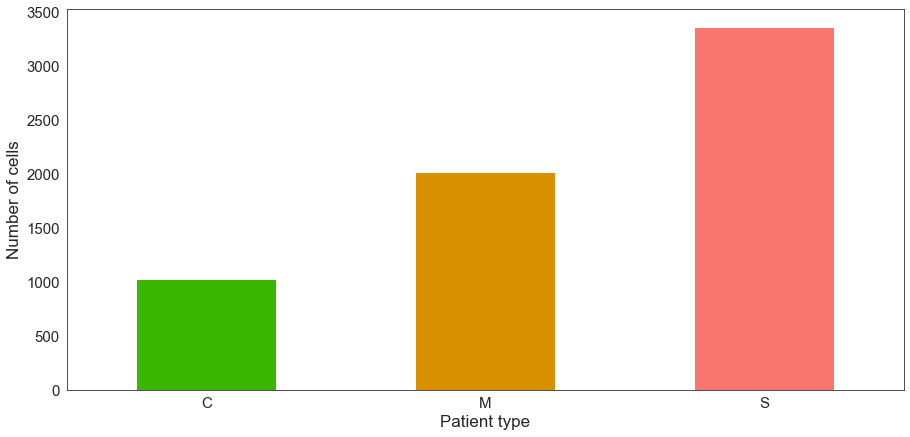

In [11]:
curr_type = 'T_cells'

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 7))
    full_meta.groupby('group')[curr_type].sum().plot(kind='bar', ax=ax, rot=0, color=[colors['green'], colors['yellow'], colors['red']])
    plt.xlabel('Patient type')
    plt.ylabel('Number of cells')
    plt.savefig(f'tmp/tmp_{curr_type}_cell_count.pdf')

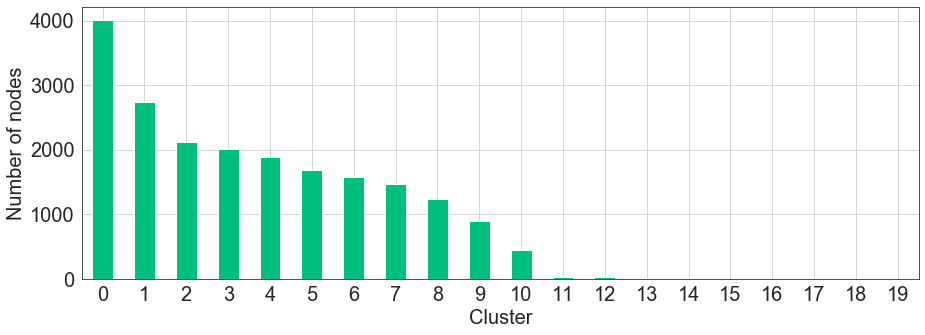

In [159]:
curr_type = 'Monocyte'
algo = 'leiden'
curr_data = 'data_all'

data_to = os.path.join(_DATA_HOME, 'cell_types', curr_type, 'data', 'grnboost2', f'{algo}_communities')

data_all = pd.read_pickle(os.path.join(data_to, f'raw_data_communities_info.pickle'))
data_C, data_M, data_S = [
    pd.read_pickle(os.path.join(data_to, f'raw_data_{pat}_type_communities_info.pickle')) for pat in ['C', 'M', 'S']
]

data_to_plot = eval(curr_data)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 5))
    data_to_plot['num_nodes'].plot(kind='bar', ax=ax, rot=0, color=colors['saturated_green'])
    plt.xlabel('Cluster', fontsize=20)
    plt.ylabel('Number of nodes', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.grid(True)
    plt.savefig(f'tmp/tmp_{curr_type}_cluster_node_count.pdf', bbox_inches='tight')

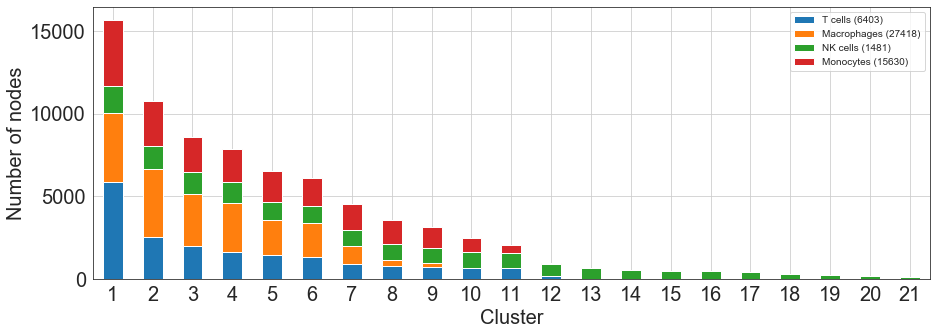

In [86]:
def get_num_cells(pat, data):
    if pat in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == pat] if pat != 'all_data' else full_meta
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return int(curr_meta[col_key].sum())
    else:
        if data != 'all_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return int(full_meta.loc[pat, col_key])
    
cell_types = ['T_cells', 'Macrophage', 'NK_cell', 'Monocyte']
titles = dict(zip(
    cell_types,
    [f'T cells ({get_num_cells("all_data", "T_cells")})', f'Macrophages ({get_num_cells("all_data", "Macrophage")})', 
     f'NK cells ({get_num_cells("all_data", "NK_cell")})', f'Monocytes ({get_num_cells("all_data", "Monocyte")})']
))
algo = 'leiden'
curr_data = 'data_all'

with sns.axes_style("white"):
    
    df = pd.concat([
        pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', curr_type, 'data', 'grnboost2', f'{algo}_communities', 'raw_data_communities_info.pickle'
        ))['num_nodes'].rename(curr_type) for curr_type in cell_types
    ], axis=1).fillna(0).rename(columns=titles).assign(new_index=range(1, 22)).set_index('new_index')
    
    f, ax = plt.subplots(figsize=(15, 5))
    
    df.plot(kind='bar', stacked=True, ax=ax, rot=0)
    
    plt.xlabel('Cluster', fontsize=20)
    plt.ylabel('Number of nodes', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.grid(True)
    plt.legend()
    plt.savefig(f'tmp/tmp_cluster_node_count.pdf', bbox_inches='tight')

In [74]:
from src.func import *
%autoreload 2
def resave_plot(data, data_type, plot_type, save_fig, save_fig_title):
    
    algo = 'leiden'
    limit_anno_until = 50
    G_size_to_plot = 2000
    seed = 42
        
    # Loading the gene functional annotation
    anno_db_tags = ['GO', 'KEGG', 'immunological', 'hallmark']
    gene_func_dbs = {tag: load_gene_func_db(tag, as_series=True) for tag in anno_db_tags}
    
    # Loading graph
    G = get_nx_graph(data=data, data_type='all', get_filtered=filter_quantile)
    print('Loaded the graph..')
    
    # Getting partitions
    if algo == 'louvain':
        partition = community_louvain.best_partition(G.to_undirected(), weight='importance', random_state=seed)
    elif algo == 'leiden':
        G_igraph = ig.Graph.from_networkx(G.to_undirected())
        la_partition = la.find_partition(G_igraph, la.ModularityVertexPartition, weights='importance', seed=seed)
        partition = {G_igraph.vs[node]['_nx_name']: i for i, cluster_nodes in enumerate(la_partition) for node in cluster_nodes}
    else:
        raise NotImplementedError
        
    print('Computed partition..')
        
    num_partitions = len(set(partition.values()))
    
    df = pd.read_pickle(
        os.path.join(_DATA_HOME, 'cell_types', data, 'data', 
                     'grnboost2', f'{algo}_communities', f'raw_data_communities_info.pickle')
    )

    if data_type == 'all':
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_communities_info.pickle'
        ))
    else:
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_{data_type}_type_communities_info.pickle'
        ))  
    print('Loaded pre-computed results..')
    
    # Getting positions of squeezed graph - we do not plot every gene on the figure
    squeezed_G, squeezed_partition = squeeze_graph(G, partition, approximate_size=G_size_to_plot)
    squeezed_pos = nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)

    # squeezed_pos = netgraph_community_layout(squeezed_G, squeezed_partition, seed=seed)  # nx.nx_agraph.pygraphviz_layout(G.to_undirected(), prog="sfdp")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)

    print('Started plotting..')
    f, ax = plt.subplots(figsize=(20, 20))

    nx.draw(squeezed_G, squeezed_pos, ax=ax, arrowstyle="->", arrowsize=20, 
            connectionstyle=f'arc3, rad = 0.25', edge_color='gray', width=0.4, 
            node_color='k', node_size=50, alpha=0.01)
    nx.draw_networkx_nodes(squeezed_G, squeezed_pos, ax=ax, node_size=100, 
                           nodelist=list(squeezed_partition.keys()), 
                           node_color='gray', 
                           alpha=0.1)

    ax.set_title(f'Found communities ({pat}, "all", {data}), '
                 f'annotation - {plot_type}', 
                 fontsize=30)
    plt.axis('off')
    print('Finished plotting..')

    if save_fig:
        plt.savefig(f'tmp/{save_fig_title}.pdf', bbox_inches='tight')
        
widget = interactive(
    resave_plot, 
    {'manual': True},
    data=['Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    data_type = ['all', 'C', 'M', 'S'],
    plot_type = ['genes', 'func_GO', 'func_KEGG', 'func_immunological', 'func_hallmark'],
    save_fig = [True, False],
    save_fig_title = 'tmp_wordcloud_example_1'
)
display(widget)

interactive(children=(Dropdown(description='data', options=('Macrophage', 'T_cells', 'DC', 'Monocyte', 'NK_cel…

In [ ]:
def DG_ana_TF_target(data, save_fig, plot_title):
    
    from matplotlib.lines import Line2D
    from itertools import chain, zip_longest
    
    warnings.simplefilter("ignore")
    
    def make_proxy(clr, **kwargs):
        return Line2D([], [], color=clr, **kwargs)
    
    def quantile_normalization(merged):
        tmp = merged[[col for col in merged.columns if col.startswith('importance')]]
        rank_mean = tmp.stack().groupby(tmp.rank(method='first').stack().astype(int)).mean()
        tmp = tmp.rank(method='min').stack().astype(int).map(rank_mean).unstack()

        for col in tmp.columns:
            merged[col] = tmp[col]
        
        return merged

    types = ['C', 'M', 'S', 'all']
    colors_to_plot = {
        'C': colors['green'],
        'M': colors['yellow'],
        'S': colors['red'],
        'A': 'gray'
    }

    thresh = 2
    log_FC_thresh = 2
    max_plot_len = 10
    top_n = 15

    seed = 42
    np.random.seed(seed)
    sns.set_style("whitegrid")
    node_size = 800
    alpha = 0.5

    # Getting adjacency lists
    adj_lists = {
        t: get_adj_list(data, data_type='ctx', pat=t, get_filtered=filter_quantile) for t in types
    }

    # Getting viper TF scores
    tf_mats = {
        t: get_dorothea_mat(data, pat=t) for t in types
    }

    # Finding common tfs, subsetting
    common_tfs = set(tf_mats['C'].index) \
        .intersection(set(tf_mats['M'].index)) \
        .intersection(set(tf_mats['S'].index)) \
        .intersection(set(tf_mats['all'].index))
    tf_mats = {
        t: mat.loc[mat.index.isin(common_tfs)] for t, mat in tf_mats.items()
    }

    # Plotting VIPER score distribution across samples
    f, ax = plt.subplots(figsize=(15, 7))
    tmp_data = pd.concat([
        pd.DataFrame({
            'score': tf_mats[t].values.reshape(-1),
            'type': [t]*tf_mats[t].size
        }) for t in types
    ]).reset_index(drop=True)
    sns.histplot(data=tmp_data, x='score', hue='type', kde=True, palette=sns.color_palette('bright')[:4], ax=ax)
    ax.set_title(f'The difference in VIPER scores between data {data}')
    ax.set_xlabel('Viper score')
    ax.set_ylabel('Count')

    # Finding TFs that are active in all 4 data sets
    active_tfs = {
        t: tf_mats[t].loc[tf_mats[t].median(axis=1) > thresh].index for t in types
    }
    common_viper_tfs =set(active_tfs['C']) \
        .intersection(set(active_tfs['M'])) \
        .intersection(set(active_tfs['S'])) \
        .intersection(set(active_tfs['all']))
    
    print(f'With the threshold={thresh} we have {len(common_viper_tfs)} TFs that are active (according to VIPER) in {data}..')

    # Adding _all, _C, _M, _S suffixes to each adjacency list
    adj_lists = {
        t: el.rename(
            columns={col: f'{col}_{t}' for col in el.columns if col not in ['TF', 'target']}
        ) for t, el in adj_lists.items()
    }

    # Finding TF regulons that are present in at least one adjacency list, filling NaN importances with 0
    merged = (
        reduce(
            lambda left, right: pd.merge(left, right, on=['TF', 'target'], how='outer'), 
            adj_lists.values()
        ).loc[lambda x: x['TF'] != x['target']]  # filtering out self-loopt
        .fillna(0)  # NaN -> 0
    )
    merged = merged[[col for col in merged if col.startswith('importance') or col in ['TF', 'target']]]  # keeping only importances

    # Quantile normalization
    merged = quantile_normalization(merged)

    # Getting only TF regulons that are active according to VIPER score
    final_merged = merged[merged['TF'].isin(common_viper_tfs)]
    final_TFs = list(final_merged.TF.unique())
    
    print(f'After data merging we have {len(common_viper_tfs)} TFs that we can work with..')

    # Plotting 4 TF-target clusters starting with the ones that have highest amount of links
    tfs_to_plot = list(
        final_merged.groupby('TF')['target'].nunique().sort_values(ascending=False).index[:max_plot_len]
    )
    f, ax = plt.subplots(figsize=(12, 3*len(tfs_to_plot)), 
                         nrows=len(tfs_to_plot) // 2 + len(tfs_to_plot) % 2, 
                         ncols=2)
    bbox = dict(boxstyle="round", ec="aliceblue", fc="aliceblue", alpha=0.5)
    ax_flattened = ax.flatten()

    for tf, a in zip(tfs_to_plot, ax_flattened):

        # Obtaining adj list for the current TF
        curr_adj_list = final_merged[final_merged['TF'] == tf]

        # Obtaining log_FC w.r.t 'importance_all' and defining the color
        targets_to_drop = []
        for i, row_i in curr_adj_list.iterrows():
            vals = row_i.loc[[f'importance_{t}' for t in types]] + 1  # adding 1 in case of zero

            log_FCs = []
            for t, v in zip(types, vals):
                curr_adj_list.loc[i, f'logFC_{t}'] = np.log2(v / vals['importance_all'])
                log_FCs.append(np.log2(v / vals['importance_all']))

            log_FCs = pd.Series(log_FCs, index=types)
            if (log_FCs > log_FC_thresh).sum() == 1:  # if only one link has positive expression
                tag = log_FCs.index[log_FCs > log_FC_thresh][0].replace('importance_', '')
                curr_adj_list.loc[i, 'tag'] = tag
                curr_adj_list.loc[i, 'color'] = colors_to_plot[tag]
                curr_adj_list.loc[i, 'importance'] = curr_adj_list.loc[i, f'importance_{tag}']
            elif (log_FCs > log_FC_thresh).sum() > 1:
                tag = 'A'
                curr_adj_list.loc[i, 'tag'] = tag
                curr_adj_list.loc[i, 'color'] = colors_to_plot[tag]
                curr_adj_list.loc[i, 'importance'] = curr_adj_list.loc[
                    i, filter(lambda x: x.startswith('importance'), curr_adj_list.columns)
                ].mean()
            else:
                targets_to_drop.append(row_i['target'])
                
        print()
        print(colored(f'For {tf} TF we have {len(curr_adj_list)} targets..', 'cyan'))
        for tag in colors_to_plot.keys():
            print(colored(f'{tag}-specific genes:', 'green'))
            print('\n'.join([tf] + curr_adj_list['target'][curr_adj_list['tag'] == tag].to_list()))
            print()

        # Keeping only top_n diverse links
        sort_ind_by_color = curr_adj_list.sort_values('importance', ascending=False) \
            .groupby('color').head(len(curr_adj_list)).reset_index() \
            .groupby('color')['index'].agg(lambda x: x.to_list()).to_list()
        alter_c_ind = [
            el for el in chain.from_iterable(zip_longest(*sort_ind_by_color)) if el is not None
        ]
        import random
        curr_adj_list = curr_adj_list.reindex(alter_c_ind)[:random.randint(3, 15)]

        G = nx.from_pandas_edgelist(curr_adj_list, 'TF', 'target', ['tag', 'color', 'importance'], 
                                    create_using=nx.DiGraph)
        pos = nx.nx.spring_layout(G, seed=seed)

        edges, importances = zip(*nx.get_edge_attributes(G, 'importance').items())
        widths = scale(importances, 1, 6)

        # Plotting TF nodes
        nx.draw_networkx_nodes(G, pos, nodelist=curr_adj_list['TF'], 
                               node_color=sns.color_palette()[0], ax=a, node_size=node_size, 
                               )

        # Ploting labels
        # nx.draw_networkx_labels(G, pos, ax=a, font_color=sns.color_palette()[0], bbox=bbox)
        
        # Plotting target nodes
        nx.draw_networkx_nodes(G, pos, nodelist=curr_adj_list['target'], 
                               ax=a, node_size=node_size, 
                               node_color='silver')

        # Plotting edges
        G_colors = [G[u][v]['color'] for u,v in G.edges()]
        nx.draw_networkx_edges(G, pos, ax=a, edge_color='silver', arrowstyle="->", arrowsize=30, 
                                   node_size=node_size, width=2)

        a.axis('off')

    # generating legend
    #proxies = [make_proxy(c, lw=5) for c in colors_to_plot.values()]
    #labels = [f'active in {tag} patients' if tag != 'A' else 'active in patients' for tag in colors_to_plot.keys()]
    #f.legend(proxies, labels, frameon=False, loc='center right')

    #f.suptitle(f'Active links in different regulons, {data}', fontsize=20)
    
    if save_fig:
        i = 0
        while os.path.exists(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf')):
            i += 1
        plt.savefig(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf'), bbox_inches='tight')
        
widget = interactive(
    DG_ana_TF_target, 
    {'manual': True},
    data=['all_data', 'Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    save_fig=[False, True],
    plot_title='tf_target_enriched'
)
display(widget)

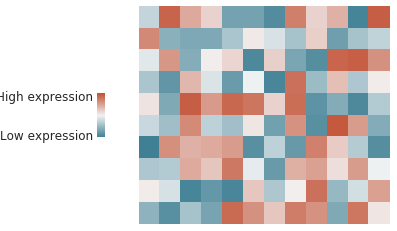

In [40]:
with sns.axes_style("white"):
    np.random.seed(42)
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    uniform_data = np.random.uniform(-1, 1, size=(10, 12))
    ax = sns.heatmap(uniform_data, cmap=cmap, vmin = -1, vmax = 1, cbar_kws={"shrink": .2, 'aspect': 5, 'use_gridspec': False, 'location': 'left'})
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([-0.9, 0.9])
    cbar.set_ticklabels(['Low expression', 'High expression'])
    plt.axis('off')
    cbar.ax.tick_params(size=0, labelsize=12)
    cbar.ax.yaxis.set_ticks_position('left')
    plt.savefig('figs/matrix_template.svg')

In [ ]:
%%time
%autoreload 2

from src.func import *
from joblib import Parallel, delayed

def get_num_cells(pat, data):
    if pat in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == pat] if pat != 'all_data' else full_meta
        if data != 'all_data' and data != 'raw_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return int(curr_meta[col_key].sum())
    else:
        if data != 'all_data' and data != 'raw_data':
            col_key = data.replace("raw_data_", "")
        else:
            col_key = 'num_cells'
        return int(full_meta.loc[pat, col_key])
    
def compute_graph_stats(curr_pat_, curr_data_, curr_data_type_):
    
    out = {}
    try:
        full_G = get_nx_graph(curr_data_, curr_data_type_, pat=curr_pat_, get_filtered=filter_quantile)
        if not nx.is_connected(full_G.to_undirected()):
            Gcc = sorted(nx.connected_components(full_G.to_undirected()), key=len, reverse=True)
            G_biggest = full_G.subgraph(Gcc[0])
        else:
            G_biggest = full_G
        G_igraph = ig.Graph.from_networkx(G_biggest.to_undirected())
        out = {
            'num_nodes': full_G.number_of_nodes(), 
            'num_edges': full_G.number_of_edges(),
            'num_cells': get_num_cells(curr_pat_, curr_data_),
            'average_degree': np.mean([degree for node, degree in full_G.degree(full_G.nodes())]),
            'radius': G_igraph.radius(),
            'average_path_length': G_igraph.average_path_length(),
            'diameter': G_igraph.diameter(),
            'importance': [info['importance'] for st, end, info in full_G.edges(data=True)],
            'rho': [info['rho'] for st, end, info in full_G.edges(data=True)],
            'median_importance': np.median([info['importance'] for st, end, info in full_G.edges(data=True)]),
            'median_rho': np.median([info['rho'] for st, end, info in full_G.edges(data=True)]),
            'STD_importance': np.std([info['importance'] for st, end, info in full_G.edges(data=True)]), 
            'STD_rho': np.std([info['rho'] for st, end, info in full_G.edges(data=True)]),    
            'tfs': set([st for st, _, _ in full_G.edges(data=True)]),
            'num_tfs': len(set([st for st, _, _ in full_G.edges(data=True)]))
        }
    except BaseException as e:
        print(f'Caugh an error with the message:\n{e}')
    
    return out

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

stat_types = ['num_nodes', 'num_edges', 'num_cells', 'average_degree', 'radius', 
              'average_path_length', 'diameter', 'importance', 'rho',
              'median_importance', 'median_rho', 'STD_importance', 'STD_rho',
              'tfs', 'num_tfs']
num_all_sets = get_avail_graph_mat()['all'].sum().sum()
n_jobs = 48

all_out = Parallel(n_jobs=n_jobs)(
    delayed(compute_graph_stats)(curr_pat, curr_data, curr_data_type) for curr_data_type in ['all', 'ctx']
        for curr_pat in get_avail_graph_mat()[curr_data_type].index
        for curr_data in get_avail_list(curr_data_type, curr_pat)
)

graph_stats = {
    curr_data_type: {
        curr_stat_type: [
            tmp_dict[curr_stat_type] for tmp_dict in el if len(tmp_dict) != 0
        ] for curr_stat_type in stat_types
    } for curr_data_type, el in zip(['all', 'ctx'], chunks(all_out, num_all_sets))
}

graph_stats['all']['importance'] = list(itertools.chain(*graph_stats['all']['importance']))
graph_stats['all']['rho'] = list(itertools.chain(*graph_stats['all']['rho']))
graph_stats['ctx']['importance'] = list(itertools.chain(*graph_stats['ctx']['importance']))
graph_stats['ctx']['rho'] = list(itertools.chain(*graph_stats['ctx']['rho']))

CPU times: user 15.9 s, sys: 5 s, total: 20.9 s
Wall time: 4min 37s


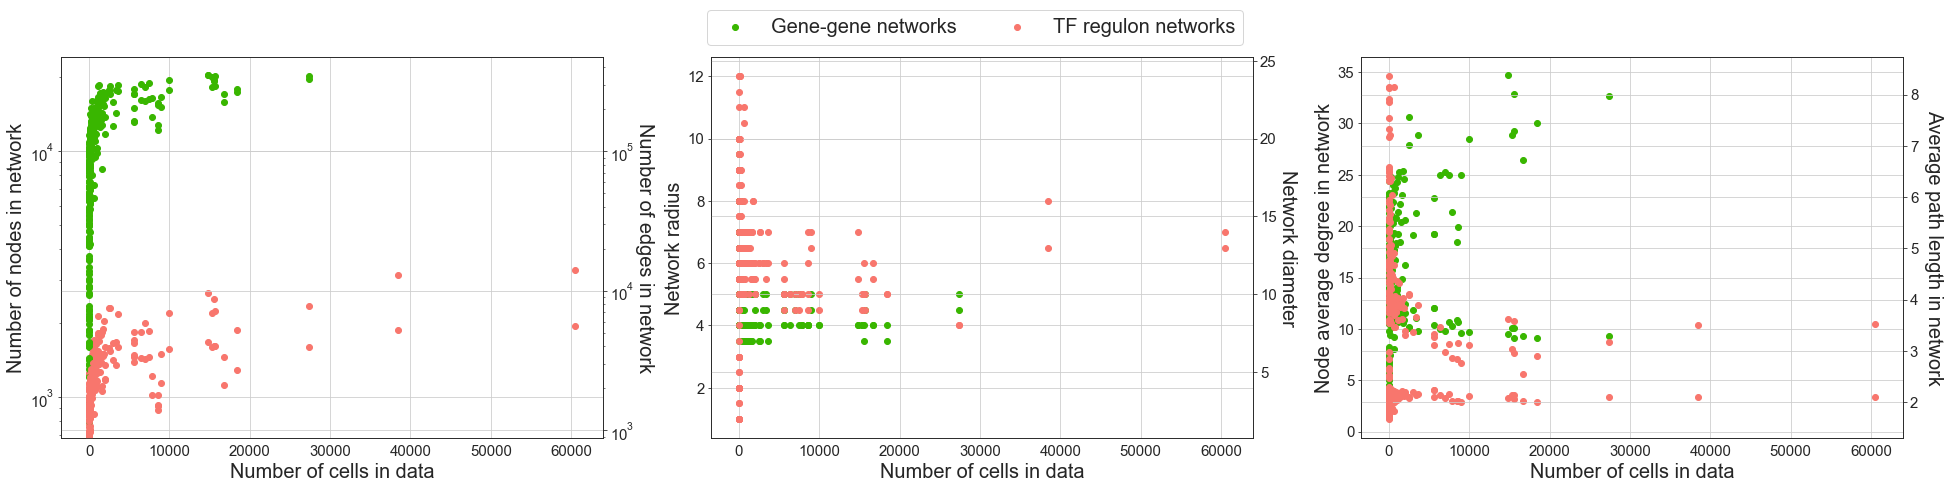

In [218]:
with sns.axes_style('white'):
    
    f, ax = plt.subplots(1, 3, figsize=(33, 7))
    
    # Plotting num_nodes vs num_edges vs num_cells
    ax[0].scatter(graph_stats['all']['num_cells'], graph_stats['all']['num_nodes'], color=colors['green'], label='Gene-gene networks')
    ax[0].scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['num_nodes'], color=colors['red'], label='TF regulon networks')
    
    ax1 = ax[0].twinx()
    ax1.scatter(graph_stats['all']['num_cells'], graph_stats['all']['num_edges'], color=colors['green'])
    ax1.scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['num_edges'], color=colors['red'])
    
    ax[0].set_xlabel('Number of cells in data', fontsize=20)
    ax[0].set_ylabel('Number of nodes in network', fontsize=20)
    ax1.set_ylabel('Number of edges in network', rotation=270, labelpad=20, fontsize=20)
    
    ax[0].set_yscale('log')
    ax1.set_yscale('log')
    
    ax[0].grid(True)
    ax1.grid(True)
    
    # Plotting radius vs diameter vs num_cells
    ax[1].scatter(graph_stats['all']['num_cells'], graph_stats['all']['radius'], color=colors['green'])
    ax[1].scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['radius'], color=colors['red'])
    
    ax1 = ax[1].twinx()
    ax1.scatter(graph_stats['all']['num_cells'], graph_stats['all']['diameter'], color=colors['green'])
    ax1.scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['diameter'], color=colors['red'])
    
    ax[1].set_xlabel('Number of cells in data', fontsize=20)
    ax[1].set_ylabel('Network radius', fontsize=20)
    ax1.set_ylabel('Network diameter', rotation=270, labelpad=20, fontsize=20)

    ax[1].grid(True)
    ax1.grid(True)
    
    # Plotting average_degree vs average_path_length vs num_cells
    ax[2].scatter(graph_stats['all']['num_cells'], graph_stats['all']['average_degree'], color=colors['green'])
    ax[2].scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['average_degree'], color=colors['red'])
    
    ax1 = ax[2].twinx()
    ax1.scatter(graph_stats['all']['num_cells'], graph_stats['all']['average_path_length'], color=colors['green'])
    ax1.scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['average_path_length'], color=colors['red'])
    
    ax[2].set_xlabel('Number of cells in data', fontsize=20)
    ax[2].set_ylabel('Node average degree in network', fontsize=20)
    ax1.set_ylabel('Average path length in network', rotation=270, labelpad=25, fontsize=20)
    
    ax[2].grid(True)
    ax1.grid(True)
    
    handles, labels = ax[0].get_legend_handles_labels()
    f.legend(handles, labels, loc='upper center', ncol=2, prop={'size': 20})
    
    plt.savefig('figs/graph_stats.pdf', bbox_inches='tight')

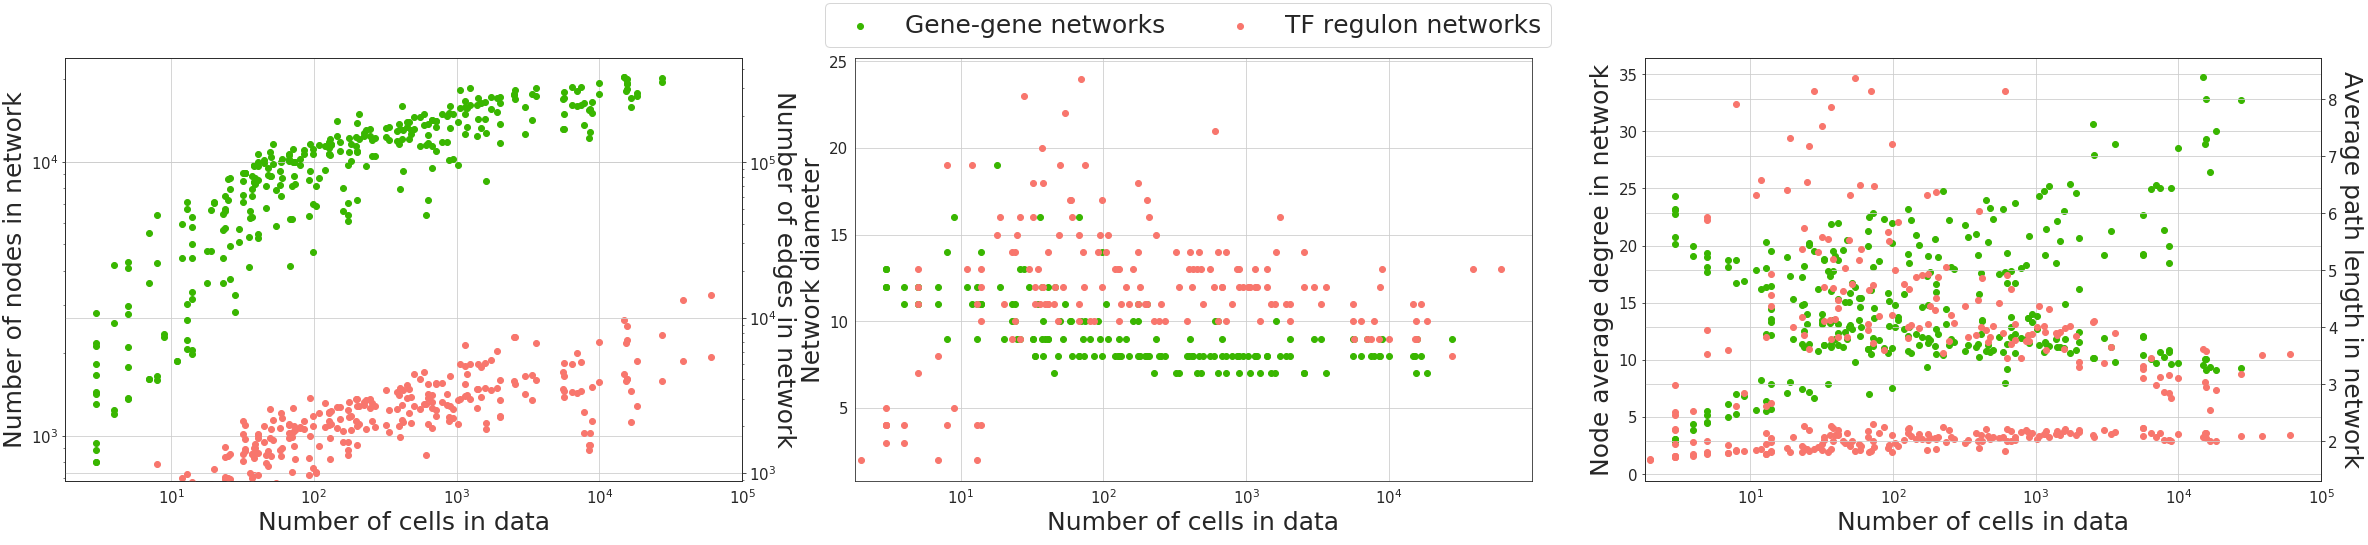

In [15]:
with sns.axes_style('white'):
    
    fontsize = 25
    
    f, ax = plt.subplots(1, 3, figsize=(33, 7))
    
    # Plotting num_nodes vs num_edges vs num_cells
    ax[0].scatter(graph_stats['all']['num_cells'], graph_stats['all']['num_nodes'], color=colors['green'], label='Gene-gene networks')
    ax[0].scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['num_nodes'], color=colors['red'], label='TF regulon networks')
    
    ax1 = ax[0].twinx()
    ax1.scatter(graph_stats['all']['num_cells'], graph_stats['all']['num_edges'], color=colors['green'])
    ax1.scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['num_edges'], color=colors['red'])
    
    ax[0].set_xlabel('Number of cells in data', fontsize=fontsize)
    ax[0].set_ylabel('Number of nodes in network', fontsize=fontsize)
    ax1.set_ylabel('Number of edges in network', rotation=270, labelpad=20, fontsize=fontsize)
    
    ax[0].set_yscale('log')
    ax1.set_yscale('log')
    
    ax[0].grid(True)
    ax1.grid(True)
    
    # Plotting radius vs diameter vs num_cells
    ax[1].scatter(graph_stats['all']['num_cells'], graph_stats['all']['diameter'], color=colors['green'])
    ax[1].scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['diameter'], color=colors['red'])
    
    ax[1].set_xlabel('Number of cells in data', fontsize=fontsize)
    ax[1].set_ylabel('Network diameter', fontsize=fontsize)

    ax[1].grid(True)
    
    # Plotting average_degree vs average_path_length vs num_cells
    ax[2].scatter(graph_stats['all']['num_cells'], graph_stats['all']['average_degree'], color=colors['green'])
    ax[2].scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['average_degree'], color=colors['red'])
    
    ax1 = ax[2].twinx()
    ax1.scatter(graph_stats['all']['num_cells'], graph_stats['all']['average_path_length'], color=colors['green'])
    ax1.scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['average_path_length'], color=colors['red'])
    
    ax[2].set_xlabel('Number of cells in data', fontsize=fontsize)
    ax[2].set_ylabel('Node average degree in network', fontsize=fontsize)
    ax1.set_ylabel('Average path length in network', rotation=270, labelpad=25, fontsize=fontsize)
    
    ax[2].grid(True)
    ax1.grid(True)
    
    handles, labels = ax[0].get_legend_handles_labels()
    f.legend(handles, labels, loc='upper center', ncol=2, prop={'size': fontsize}, bbox_to_anchor=(0.5, 1.1))
    
    for i in range(3):
        ax[i].set_xscale('log')
    
    plt.tight_layout()
    
    plt.savefig('figs/graph_stats.pdf', bbox_inches='tight')

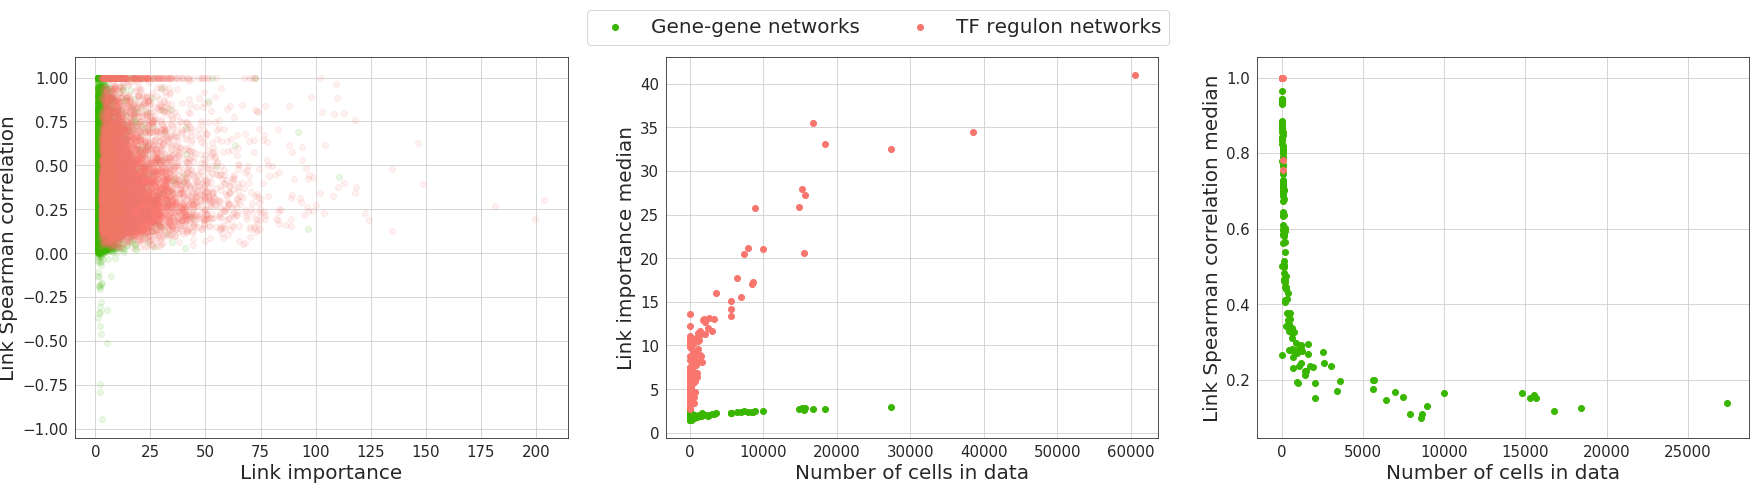

In [13]:
with sns.axes_style('white'):
    
    fontsize = 20
    
    seed = 42
    np.random.seed(seed)

    f, ax = plt.subplots(1, 3, figsize=(30, 7))
    
    # Plotting importance and rho
    importance_all, rho_all = np.random.choice(graph_stats['all']['importance'], size=10000), np.random.choice(graph_stats['all']['rho'], size=10000)
    importance_ctx, rho_ctx = np.random.choice(graph_stats['ctx']['importance'], size=10000), np.random.choice(graph_stats['ctx']['rho'], size=10000)
    ax[0].scatter(importance_all, rho_all, color=colors['green'], alpha=0.1)
    ax[0].scatter(importance_ctx, rho_ctx, color=colors['red'], alpha=0.1)
    
    ax[0].set_xlabel('Link importance', fontsize=fontsize)
    ax[0].set_ylabel('Link Spearman correlation', fontsize=fontsize)

    ax[0].grid(True)

    # Plotting importance median and std
    ax[1].scatter(graph_stats['all']['num_cells'], graph_stats['all']['median_importance'], color=colors['green'], label='Gene-gene networks')
    ax[1].scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['median_importance'], color=colors['red'], label='TF regulon networks')

    ax[1].set_xlabel('Number of cells in data', fontsize=fontsize)
    ax[1].set_ylabel('Link importance median', fontsize=fontsize)

    #ax[0].set_yscale('log')

    ax[1].grid(True)

    # Plotting rho median and std
    ax[2].scatter(graph_stats['all']['num_cells'], graph_stats['all']['median_rho'], color=colors['green'])
    ax[2].scatter(graph_stats['ctx']['num_cells'], graph_stats['ctx']['median_rho'], color=colors['red'])

    ax[2].set_xlabel('Number of cells in data', fontsize=fontsize)
    ax[2].set_ylabel('Link Spearman correlation median', fontsize=fontsize)

    ax[2].grid(True)
    
    handles, labels = ax[1].get_legend_handles_labels()
    f.legend(handles, labels, loc='upper center', ncol=2, prop={'size': fontsize})
    
    plt.savefig('figs/graph_attribute_stats.pdf', bbox_inches='tight')

In [41]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

mean_confidence_interval(graph_stats['ctx']['num_tfs'])

(132.6341463414634, 124.8382883222488, 140.43000436067803)

In [40]:
import scipy.stats as st

st.t.interval(alpha=0.95, df=len(graph_stats['ctx']['num_tfs'])-1, loc=np.mean(graph_stats['ctx']['num_tfs']), scale=st.sem(graph_stats['ctx']['num_tfs'])) 

(124.8382883222488, 140.43000436067803)

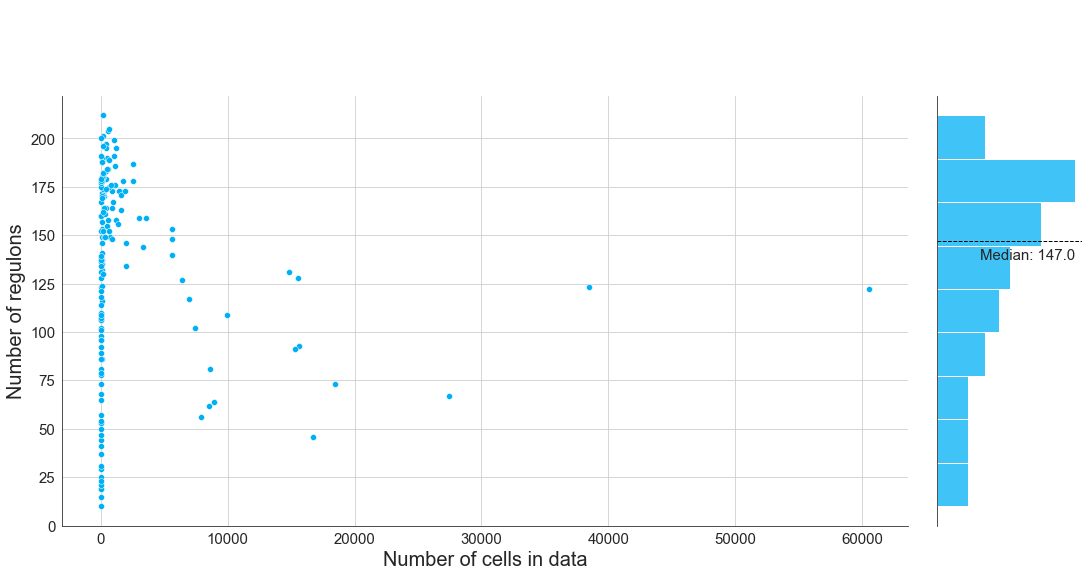

In [38]:
with sns.axes_style('white'):
    
    seed = 42
    np.random.seed(seed)

    # Plotting importance median and std
    g = sns.jointplot(x=graph_stats['ctx']['num_cells'], y=graph_stats['ctx']['num_tfs'], color=colors['blue'])

    g.ax_marg_x.cla()
    g.ax_marg_x.axis('off')
    g.fig.set_size_inches(16, 8)
    
    dist_median = np.median(graph_stats['ctx']['num_tfs'])
    g.ax_marg_y.axhline(dist_median, color='k', linestyle='dashed', linewidth=1)
    min_xlim, max_xlim = g.ax_marg_y.get_xlim()
    g.ax_marg_y.text(max_xlim*0.95, dist_median*0.95, 
                     'Median: {:.1f}'.format(dist_median),
                     horizontalalignment='right',
                     verticalalignment='center', fontsize=15)
    
    g.ax_joint.set_xlabel('Number of cells in data', fontsize=20)
    g.ax_joint.set_ylabel('Number of regulons', fontsize=20)

    g.ax_joint.grid(True)
    
    plt.savefig('figs/regulons.pdf', bbox_inches='tight')

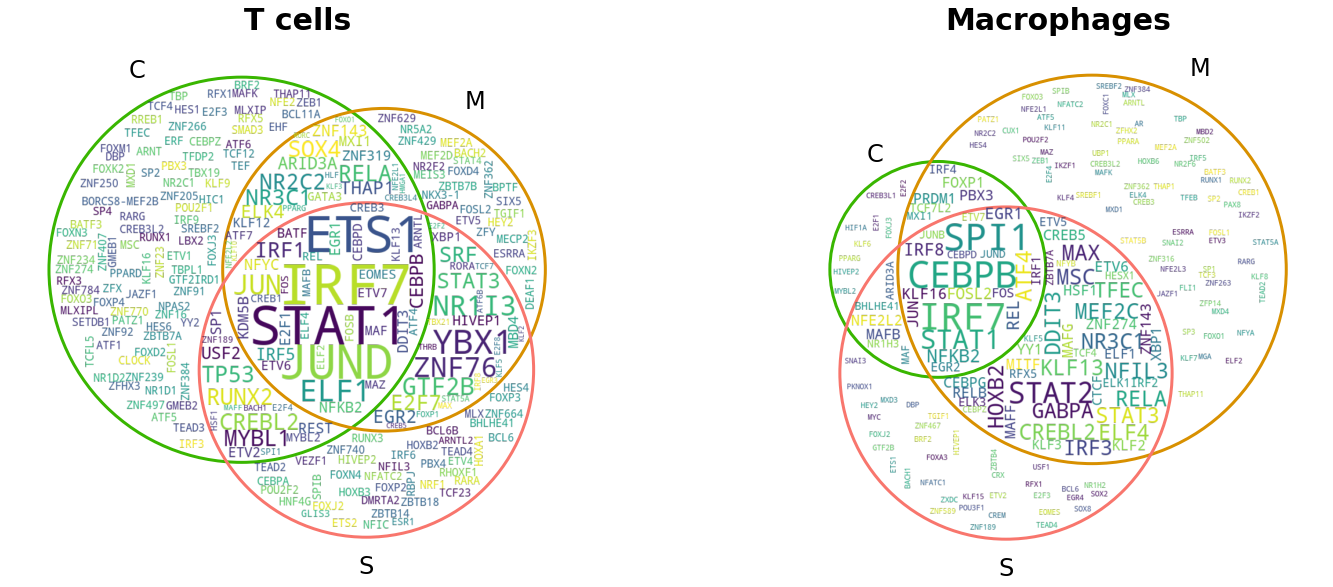

In [17]:
%autoreload 2
from collections import Counter
from src.func import *

cell_types = ['T_cells', 'Macrophage']
types = ['C', 'M', 'S']
titles = {
    'T_cells': 'T cells',
    'Macrophage': 'Macrophages'
}
max_freq = 5
fontsize = 30

TFs = {
    data: {
        t: reduce(lambda x, y: x + y, get_adj_list(data, data_type='ctx', pat=t, get_filtered=filter_quantile)[['TF', 'target']]
                    .groupby('TF').nunique().reset_index().assign(scaled_num=lambda x: scale_int(x.target, 1, max_freq))
                    .apply(lambda row: [row['TF']]*row['scaled_num'], axis=1)) for t in types
    } for data in cell_types
}
word_to_frequency = {
    data: dict(Counter(
        list(reduce(lambda x, y: x + y, list(TFs[data].values())))
    )) for data in cell_types
}

# Cut-off the prevalence of highly-active TFs
word_to_frequency = {
    data: {
        tf: (num if num < max_freq else max_freq) for tf, num in word_to_frequency[data].items()
    } for data in cell_types
}

f, ax = plt.subplots(1, len(cell_types), figsize=(25, 10))

for a, data in zip(ax, cell_types):
    matplotlib_venn_wordcloud.venn3_wordcloud(
        [set(tf_list) for tf_list in TFs[data].values()], 
        set_labels=types,
        set_edgecolors=[colors['green'], colors['yellow'], colors['red']],
        ax=a, 
        word_to_frequency=word_to_frequency[data],
        wordcloud_kwargs=dict(min_font_size=6, width=1200, height=800)
    )

    a.set_title(titles[data], fontsize=fontsize, fontweight='bold')

plt.savefig('figs/tf_shared.pdf', bbox_inches='tight')

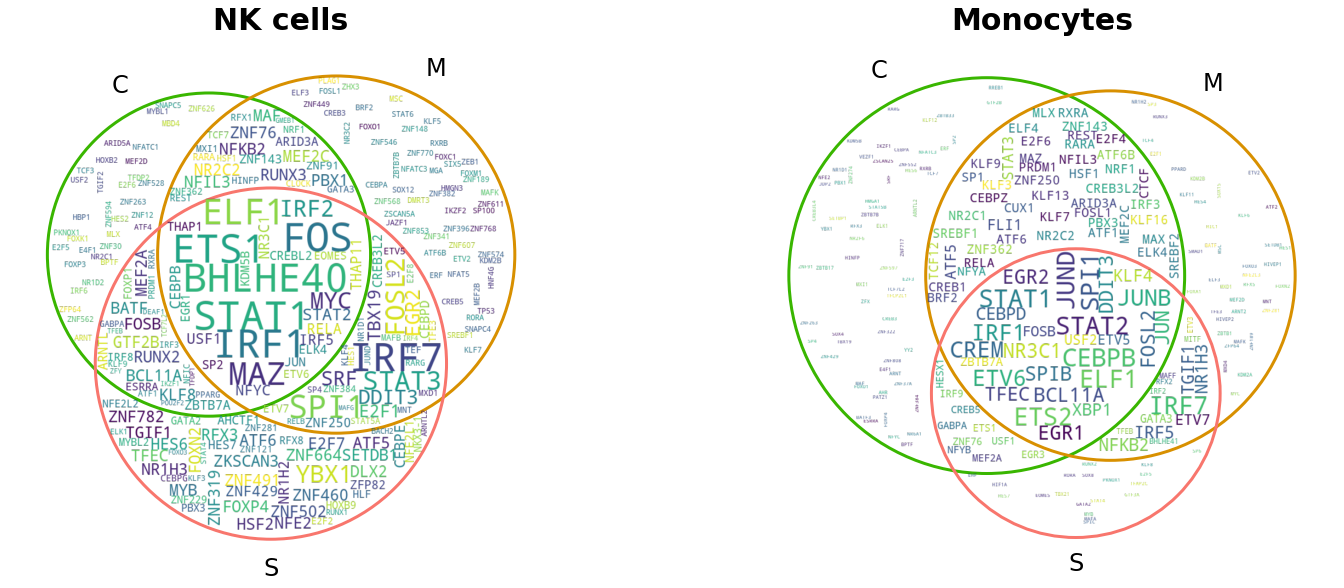

In [18]:
%autoreload 2
from collections import Counter
from src.func import *

cell_types = ['NK_cell', 'Monocyte']
types = ['C', 'M', 'S']
titles = {
    'NK_cell': 'NK cells',
    'Monocyte': 'Monocytes'
}
max_freq = 5

fontsize = 30

TFs = {
    data: {
        t: reduce(lambda x, y: x + y, get_adj_list(data, data_type='ctx', pat=t, get_filtered=filter_quantile)[['TF', 'target']]
                    .groupby('TF').nunique().reset_index().assign(scaled_num=lambda x: scale_int(x.target, 1, max_freq))
                    .apply(lambda row: [row['TF']]*row['scaled_num'], axis=1)) for t in types
    } for data in cell_types
}
word_to_frequency = {
    data: dict(Counter(
        list(reduce(lambda x, y: x + y, list(TFs[data].values())))
    )) for data in cell_types
}
# Cut-off the prevalence of highly-active TFs
word_to_frequency = {
    data: {
        tf: (num if num < max_freq else max_freq) for tf, num in word_to_frequency[data].items()
    } for data in cell_types
}

f, ax = plt.subplots(1, len(cell_types), figsize=(25, 10))

for a, data in zip(ax, cell_types):
    matplotlib_venn_wordcloud.venn3_wordcloud(
        [set(tf_list) for tf_list in TFs[data].values()], 
        set_labels=types,
        set_edgecolors=[colors['green'], colors['yellow'], colors['red']],
        ax=a, 
        word_to_frequency=word_to_frequency[data],
        wordcloud_kwargs=dict(min_font_size=6, width=1200, height=800)
    )

    a.set_title(titles[data], fontsize=fontsize, fontweight='bold')

plt.savefig('figs/tf_shared_supp.pdf', bbox_inches='tight')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

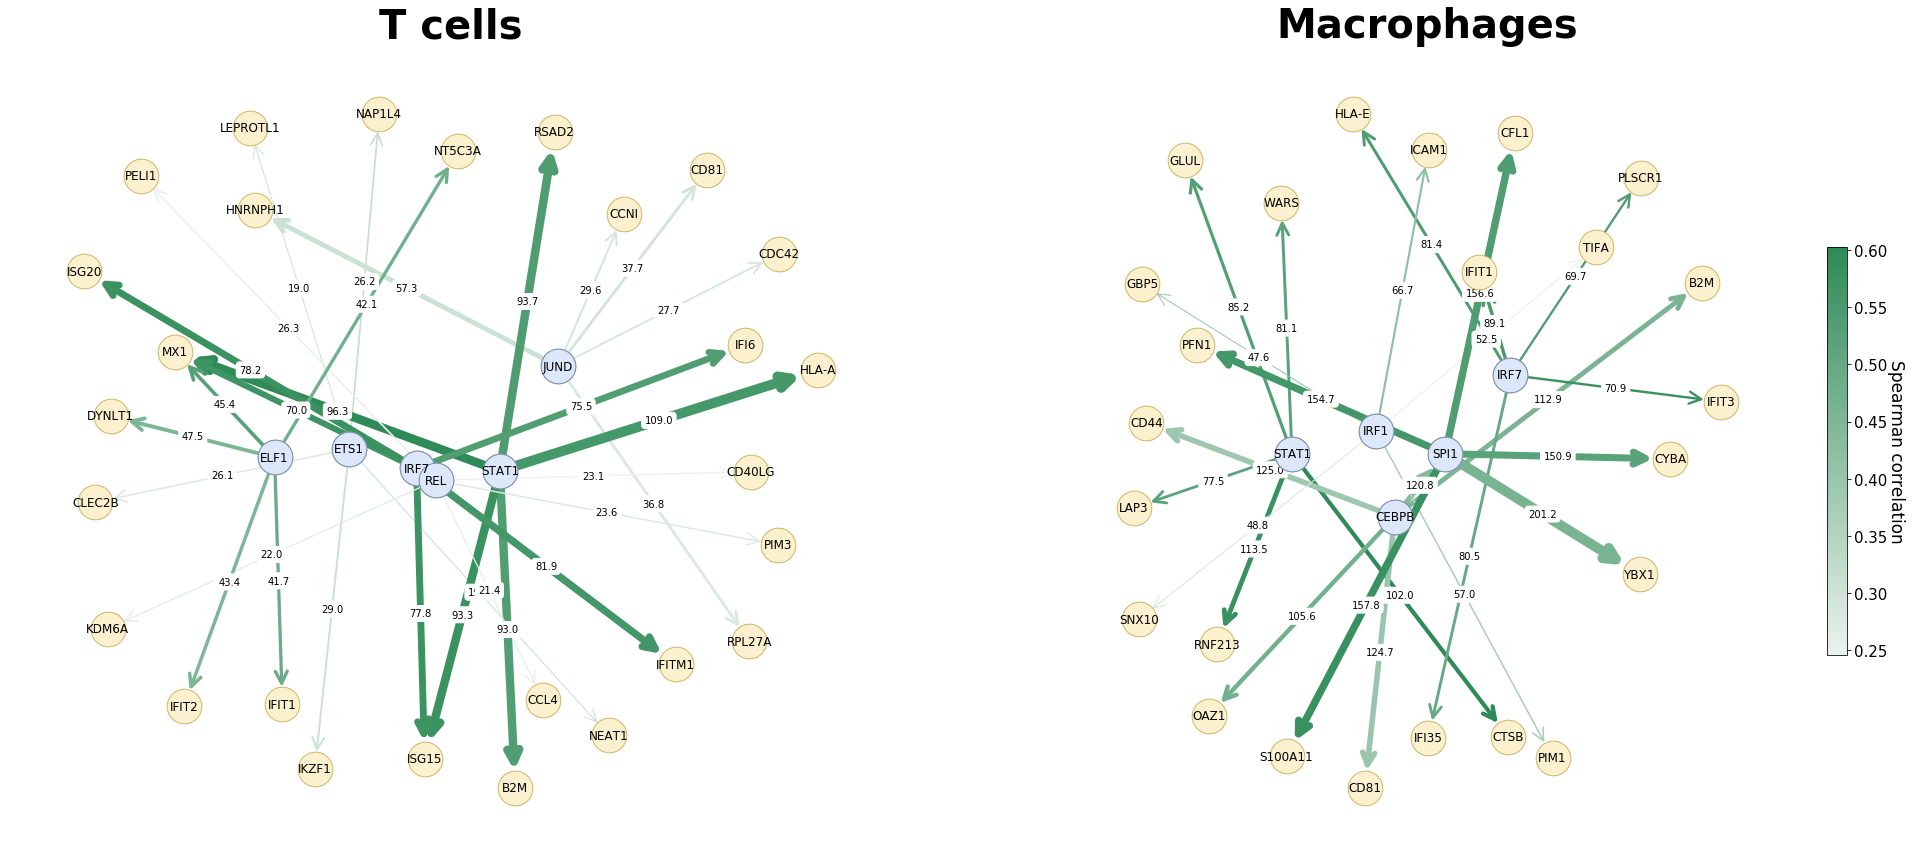

In [19]:
%autoreload 2
from src.func import *

seed = 42
top_n = 5
filtered_quantile = 0.95

fontsize = 40

cell_types = ['T_cells', 'Macrophage']
titles = {
    'T_cells': 'T cells',
    'Macrophage': 'Macrophages'
}
all_TFs = {
    'T_cells': 'STAT1, ETS1, JUND, REL, IRF7, ELF1'.split(', '),
    'Macrophage': 'STAT1, SPI1, IRF7, CEBPB, IRF1'.split(', ')
}

f, ax = plt.subplots(1, 2, figsize=(35, 15))  
flag = False

for i, (data, a) in enumerate(zip(cell_types, ax)):
    
    edges = []

    TFs = all_TFs[data]
    full_G = get_nx_graph(data, 'ctx', pat=None, get_filtered=filtered_quantile)

    # Check if all TFs are present in the graph
    if not all([tf in full_G.nodes() for tf in TFs]):
        warnings.warn(f"""Next TFs are not present in the graph:"""
                      f"""{", ".join([f"'{tf}'" for tf in TFs if tf not in full_G.nodes()])}""")
    TFs_to_plot = [tf for tf in TFs if tf in full_G.nodes()]

    for TF in TFs_to_plot:
        out_link_dict = {end: info['importance'] for st, end, info in full_G.edges(TF, data=True)}
        out_dict_sorted = dict(sorted(out_link_dict.items(), key=lambda x: x[1], reverse=True)[:top_n])
        edges += [(TF, target) for target in out_dict_sorted.keys()]
    G = full_G.edge_subgraph(edges)

    label_edges = True
    if_alpha_edges = False
    alpha = 0.5
    pos = nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)  # nx.nx_agraph.pygraphviz_layout(G, prog="dot")  # 
    cmap = sns.light_palette("seagreen", as_cmap=True)

    draw_graph(G, pos=pos, ax=a, TF_names=TFs_to_plot, label_edges=label_edges, node_size=_NODE_SIZE, 
               if_alpha_edges=if_alpha_edges, plot_cmap=flag, cmap=cmap)

    a.set_title(titles[data], fontsize=fontsize, fontweight='bold')
    
    flag = True
    
    ax[i].axis('off')

plt.savefig('figs/net_example.pdf', bbox_inches='tight') 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

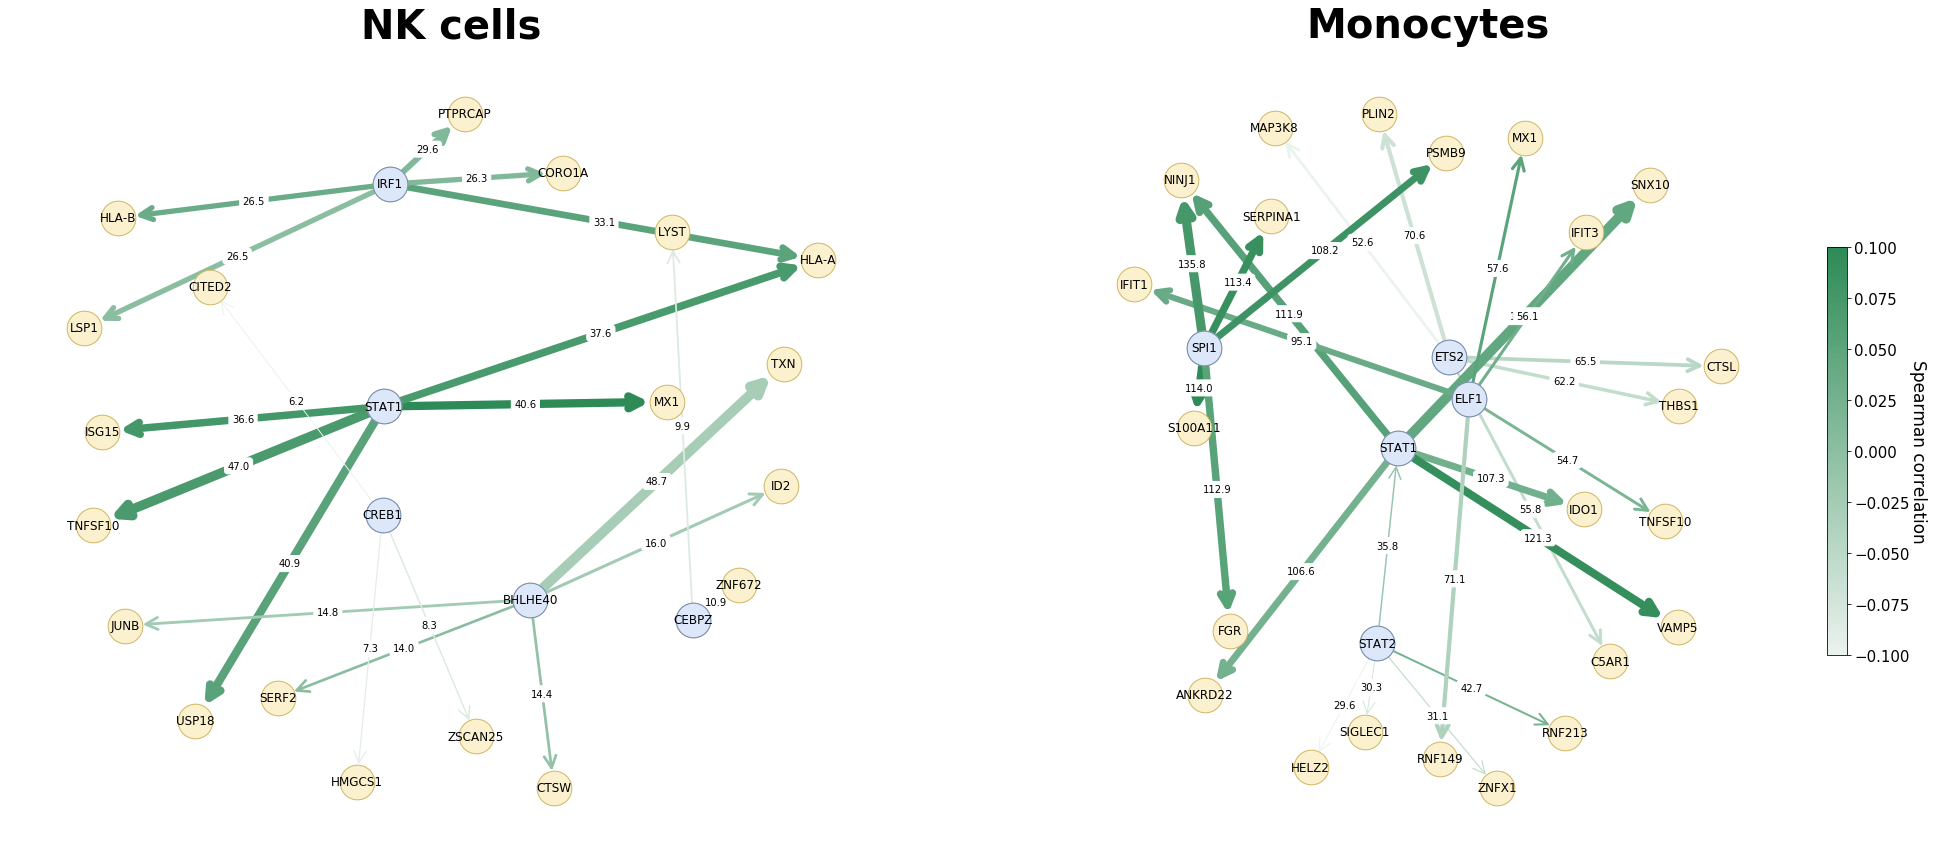

In [20]:
seed = 42
top_n = 5
filtered_quantile = 0.95

cell_types = ['NK_cell', 'Monocyte']
titles = {
    'NK_cell': 'NK cells',
    'Monocyte': 'Monocytes'
}
all_TFs = {
    'NK_cell': 'STAT1, IRF1, CREB1, CEBPZ, BHLHE40'.split(', '),
    'Monocyte': 'STAT1, ETS2, SPI1, STAT2, ELF1'.split(', ')
}

fontsize = 40

f, ax = plt.subplots(1, 2, figsize=(35, 15))  
flag = False

for i, (data, a) in enumerate(zip(cell_types, ax)):
    
    edges = []

    TFs = all_TFs[data]
    full_G = get_nx_graph(data, 'ctx', pat=None, get_filtered=filtered_quantile)

    # Check if all TFs are present in the graph
    if not all([tf in full_G.nodes() for tf in TFs]):
        warnings.warn(f"""Next TFs are not present in the graph:"""
                      f"""{", ".join([f"'{tf}'" for tf in TFs if tf not in full_G.nodes()])}""")
    TFs_to_plot = [tf for tf in TFs if tf in full_G.nodes()]

    for TF in TFs_to_plot:
        out_link_dict = {end: info['importance'] for st, end, info in full_G.edges(TF, data=True)}
        out_dict_sorted = dict(sorted(out_link_dict.items(), key=lambda x: x[1], reverse=True)[:top_n])
        edges += [(TF, target) for target in out_dict_sorted.keys()]
    G = full_G.edge_subgraph(edges)

    label_edges = True
    if_alpha_edges = False
    alpha = 0.5
    pos = nx.nx.spring_layout(G, seed=seed, k=0.58, iterations=20)  # nx.nx_agraph.pygraphviz_layout(G, prog="dot")  # 
    cmap = sns.light_palette("seagreen", as_cmap=True) 

    draw_graph(G, pos=pos, ax=a, TF_names=TFs_to_plot, label_edges=label_edges, node_size=_NODE_SIZE, 
               if_alpha_edges=if_alpha_edges, plot_cmap=flag, cmap=cmap)

    a.set_title(titles[data], fontsize=fontsize, fontweight='bold')
    
    flag = True
    
    ax[i].axis('off')

plt.savefig('figs/net_example.pdf', bbox_inches='tight') 

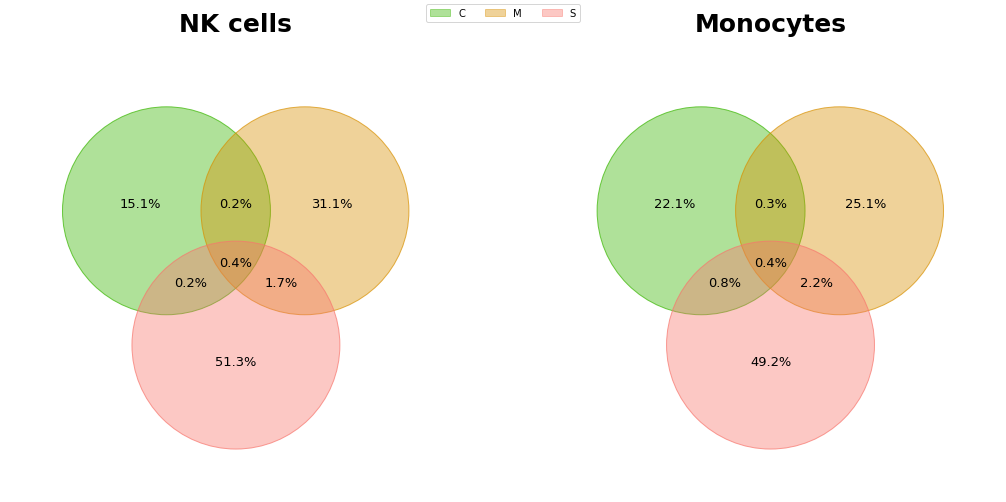

In [23]:
import matplotlib.patches as mpatches

top_n = 5
seed = 42
n_bins = 100
cell_types = ['NK_cell', 'Monocyte']
titles = {
    'NK_cell': 'NK cells',
    'Monocyte': 'Monocytes'
}
types = ['C', 'M', 'S']
cmap = mpl.colors.ListedColormap([colors['green'], colors['yellow'], colors['red']])
fontsize = 25

adj_lists = {
    data: {
        t: get_adj_list(data, 'all', pat=t, get_filtered=filter_quantile) for t in types
    } for data in cell_types
}

f, ax = plt.subplots(1, 2, figsize=(15, 7))

for i, (data, curr_adj_lists) in enumerate(adj_lists.items()):

    plot_venn = venn if len(adj_lists) < 5 else pseudovenn
    
    plot_venn({
        t: set(zip(adj_list['TF'], adj_list['target'])) for t, adj_list in curr_adj_lists.items()
    }, fmt='{percentage:.1f}%', hint_hidden=False, ax=ax[i], cmap=cmap)
    ax[i].set_title(titles[data], fontsize=fontsize, fontweight='bold')
    
    ax[i].get_legend().remove()
    
f.legend(handles = [mpatches.Patch(color=c, label=t, alpha=0.4) for c, t in zip([colors['green'], colors['yellow'], colors['red']], types)], 
         ncol=3, loc='upper center')

plt.tight_layout()

plt.savefig('figs/all_network_edge_overlap.pdf', bbox_inches='tight')

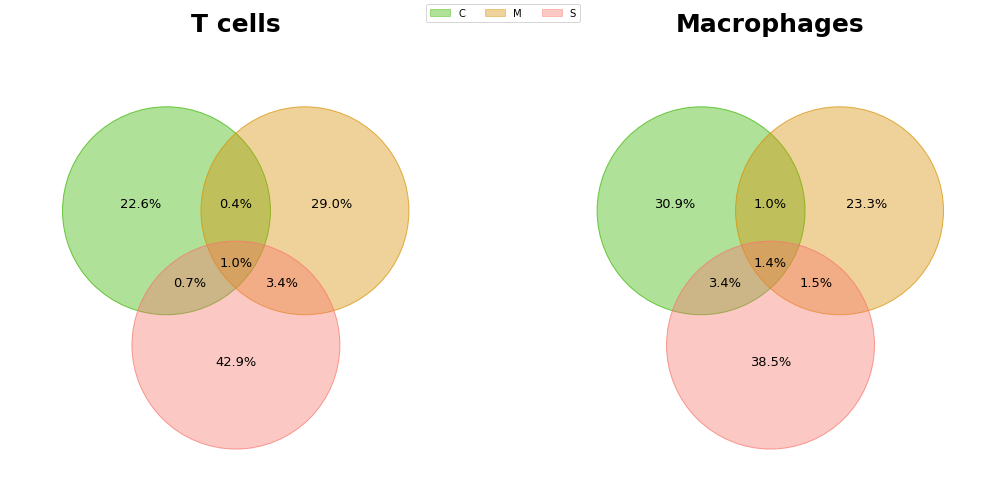

In [24]:
import matplotlib.patches as mpatches

top_n = 5
seed = 42
n_bins = 100
cell_types = ['T_cells', 'Macrophage']
types = ['C', 'M', 'S']
titles = {
    'T_cells': 'T cells',
    'Macrophage': 'Macrophages'
}
cmap = mpl.colors.ListedColormap([colors['green'], colors['yellow'], colors['red']])

adj_lists = {
    data: {
        t: get_adj_list(data, 'all', pat=t, get_filtered=filter_quantile) for t in types
    } for data in cell_types
}
fontsize = 25

f, ax = plt.subplots(1, 2, figsize=(15, 7))

for i, (data, curr_adj_lists) in enumerate(adj_lists.items()):

    plot_venn = venn if len(adj_lists) < 5 else pseudovenn
    
    plot_venn({
        t: set(zip(adj_list['TF'], adj_list['target'])) for t, adj_list in curr_adj_lists.items()
    }, fmt='{percentage:.1f}%', hint_hidden=False, ax=ax[i], cmap=cmap)
    ax[i].set_title(titles[data], fontsize=fontsize, fontweight='bold')
    
    ax[i].get_legend().remove()
    
f.legend(handles = [mpatches.Patch(color=c, label=t, alpha=0.4) for c, t in zip([colors['green'], colors['yellow'], colors['red']], types)], 
         ncol=3, loc='upper center')

plt.tight_layout()

plt.savefig('figs/all_network_edge_overlap.pdf', bbox_inches='tight')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


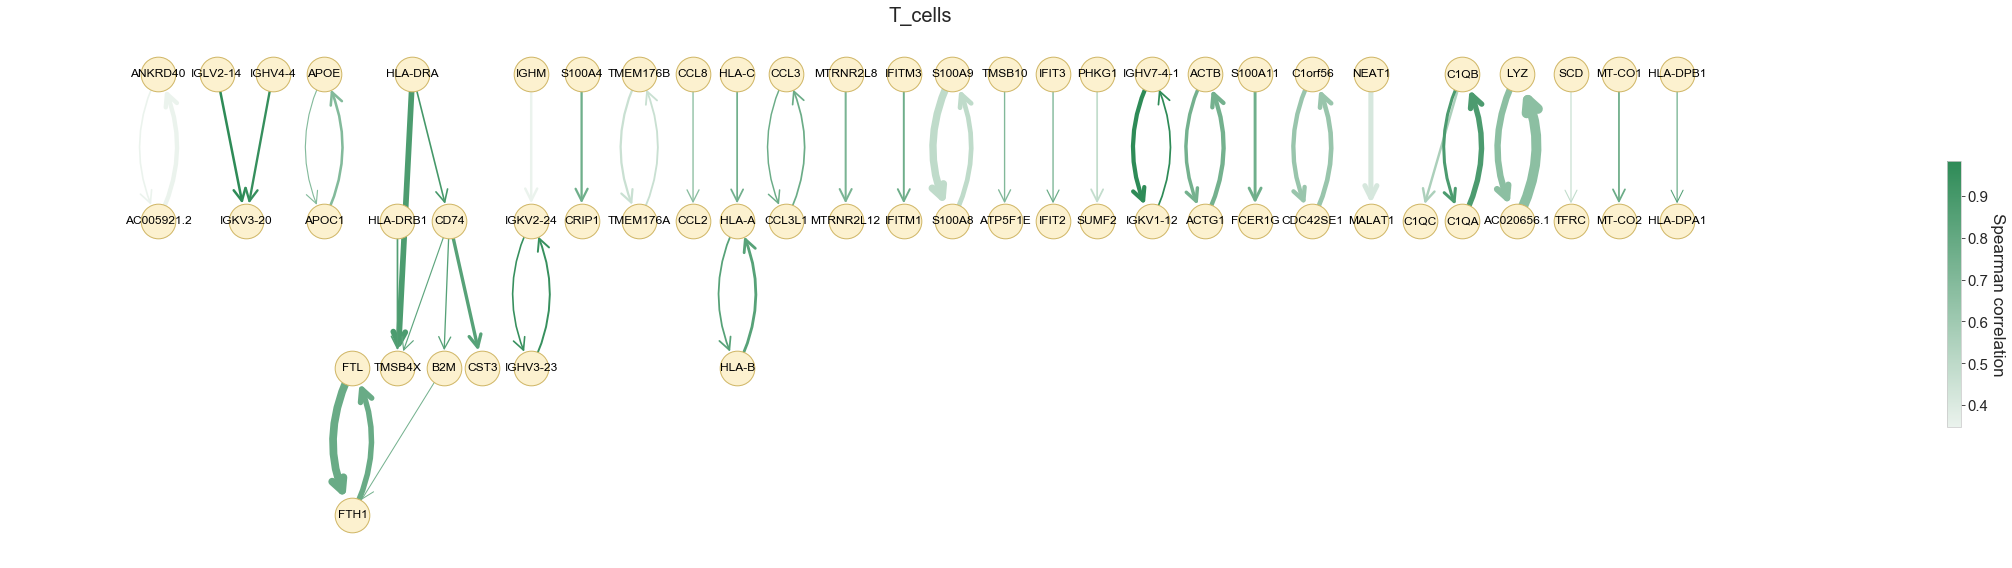

In [44]:
seed = 42
top_n = 50

cell_types = ['T_cells', 'Macrophage']
titles = {
    'T_cells': 'T cells',
    'Macrophage': 'Macrophages'
}

f, ax = plt.subplots(figsize=(32, 8))
cmap = sns.light_palette("seagreen", as_cmap=True)   
    
full_G = get_nx_graph(data, 'all', pat=None)

out_link_dict = {(st, end): info['importance'] for st, end, info in full_G.edges(data=True)}
out_dict_sorted = dict(sorted(out_link_dict.items(), key=lambda x: x[1], reverse=True)[:top_n])
edges = list(out_dict_sorted.keys())
G = full_G.edge_subgraph(edges)

label_edges = False
if_alpha_edges = False
alpha = 0.5
pos = nx.nx_agraph.pygraphviz_layout(G, prog="dot")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)

draw_graph(G, pos=pos, ax=ax, TF_names=TF_names, label_edges=label_edges, node_size=_NODE_SIZE, 
           if_alpha_edges=if_alpha_edges, cmap=cmap, plot_cmap=True)

ax.set_title('T_cells')

plt.tight_layout()
plt.savefig('figs/top_links.svg', bbox_inches='tight')

In [52]:
def dist_shape(data):
    
    types = ['C', 'M', 'S', 'all']
    
    # Getting adjacency lists
    adj_lists = {
        t: get_adj_list(data, data_type='ctx', pat=t) for t in types
    }
    
    # Adding _all, _C, _M, _S suffixes to each adjacency list
    adj_lists = {
        t: el.rename(
            columns={col: f'{col}_{t}' for col in el.columns if col not in ['TF', 'target']}
        ) for t, el in adj_lists.items()
    }

    # Finding TF regulons that are present in at least one adjacency list, filling NaN importances with 0
    merged = (
        reduce(
            lambda left, right: pd.merge(left, right, on=['TF', 'target'], how='outer'), 
            adj_lists.values()
        ).loc[lambda x: x['TF'] != x['target']]  # filtering out self-loopt
        .fillna(0)  # NaN -> 0
    )
    merged = merged[[col for col in merged if col.startswith('importance') or col in ['TF', 'target']]]  # keeping only importances

    # Plotting the distribution of edge importance
    f, ax = plt.subplots(figsize=(15, 7))
    sns.histplot(data=merged, kde=True, ax=ax)
    ax.set_title(f'The difference in distribution of edge importances {data}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Count')
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    
widget = interactive(
    dist_shape, 
    {'manual': True},
    data=['all_data', 'Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-']
)
display(widget)

interactive(children=(Dropdown(description='data', options=('all_data', 'Macrophage', 'T_cells', 'DC', 'Monocy…

## RELOAD DATA

In [ ]:
###### RELOAD DATA ######
import pandas as pd
import os

# Setting pathways to files
_PROJ_PATH = '/gpfs/projects/bsc08/bsc08890'
_FMETA = os.path.join(_PROJ_PATH, 'data/GSE145926_RAW/metadata.tsv')
_DATA_HOME = os.path.join(_PROJ_PATH, 'res/covid_19')

# Data types
_DATA_TYPES = ['all', 'TF', 'ctx']
_DTYPE_TITLES = ['gene-gene links', 'TF-gene links', 'enriched TF-gene links']

# Limiting the metadata to certain patients to fit into RAM
_FIXED_PATIENTS = ['C51', 'C52', 'C141', 'C142', 'C148', 'C149']
_FIXED_CELL_TYPES = ['T_cells', 'Macrophage', 'NK_cell', 'Monocyte']

# Loading sample meta data, reordering patients
full_meta = pd.read_csv(_FMETA, sep='\t', index_col=0)
full_meta = full_meta.reindex(index=_FIXED_PATIENTS + ['C100', 'C144', 'C143', 'C145', 'C146', 'C152'])

# Adding cell-type frequency to the metadat
for patient_id in full_meta.index:
    cells_metadata = pd.read_csv(os.path.join(_DATA_HOME, patient_id, 'data', 'Seurat', 'cells_metadata.tsv'), sep='\t')
    full_meta.loc[patient_id, 'num_cells'] = len(cells_metadata)
    for cell_type, cell_count in cells_metadata['cell_type'].value_counts().iteritems():
        full_meta.loc[patient_id, cell_type] = cell_count   
full_cell_type_freq = full_meta.iloc[:, 3:]

# Finding common cell types
_COMMON_CELL_TYPES = full_cell_type_freq.T.dropna().index.to_list()
_COMMON_FILE_PREFIXES = ['raw_data', 'raw_data_HVG'] + list(map(lambda x: 'raw_data_' + x, _COMMON_CELL_TYPES))

# Limiting the metadata to certain patients to fit into RAM
meta = full_meta.loc[_FIXED_PATIENTS, ['group', 'file', 'num_cells'] + _FIXED_CELL_TYPES]
cell_type_freq = full_cell_type_freq[_FIXED_CELL_TYPES]

# Getting information about all patients
_ALL_PATIENTS = full_meta.index.to_list()
_ALL_PATIENT_CELL_TYPES = {
    pat: full_cell_type_freq.loc[pat].dropna().index.to_list() for pat in _ALL_PATIENTS
}
_ALL_FILE_PREFIXES = {
    pat: ['raw_data'] + list(map(lambda x: 'raw_data_' + x, cell_types)) for pat, cell_types in _ALL_PATIENT_CELL_TYPES.items()
}
_ALL_TITLES = {
    pat: list(map(lambda x: 'all data' if x == 'raw_data' else 'all data, only HVGs' if 'HVG' in x else x.replace('raw_data_', '').replace('_', ' '), files)) 
    for pat, files in _ALL_FILE_PREFIXES.items()
}
_ALL_FIG_DIRS = {
    pat: os.path.join(_DATA_HOME, pat, 'figs/grnboost2') for pat in _ALL_PATIENTS
}
        
# Setting patient-specific params
_PATIENTS = meta.index.to_list()
_PATIENT_CELL_TYPES = {
    pat: cell_type_freq.loc[pat].dropna().index.to_list() for pat in _PATIENTS
}
_FILE_PREFIXES = {
    pat: ['raw_data'] + list(map(lambda x: 'raw_data_' + x, cell_types)) for pat, cell_types in _PATIENT_CELL_TYPES.items()
}
_TITLES = {
    pat: list(map(lambda x: 'all data' if x == 'raw_data' else 'all data, only HVGs' if 'HVG' in x else x.replace('raw_data_', '').replace('_', ' '), files)) 
    for pat, files in _FILE_PREFIXES.items()
}
_FIG_DIRS = {
    pat: os.path.join(_DATA_HOME, pat, 'figs/grnboost2') for pat in _PATIENTS
}



for pat in _ALL_PATIENTS:
    for fn in _ALL_FILE_PREFIXES[pat]:
        TF_cor = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{fn}_TF_cor.tsv')
        TF_ctx = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{fn}_TF_ctx.tsv')
        cor = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{fn}_cor.tsv')
        !python src/adj_list_to_process.py -f {TF_cor} -q 0.95
        !python src/adj_list_to_process.py -f {TF_ctx} -q 0.95
        !python src/adj_list_to_process.py -f {cor} -q 0.95

## ADDITIONAL MATERIALS

In [ ]:
for pat in _PATIENTS:
    print(colored(f'PATIENT: {pat} ({int(meta["num_cells"][pat])} cells)', 'cyan'))
    TF_strings, all_strings = [], []
    for fn, cell_dtype in zip(_FILE_PREFIXES[pat], ['all_data', 'HVG_data'] + _PATIENT_CELL_TYPES[pat]):
        TF_strings.append(colored(cell_dtype, 'green' if fn in _AVAILABLE_DATAS[pat]['TF'] else 'red'))
        all_strings.append(colored(cell_dtype, 'green' if fn in _AVAILABLE_DATAS[pat]['all'] else 'red'))
    print('TFs')
    print(', '.join(TF_strings))
    print('All genes')
    print(', '.join(all_strings))
    print()

#### GREASY TEMPLATES
##### PATIENT-SPECIFIC 

In [53]:
cyan_color = lambda x: colored(x, 'cyan')
red_color = lambda x: colored(x, 'red')

# Patients - 'C141', 'C142', 'C143', 'C144', 'C145', 'C146', 'C51', 'C52', 'C100', 'C148', 'C149', 'C152'
for patient in ['C141', 'C142', 'C143', 'C144', 'C145', 'C146', 'C51', 'C52', 'C100', 'C148', 'C149', 'C152']:
    #patient = 'C143'
    method = 'grnboost2'
    filter_quantile = 0.95
    data_types = list(map(lambda x: x.replace('raw_data', '') if x.replace('raw_data', '') else "''", _ALL_FILE_PREFIXES[patient]))
    cell_type_x = full_meta.loc[patient].drop(['file', 'group']).dropna()

    GBs_per_worker = 8 if cell_type_x['num_cells'] < 8000 else 16
    n_nodes = 4
    hours = 36

    cpus_per_worker = GBs_per_worker // 2
    cpus_per_task = cpus_per_worker * 4
    total_avail_cpus = n_nodes * 48
    n_tasks = total_avail_cpus // cpus_per_task
    num_workers_per_task = cpus_per_task // cpus_per_worker

    # n_tasks = 12
    # cpus_per_task = 12
    # hours = 24
    # num_workers_per_task = cpus_per_task // 3

    qos_debug = False
    qos_debug_cmd = f' {cyan_color("--qos")}=debug ' if qos_debug else ' '

    # display(pd.DataFrame(cell_type_x).T)

    # print(f"{red_color('sbatch')} {cyan_color('--job-name')}='GREASY_{method}_{patient}' {cyan_color('--output')}=./logs/GREASY_{method}_{patient}_%j.out "
    #       f"{cyan_color('--error')}=./logs/GREASY_{method}_{patient}_%j.err {cyan_color('--ntasks')}={n_tasks} {cyan_color('--time')}='{hours}:00:00' "
    #       f"{cyan_color('--cpus-per-task')}={cpus_per_task}{qos_debug_cmd}{red_color('greasy_run_pyscenic')} {patient}")

    print(f"{red_color('sbatch')} {cyan_color('--job-name')}='{patient}_GREASY_{method}' "
          f"{cyan_color('--ntasks')}={n_tasks} {cyan_color('--time')}='{hours}:00:00' "
          f"{cyan_color('--output')}=/dev/null {cyan_color('--error')}=/dev/null "
          f"{cyan_color('--cpus-per-task')}={cpus_per_task}{qos_debug_cmd}{red_color('greasy_run_pyscenic.sh')} {patient}")

    tasks = ''
    print()
    i = 1
    for d in data_types:
        # TF task
        task_1 = f"../run_pyscenic_full.sh {method} {patient} {d} /gpfs/projects/bsc08/bsc08890/data/TF_lists/lambert2018.txt {num_workers_per_task} GREASY {filter_quantile} {i}"
        # print(task_1)
        tasks += f'{task_1}\n'
        i += 1
    for d in data_types:
        # All genes task
        task_2 = f"../run_pyscenic_full.sh {method} {patient} {d} '' {num_workers_per_task} GREASY {filter_quantile} {i}"
        # print(task_2)
        i += 1
        tasks += f'{task_2}\n'

    tasks = tasks.strip()
    with open(f'/gpfs/projects/bsc08/bsc08890/sbatch/greasy/greasy_tasks_{patient}_{method}', 'w') as f:
        f.write(tasks)

sbatch --job-name='C141_GREASY_grnboost2' --ntasks=12 --time='36:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=16 greasy_run_pyscenic.sh C141

sbatch --job-name='C142_GREASY_grnboost2' --ntasks=12 --time='36:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=16 greasy_run_pyscenic.sh C142

sbatch --job-name='C143_GREASY_grnboost2' --ntasks=6 --time='36:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=32 greasy_run_pyscenic.sh C143

sbatch --job-name='C144_GREASY_grnboost2' --ntasks=12 --time='36:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=16 greasy_run_pyscenic.sh C144

sbatch --job-name='C145_GREASY_grnboost2' --ntasks=6 --time='36:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=32 greasy_run_pyscenic.sh C145

sbatch --job-name='C146_GREASY_grnboost2' --ntasks=12 --time='36:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=16 greasy_run_pyscenic.sh C146

sbatch --job-name='C51_GREASY_grnboost2' --ntasks=6 --time='

##### COMMUNITY ANALYSIS

In [27]:
cyan_color = lambda x: colored(x, 'cyan')
red_color = lambda x: colored(x, 'red')

# Patients - 'C141', 'C142', 'C143', 'C144', 'C145', 'C146', 'C51', 'C52', 'C100', 'C148', 'C149', 'C152'

for patient in ['C141', 'C142', 'C143', 'C144', 'C145', 'C146', 'C51', 'C52', 'C100', 'C148', 'C149', 'C152']:
    # patient = 'C152'
    algo = 'leiden'
    datas = _ALL_FILE_PREFIXES[patient]
    cell_type_x = full_meta.loc[patient].drop(['file', 'group']).dropna()

    n_tasks = len(datas) // 2  # Running only half of tasks in parallel
    cpus_per_task = 48
    hours = 24
    num_workers_per_task = cpus_per_task // 3

    qos_debug = False
    qos_debug_cmd = f' {cyan_color("--qos")}=debug ' if qos_debug else ' '

    # display(pd.DataFrame(cell_type_x).T)

    print(f"{red_color('sbatch')} {cyan_color('--job-name')}='{patient}_GREASY_community_ana_{algo}' "
          f"{cyan_color('--ntasks')}={n_tasks} {cyan_color('--time')}='{hours}:00:00' "
          f"{cyan_color('--output')}=/dev/null {cyan_color('--error')}=/dev/null "
          f"{cyan_color('--cpus-per-task')}={cpus_per_task}{qos_debug_cmd}{red_color('greasy_community_ana.sh')} {patient} {algo}")

    tasks = ''
    print()
    i = 1
    for d in datas:
        task = f"../community_ana.sh {patient} {d} {algo} GREASY {i}"
        # print(task)
        i += 1
        tasks += f'{task}\n'

    tasks = tasks.strip()
    with open(f'/gpfs/projects/bsc08/bsc08890/sbatch/greasy/greasy_tasks_community_ana_{patient}_{algo}', 'w') as f:
        f.write(tasks)

sbatch --job-name='C141_GREASY_community_ana_leiden' --ntasks=6 --time='24:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=48 greasy_community_ana.sh C141 leiden

sbatch --job-name='C142_GREASY_community_ana_leiden' --ntasks=7 --time='24:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=48 greasy_community_ana.sh C142 leiden

sbatch --job-name='C143_GREASY_community_ana_leiden' --ntasks=8 --time='24:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=48 greasy_community_ana.sh C143 leiden

sbatch --job-name='C144_GREASY_community_ana_leiden' --ntasks=7 --time='24:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=48 greasy_community_ana.sh C144 leiden

sbatch --job-name='C145_GREASY_community_ana_leiden' --ntasks=6 --time='24:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=48 greasy_community_ana.sh C145 leiden

sbatch --job-name='C146_GREASY_community_ana_leiden' --ntasks=7 --time='24:00:00' --output=/dev/null --error=/dev/null --cpus

#### SBATCH TEMPLATES
##### PATIENT-SPECIFIC

In [55]:
cyan_color = lambda x: colored(x, 'cyan')
red_color = lambda x: colored(x, 'red')

# Patients - 'C141', 'C142', 'C143', 'C144', 'C145', 'C146', 'C51', 'C52', 'C100', 'C148', 'C149', 'C152'

patient = 'C145'
method = 'grnboost2'
filter_quantile = 0.95
data_types = list(map(lambda x: x.replace('raw_data', '') if x.replace('raw_data', '') else "''", _ALL_FILE_PREFIXES[patient]))
# cell_type_x = meta.loc[patient].drop(['file', 'group']).dropna()

# GBs_per_worker = 8 if cell_type_x['num_cells'] < 8000 else 12
# increase_cpus_by = 4
# n_nodes = 1
# hours = 40

# cpus_per_worker = GBs_per_worker // 2
# cpus_per_task = cpus_per_worker * increase_cpus_by
# total_avail_cpus = n_nodes * 48
# num_workers_per_task = cpus_per_task // cpus_per_worker

# qos_debug = False
# qos_debug_cmd = f' {cyan_color("--qos")}=debug ' if qos_debug else ' '

hours = 40
cpus_per_task = 48
num_workers_per_task = 8
high_mem = True if full_meta.loc[patient, 'num_cells'] > 10000 else False
high_mem_cmd = f' {cyan_color("--constraint")}=highmem ' if high_mem else ' '
qos_debug = False
qos_debug_cmd = f' {cyan_color("--qos")}=debug ' if qos_debug else ' '

display(pd.DataFrame(cell_type_freq.loc[patient].dropna()).T)

for d in data_types:
    print(f"{red_color('sbatch')} {cyan_color('--time')}='{hours}:00:00'{qos_debug_cmd}{high_mem_cmd}{cyan_color('--cpus-per-task')}={cpus_per_task} "
          f"{cyan_color('--job-name')}='{patient}_{d}_TF_{method}' {cyan_color('--workdir')}=. {cyan_color('--ntasks')}=1 "
          f"{cyan_color('--output')}=/dev/null {cyan_color('--error')}=/dev/null "
          f"{red_color('run_pyscenic_full.sh')} {method} {patient} {d} /gpfs/projects/bsc08/bsc08890/data/TF_lists/lambert2018.txt {num_workers_per_task} SBATCH {filter_quantile}")
print()
for d in data_types:
    print(f"{red_color('sbatch')} {cyan_color('--time')}='{hours}:00:00'{qos_debug_cmd}{high_mem_cmd}{cyan_color('--cpus-per-task')}={cpus_per_task} "
          f"{cyan_color('--job-name')}='{patient}_{d}_{method}' {cyan_color('--workdir')}=. {cyan_color('--ntasks')}=1 "
          f"{cyan_color('--output')}=/dev/null {cyan_color('--error')}=/dev/null "
          f"{red_color('run_pyscenic_full.sh')} {method} {patient} {d} '' {num_workers_per_task} SBATCH {filter_quantile}")

,T_cells,Macrophage,NK_cell,Monocyte
C145,719.0,6960.0,421.0,5616.0


sbatch --time='40:00:00'  --constraint=highmem --cpus-per-task=48 --job-name='C145_''_TF_grnboost2' --workdir=. --ntasks=1 --output=/dev/null --error=/dev/null run_pyscenic_full.sh grnboost2 C145 '' /gpfs/projects/bsc08/bsc08890/data/TF_lists/lambert2018.txt 8 SBATCH 0.95
sbatch --time='40:00:00'  --constraint=highmem --cpus-per-task=48 --job-name='C145__Macrophage_TF_grnboost2' --workdir=. --ntasks=1 --output=/dev/null --error=/dev/null run_pyscenic_full.sh grnboost2 C145 _Macrophage /gpfs/projects/bsc08/bsc08890/data/TF_lists/lambert2018.txt 8 SBATCH 0.95
sbatch --time='40:00:00'  --constraint=highmem --cpus-per-task=48 --job-name='C145__T_cells_TF_grnboost2' --workdir=. --ntasks=1 --output=/dev/null --error=/dev/null run_pyscenic_full.sh grnboost2 C145 _T_cells /gpfs/projects/bsc08/bsc08890/data/TF_lists/lambert2018.txt 8 SBATCH 0.95
sbatch --time='40:00:00'  --constraint=highmem --cpus-per-task=48 --job-name='C145__DC_TF_grnboost2' --workdir=. --ntasks=1 --output=/dev/null --error=

##### CELL TYPES AGGREGATED

In [10]:
cyan_color = lambda x: colored(x, 'cyan')
red_color = lambda x: colored(x, 'red')

method = 'grnboost2'
cell_types = ['all_data'] + list(full_meta.columns[3:])
data_sizes = list(full_meta.sum()[2:])
filter_quantile = 0.95

display(full_cell_type_freq.sum().sort_values(ascending=False))

i = 1

for cell_type, data_size in zip(cell_types, data_sizes):
    for integ_type in ['raw', 'corrected']:
    
        hours = 48 if data_size > 8000 else 24
        cpus_per_task = 48 if data_size > 8000 else 24
        num_workers_per_task = 12
        high_mem = True if data_size > 10000 else False
        high_mem_cmd = f' {cyan_color("--constraint")}=highmem ' if high_mem else ' '
        qos_debug = False
        qos_debug_cmd = f' {cyan_color("--qos")}=debug ' if qos_debug else ' '
        hours = 2 if qos_debug else hours

        print(f"{red_color('sbatch')} {cyan_color('--time')}='{hours}:00:00'{qos_debug_cmd}{high_mem_cmd}{cyan_color('--cpus-per-task')}={cpus_per_task} "
              f"{cyan_color('--job-name')}='{cell_type}_TF_{method}' {cyan_color('--workdir')}=. {cyan_color('--ntasks')}=1 "
              f"{cyan_color('--output')}=/dev/null {cyan_color('--error')}=/dev/null "
              f"{red_color('run_pyscenic_full_cell_type.sh')} {method} {cell_type} /gpfs/projects/bsc08/bsc08890/data/TF_lists/lambert2018.txt {integ_type} {num_workers_per_task} SBATCH {filter_quantile} {i}")
        i += 1
        print(f"{red_color('sbatch')} {cyan_color('--time')}='{hours}:00:00'{qos_debug_cmd}{high_mem_cmd}{cyan_color('--cpus-per-task')}={cpus_per_task} "
              f"{cyan_color('--job-name')}='{cell_type}_{method}' {cyan_color('--workdir')}=. {cyan_color('--ntasks')}=1 "
              f"{cyan_color('--output')}=/dev/null {cyan_color('--error')}=/dev/null "
              f"{red_color('run_pyscenic_full_cell_type.sh')} {method} {cell_type} '' {integ_type} {num_workers_per_task} SBATCH {filter_quantile} {i}")
        i += 1
    print()

Macrophage             27418.0
Monocyte               15630.0
T_cells                 6403.0
Neutrophils             5638.0
DC                      1585.0
NK_cell                 1481.0
Epithelial_cells        1242.0
B_cell                   591.0
Pre-B_cell_CD34-         384.0
HSC_-G-CSF                61.0
Pro-B_cell_CD34+          45.0
GMP                       20.0
CMP                       16.0
BM                        14.0
Gametocytes                4.0
Erythroblast               2.0
Fibroblasts                2.0
Neurons                    1.0
Smooth_muscle_cells        1.0
Hepatocytes                1.0
Keratinocytes              1.0
Pro-Myelocyte              1.0
dtype: float64

sbatch --time='48:00:00'  --constraint=highmem --cpus-per-task=48 --job-name='all_data_TF_grnboost2' --workdir=. --ntasks=1 --output=/dev/null --error=/dev/null run_pyscenic_full_cell_type.sh grnboost2 all_data /gpfs/projects/bsc08/bsc08890/data/TF_lists/lambert2018.txt raw 12 SBATCH 0.95 1
sbatch --time='48:00:00'  --constraint=highmem --cpus-per-task=48 --job-name='all_data_grnboost2' --workdir=. --ntasks=1 --output=/dev/null --error=/dev/null run_pyscenic_full_cell_type.sh grnboost2 all_data '' raw 12 SBATCH 0.95 2
sbatch --time='48:00:00'  --constraint=highmem --cpus-per-task=48 --job-name='all_data_TF_grnboost2' --workdir=. --ntasks=1 --output=/dev/null --error=/dev/null run_pyscenic_full_cell_type.sh grnboost2 all_data /gpfs/projects/bsc08/bsc08890/data/TF_lists/lambert2018.txt corrected 12 SBATCH 0.95 3
sbatch --time='48:00:00'  --constraint=highmem --cpus-per-task=48 --job-name='all_data_grnboost2' --workdir=. --ntasks=1 --output=/dev/null --error=/dev/null run_pyscenic_full_ce

##### CELL TYPES (ONE PATIENT TYPE) AGGREGATED

In [11]:
cyan_color = lambda x: colored(x, 'cyan')
red_color = lambda x: colored(x, 'red')

method = 'grnboost2'
cell_types = ['all_data', 'Macrophage', 'T_cells', 'DC', 'Monocyte', 'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 'Pre-B_cell_CD34-']
data_sizes = list(full_meta.sum()[2:])
filter_quantile = 0.95

display(full_cell_type_freq.sum().sort_values(ascending=False))

i = 1

for cell_type, data_size in zip(cell_types, data_sizes):
    for t in ['C', 'M', 'S']:
        for integ_type in ['raw']:

            hours = 48 if data_size > 8000 else 40
            cpus_per_task = 48 if data_size > 8000 else 36
            num_workers_per_task = 12
            high_mem = True if data_size > 10000 else False
            high_mem_cmd = f' {cyan_color("--constraint")}=highmem ' if high_mem else ' '
            qos_debug = False
            qos_debug_cmd = f' {cyan_color("--qos")}=debug ' if qos_debug else ' '
            hours = 2 if qos_debug else hours

            print(f"{red_color('sbatch')} {cyan_color('--time')}='{hours}:00:00'{qos_debug_cmd}{high_mem_cmd}{cyan_color('--cpus-per-task')}={cpus_per_task} "
                  f"{cyan_color('--job-name')}='{cell_type}_{t}_type_TF_{method}' {cyan_color('--workdir')}=. {cyan_color('--ntasks')}=1 "
                  f"{cyan_color('--output')}=/dev/null {cyan_color('--error')}=/dev/null "
                  f"{red_color('run_pyscenic_full_cell_type_agg.sh')} {method} {cell_type} /gpfs/projects/bsc08/bsc08890/data/TF_lists/lambert2018.txt {integ_type} {t} {num_workers_per_task} SBATCH {filter_quantile} {i}")
            i += 1
            print(f"{red_color('sbatch')} {cyan_color('--time')}='{hours}:00:00'{qos_debug_cmd}{high_mem_cmd}{cyan_color('--cpus-per-task')}={cpus_per_task} "
                  f"{cyan_color('--job-name')}='{cell_type}_{t}_type_{method}' {cyan_color('--workdir')}=. {cyan_color('--ntasks')}=1 "
                  f"{cyan_color('--output')}=/dev/null {cyan_color('--error')}=/dev/null "
                  f"{red_color('run_pyscenic_full_cell_type_agg.sh')} {method} {cell_type} '' {integ_type} {t} {num_workers_per_task} SBATCH {filter_quantile} {i}")
            i += 1
    print()

Macrophage             27418.0
Monocyte               15630.0
T_cells                 6403.0
Neutrophils             5638.0
DC                      1585.0
NK_cell                 1481.0
Epithelial_cells        1242.0
B_cell                   591.0
Pre-B_cell_CD34-         384.0
HSC_-G-CSF                61.0
Pro-B_cell_CD34+          45.0
GMP                       20.0
CMP                       16.0
BM                        14.0
Gametocytes                4.0
Erythroblast               2.0
Fibroblasts                2.0
Neurons                    1.0
Smooth_muscle_cells        1.0
Hepatocytes                1.0
Keratinocytes              1.0
Pro-Myelocyte              1.0
dtype: float64

sbatch --time='48:00:00'  --constraint=highmem --cpus-per-task=48 --job-name='all_data_C_type_TF_grnboost2' --workdir=. --ntasks=1 --output=/dev/null --error=/dev/null run_pyscenic_full_cell_type_agg.sh grnboost2 all_data /gpfs/projects/bsc08/bsc08890/data/TF_lists/lambert2018.txt raw C 12 SBATCH 0.95 1
sbatch --time='48:00:00'  --constraint=highmem --cpus-per-task=48 --job-name='all_data_C_type_grnboost2' --workdir=. --ntasks=1 --output=/dev/null --error=/dev/null run_pyscenic_full_cell_type_agg.sh grnboost2 all_data '' raw C 12 SBATCH 0.95 2
sbatch --time='48:00:00'  --constraint=highmem --cpus-per-task=48 --job-name='all_data_M_type_TF_grnboost2' --workdir=. --ntasks=1 --output=/dev/null --error=/dev/null run_pyscenic_full_cell_type_agg.sh grnboost2 all_data /gpfs/projects/bsc08/bsc08890/data/TF_lists/lambert2018.txt raw M 12 SBATCH 0.95 3
sbatch --time='48:00:00'  --constraint=highmem --cpus-per-task=48 --job-name='all_data_M_type_grnboost2' --workdir=. --ntasks=1 --output=/dev/nul

##### COMMUNITY ANALYSIS CELL TYPES AGGREGATED

In [28]:
cyan_color = lambda x: colored(x, 'cyan')
red_color = lambda x: colored(x, 'red')

algo = 'leiden'
cell_types = ['all_data'] + list(full_meta.columns[3:])
datas = list(map(lambda x: 'raw_data' if x == 'all_data' else f'raw_data_{x}', cell_types))
filter_quantile = 0.95

display(full_cell_type_freq.sum().sort_values(ascending=False))

i = 1

for d, cell_type in zip(datas, cell_types):    
    n_tasks = len(datas) // 2  # Running only half of tasks in parallel
    cpus_per_task = 24
    hours = 12

    qos_debug = False
    qos_debug_cmd = f' {cyan_color("--qos")}=debug ' if qos_debug else ' '

    print(f"{red_color('sbatch')} {cyan_color('--job-name')}='{cell_type}_community_ana_{algo}' "
          f"{cyan_color('--ntasks')}=1 {cyan_color('--time')}='{hours}:00:00' "
          f"{cyan_color('--output')}=/dev/null {cyan_color('--error')}=/dev/null "
          f"{cyan_color('--cpus-per-task')}={cpus_per_task}{qos_debug_cmd}{red_color('community_ana_cell_type.sh')} {d} {algo}")
    i += 1

Macrophage             27418.0
Monocyte               15630.0
T_cells                 6403.0
Neutrophils             5638.0
DC                      1585.0
NK_cell                 1481.0
Epithelial_cells        1242.0
B_cell                   591.0
Pre-B_cell_CD34-         384.0
HSC_-G-CSF                61.0
Pro-B_cell_CD34+          45.0
GMP                       20.0
CMP                       16.0
BM                        14.0
Gametocytes                4.0
Erythroblast               2.0
Fibroblasts                2.0
Neurons                    1.0
Smooth_muscle_cells        1.0
Hepatocytes                1.0
Keratinocytes              1.0
Pro-Myelocyte              1.0
dtype: float64

sbatch --job-name='all_data_community_ana_leiden' --ntasks=1 --time='12:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=24 community_ana_cell_type.sh raw_data leiden
sbatch --job-name='Macrophage_community_ana_leiden' --ntasks=1 --time='12:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=24 community_ana_cell_type.sh raw_data_Macrophage leiden
sbatch --job-name='T_cells_community_ana_leiden' --ntasks=1 --time='12:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=24 community_ana_cell_type.sh raw_data_T_cells leiden
sbatch --job-name='DC_community_ana_leiden' --ntasks=1 --time='12:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=24 community_ana_cell_type.sh raw_data_DC leiden
sbatch --job-name='Pre-B_cell_CD34-_community_ana_leiden' --ntasks=1 --time='12:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=24 community_ana_cell_type.sh raw_data_Pre-B_cell_CD34- leiden
sbatch --job-name='Monocyte_community_ana_leiden' --ntasks=1 --time=

##### COMMUNITY ANALYSIS CELL TYPES (ONE PATIENT TYPE) AGGREGATED

In [29]:
cyan_color = lambda x: colored(x, 'cyan')
red_color = lambda x: colored(x, 'red')

method = 'leiden'
cell_types = ['all_data', 'Macrophage', 'T_cells', 'DC', 'Monocyte', 'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 'Pre-B_cell_CD34-']
datas = list(map(lambda x: 'raw_data' if x == 'all_data' else f'raw_data_{x}', cell_types))
filter_quantile = 0.95

display(full_cell_type_freq.sum().sort_values(ascending=False)[cell_types[1:]])

i = 1

for d, cell_type in zip(datas, cell_types):   
    for t in ['C', 'M', 'S']:
        n_tasks = len(datas) // 2  # Running only half of tasks in parallel
        cpus_per_task = 24
        hours = 12

        qos_debug = False
        qos_debug_cmd = f' {cyan_color("--qos")}=debug ' if qos_debug else ' '

        print(f"{red_color('sbatch')} {cyan_color('--job-name')}='{cell_type}_{t}_type_community_ana_{algo}' "
              f"{cyan_color('--ntasks')}=1 {cyan_color('--time')}='{hours}:00:00' "
              f"{cyan_color('--output')}=/dev/null {cyan_color('--error')}=/dev/null "
              f"{cyan_color('--cpus-per-task')}={cpus_per_task}{qos_debug_cmd}{red_color('community_ana.sh')} {t} {d} {algo}")
        i += 1

Macrophage          27418.0
T_cells              6403.0
DC                   1585.0
Monocyte            15630.0
NK_cell              1481.0
B_cell                591.0
Epithelial_cells     1242.0
Neutrophils          5638.0
Pre-B_cell_CD34-      384.0
dtype: float64

sbatch --job-name='all_data_C_type_community_ana_leiden' --ntasks=1 --time='12:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=24 community_ana.sh C raw_data leiden
sbatch --job-name='all_data_M_type_community_ana_leiden' --ntasks=1 --time='12:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=24 community_ana.sh M raw_data leiden
sbatch --job-name='all_data_S_type_community_ana_leiden' --ntasks=1 --time='12:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=24 community_ana.sh S raw_data leiden
sbatch --job-name='Macrophage_C_type_community_ana_leiden' --ntasks=1 --time='12:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=24 community_ana.sh C raw_data_Macrophage leiden
sbatch --job-name='Macrophage_M_type_community_ana_leiden' --ntasks=1 --time='12:00:00' --output=/dev/null --error=/dev/null --cpus-per-task=24 community_ana.sh M raw_data_Macrophage leiden
sbatch --job-name='Macrophage_S_type_community_ana_leiden' --ntasks=1 --time='12:00:00' -

#### OTHER

In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
df = full_meta.T.iloc[3:,:]
for col in df.columns:
    df[col] = df[col].astype('float')
df = df[['C51', 'C52', 'C100', 'C141', 'C142', 'C144', 'C143', 'C145', 'C146', 'C148', 'C149', 'C152']]
g = sns.heatmap(df, vmin=0, annot=True, fmt='.0f', cmap='crest')
for tick_label in g.axes.get_xticklabels():
    if full_meta['group'][tick_label.get_text()] == 'S':
        tick_label.set_color("red")
    elif full_meta['group'][tick_label.get_text()] == 'M':
        tick_label.set_color(np.array((255, 212, 103)) / 255)
    else:
        tick_label.set_color('green')
g.axes.set_xlabel('')
plt.savefig('figs/cell_pop_dist.png', dpi=200, bbox_inches='tight')

NameError: name 'grnboost2_net' is not defined

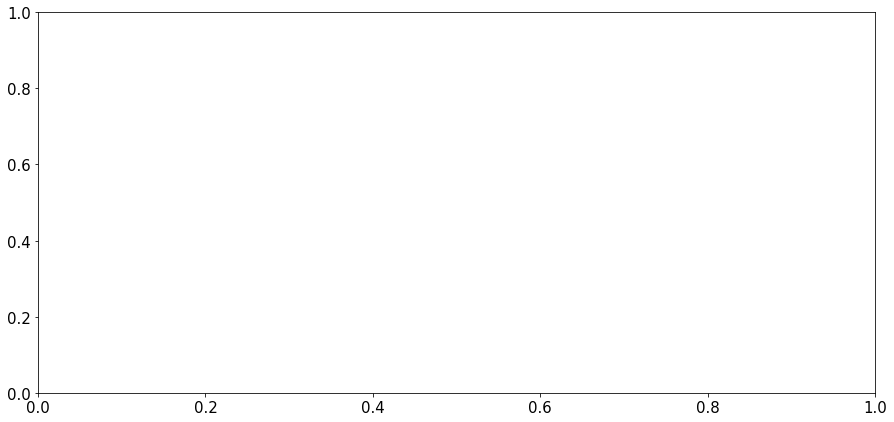

In [17]:
# Plotting gene-gene link importance distribution
f, ax = plt.subplots(figsize=(15, 7))

grnboost2_net.importance.plot(ax=ax, bins=100, kind='hist', logy=True)
ax.set_title('GRNBoost2-inferred gene-gene connection importance')

ax.set_xlabel('Gene-gene connection importance');

We will now plot only edges with `importance > 20`.

In [ ]:
_THRESH = 40

# Getting a weighted adjacency matrix
adj_mat = pd.pivot_table(grnboost2_net, values='importance', index=['TF'], columns=['target'])
n_genes = adj_mat.shape[0]

# Filling NaN as zero (no edge)
adj_mat = adj_mat.fillna(0)

# Setting diagonal to zero (self loops)
adj_mat.values[[np.arange(adj_mat.shape[0])]*2] = 0

# Filling edges' weights as zero if below threshold
adj_mat[adj_mat < _THRESH] = 0

# Removing nodes (or nodes) with zeros everywhere
zero_rows, zero_cols = set(adj_mat.loc[(adj_mat==0).all(axis=1)].index), set(adj_mat.loc[:, (adj_mat==0).all(axis=0)].columns)
zero_genes = zero_rows.intersection(zero_cols)
adj_mat = adj_mat.drop(zero_genes, axis=1).drop(zero_genes, axis=0)

# Reording dataframe
adj_mat = adj_mat[adj_mat.index]

print(f'Initially we had {n_genes} genes, now after filtering we have {adj_mat.shape[0]} genes..')

adj_mat

Now we can have a look at how the gene graph of connections looks like.

In [ ]:
# Creating a graph
G = nx.convert_matrix.from_pandas_adjacency(adj_mat, create_using=nx.DiGraph)
pos = nx.spring_layout(G, seed=100, k=0.7)

f, ax = plt.subplots(figsize=(15, 15))

edge_weights = [w_dict['weight'] for st, end, w_dict in G.edges(data=True)]
alpha_weights = [(w - min(edge_weights))/(max(edge_weights) - min(edge_weights))*0.5 + 0.5 for w in edge_weights]

edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

nodes = nx.draw_networkx_nodes(G, pos, with_labels=True, node_color='pink', ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)
edges = nx.draw_networkx_edges(
    G, pos, connectionstyle='arc3, rad = 0.1',
    ax=ax, edgelist=edges, edge_color=weights, edge_cmap=plt.cm.winter
)

# set alpha value for each edge
for i in range(len(alpha_weights)):
    edges[i].set_alpha(alpha_weights[i])
    
if False:
    plt.savefig('res/PilotWorkflow/figs/grnboost2_40_thresh_net.png', dpi=200)

In [ ]:
q = pd.read_csv('~/res/PilotWorkflow/data/Seurat/raw_data_HVG.tsv', sep='\t')
q

In [ ]:
EXP_MTX_QC_FNAME = 'res/PilotWorkflow/data/Seurat/raw_data_HVG.tsv'
HUMAN_TFS_FNAME = 'data/TF_lists/lambert2018.txt'
ADJACENCIES_FNAME = 'res/PilotWorkflow/data/grnboost2_res.tsv'
ADJACENCIES_COR_FNAME = 'res/PilotWorkflow/data/grnboost2_res_cor.tsv'
!pyscenic grn {EXP_MTX_QC_FNAME} {HUMAN_TFS_FNAME} -o {ADJACENCIES_FNAME} --num_workers 18 --transpose

In [ ]:
!pyscenic add_cor {ADJACENCIES_FNAME} {EXP_MTX_QC_FNAME} --output {ADJACENCIES_COR_FNAME} --transpose

In [ ]:
import pandas as pd
q = pd.read_csv('res/PilotWorkflow/data/grnboost2/raw_data_HVG_ctx.tsv', sep='\t')

In [ ]:
%%time

_PRINT_LOGS = True

def get_tf_targ_ctx(df):
    tf_target_dict = {'TF': [], 'target': [], 'importance': []}
    tf_target_info = (
        df.droplevel(axis=0, level=1).droplevel(axis=1, level=0)['TargetGenes']
          .map(set)  # transform each list into set
          .groupby('TF').agg(lambda x: reduce(lambda a, b: a.union(b), x))  # combine all targets per TF
    )
    for tf, target_info in tf_target_info.iteritems():
        tf_target_dict['TF'] += [tf for target_name, score in target_info]
        tf_target_dict['target'] += [target_name for target_name, score in target_info]
        tf_target_dict['importance'] += [score for target_name, score in target_info]
    return pd.DataFrame(tf_target_dict)


_AVAILABLE_DATAS = {}
grnboost2_meta = {}
p_bar = tqdm(_PATIENTS)

for pat in p_bar:
    p_bar.set_description(f'{pat} patient')
    grnboost2_meta[pat] = {}
    _AVAILABLE_DATAS[pat] = {}
    _AVAILABLE_DATAS[pat]['TF'] = []
    _AVAILABLE_DATAS[pat]['ctx'] = []
    _AVAILABLE_DATAS[pat]['all'] = []
    for fn in _FILE_PREFIXES[pat]:
        try:
            input_TF = pd.read_csv(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{fn}_TF_cor.tsv'), sep='\t')
            ctx = pd.read_pickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{fn}_TF_ctx.pickle'))
            input_ctx = get_tf_targ_ctx(ctx).merge(input_TF, how='left')
            _AVAILABLE_DATAS[pat]['TF'].append(fn)
            _AVAILABLE_DATAS[pat]['ctx'].append(fn)
        except (FileNotFoundError, pd.errors.EmptyDataError):
            input_TF = None
            ctx = None
            input_ctx = None
        try:
            input_all = pd.read_csv(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{fn}_cor.tsv'), sep='\t')
            _AVAILABLE_DATAS[pat]['all'].append(fn)
        except (FileNotFoundError, pd.errors.EmptyDataError):
            input_all = None
        grnboost2_meta[pat][fn] = {
        'input_TF': input_TF,
        'input_all': input_all, 
        'filtered_TF': None,
        'filtered_all': None,
        'graph_TF': None,
        'graph_all': None,
        'full_graph_TF': None,
        'full_graph_all': None,
        'ctx': ctx, 
        'input_ctx': input_ctx,
        'filtered_ctx': None,
        'graph': None,
        'full_graph_ctx': None
        }

if _PRINT_LOGS:
    for pat in _PATIENTS:
        print(colored(f'PATIENT: {pat}', 'cyan'))
        TF_strings, all_strings = [], []
        for fn, cell_dtype in zip(_FILE_PREFIXES[pat], ['all_data', 'HVG_data'] + _PATIENT_CELL_TYPES[pat]):
            TF_strings.append(colored(cell_dtype, 'green' if fn in _AVAILABLE_DATAS[pat]['TF'] else 'red'))
            all_strings.append(colored(cell_dtype, 'green' if fn in _AVAILABLE_DATAS[pat]['all'] else 'red'))
        print('TFs')
        print(', '.join(TF_strings))
        print('All genes')
        print(', '.join(all_strings))
        print()
    

print('The first 2 rows of GRNBoost2 output as an example (based on all genes and all cells)..')
display(grnboost2_meta[_PATIENTS[0]]['raw_data']['input_all'].head(2))
print('After processing of ctx output..')
display(grnboost2_meta[_PATIENTS[0]]['raw_data']['input_ctx'].head(2))

In [ ]:
def data_process(i):
    _AVAILABLE_DATAS = {}
    grnboost2_meta = {}
    p_bar = tqdm(_PATIENTS[:i])

    for pat in p_bar:
        p_bar.set_description(f'{pat} patient')
        grnboost2_meta[pat] = {}
        _AVAILABLE_DATAS[pat] = {}
        _AVAILABLE_DATAS[pat]['TF'] = []
        _AVAILABLE_DATAS[pat]['ctx'] = []
        _AVAILABLE_DATAS[pat]['all'] = []
        for fn in _FILE_PREFIXES[pat]:
            try:
                input_TF = pd.read_csv(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{fn}_TF_cor.tsv'), sep='\t')
                ctx = pd.read_pickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{fn}_TF_ctx.pickle'))
                input_ctx = get_tf_targ_ctx(ctx).merge(input_TF, how='left')
                _AVAILABLE_DATAS[pat]['TF'].append(fn)
                _AVAILABLE_DATAS[pat]['ctx'].append(fn)
            except:
                input_TF = None
                ctx = None
                input_ctx = None
            try:
                input_all = pd.read_csv(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{fn}_cor.tsv'), sep='\t')
                _AVAILABLE_DATAS[pat]['all'].append(fn)
            except:
                input_all = None
            grnboost2_meta[pat][fn] = {'input_TF': input_TF, 'input_all': input_all, 'filtered_TF': None,'filtered_all': None,'graph_TF': None,'graph_all': None,'full_graph_TF': None,'full_graph_all': None,'ctx': ctx, 'input_ctx': input_ctx,'filtered_ctx': None,'graph': None,'full_graph_ctx': None}

In [ ]:
%lprun -f data_process data_process(3)

In [ ]:
for pat in _PATIENTS:
    for fn in _FILE_PREFIXES[pat]:
        full_fn = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{fn}_cor.tsv')
        !python src/grn_file_to_pickle.py -f {full_fn} >> /dev/null
        full_fn = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{fn}_TF_cor.tsv')
        !python src/grn_file_to_pickle.py -f {full_fn} >> /dev/null
        full_fn = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{fn}_TF_ctx.tsv')
        !python src/grn_file_to_pickle.py -f {full_fn} >> /dev/null

In [ ]:
%%time
filter_quantile = 0.8
print(colored(f'CHOSEN QUANTILE THRESHOLD: {filter_quantile}', 'green'))
for pat in _PATIENTS:
    print(colored(f'PATIENT: {pat}', 'cyan'))
    for data in _FILE_PREFIXES[pat]:
        try:
            print(colored(data.upper(), 'magenta'))
            # TF
            thresh = grnboost2_meta[pat][data]['input_TF']['importance'].quantile(filter_quantile)
            grnboost2_meta[pat][data]['filtered_TF'] = grnboost2_meta[pat][data]['input_TF'].loc[lambda x: x.importance > thresh]
            grnboost2_meta[pat][data]['graph_TF'] = nx.from_pandas_edgelist(grnboost2_meta[pat][data]['filtered_TF'], 'TF', 'target', ['importance', 'rho'], create_using=nx.DiGraph)
            grnboost2_meta[pat][data]['full_graph_TF'] = nx.from_pandas_edgelist(grnboost2_meta[pat][data]['input_TF'], 'TF', 'target', ['importance', 'rho'], create_using=nx.DiGraph)
            # all
            thresh = grnboost2_meta[pat][data]['input_all']['importance'].quantile(filter_quantile)
            grnboost2_meta[pat][data]['filtered_all'] = grnboost2_meta[pat][data]['input_all'].loc[lambda x: x.importance > thresh]
            grnboost2_meta[pat][data]['graph_all'] = nx.from_pandas_edgelist(grnboost2_meta[pat][data]['filtered_all'], 'TF', 'target', ['importance', 'rho'], create_using=nx.DiGraph)
            grnboost2_meta[pat][data]['full_graph_all'] = nx.from_pandas_edgelist(grnboost2_meta[pat][data]['input_all'], 'TF', 'target', ['importance', 'rho'], create_using=nx.DiGraph)
            # ctx
            thresh = grnboost2_meta[pat][data]['input_ctx']['importance'].quantile(filter_quantile)
            grnboost2_meta[pat][data]['filtered_ctx'] = grnboost2_meta[pat][data]['input_ctx'].loc[lambda x: x.importance > thresh]
            grnboost2_meta[pat][data]['graph_ctx'] = nx.from_pandas_edgelist(grnboost2_meta[pat][data]['filtered_ctx'], 'TF', 'target', ['importance', 'rho'], create_using=nx.DiGraph)
            grnboost2_meta[pat][data]['full_graph_ctx'] = nx.from_pandas_edgelist(grnboost2_meta[pat][data]['input_ctx'], 'TF', 'target', ['importance', 'rho'], create_using=nx.DiGraph)
            print(f"Filtering - {colored('TF', 'red')}: {len(grnboost2_meta[pat][data]['input_TF'])} links -> {len(grnboost2_meta[pat][data]['filtered_TF'])} links; "
                  f"{colored('ALL', 'red')}: {len(grnboost2_meta[pat][data]['input_all'])} links -> {len(grnboost2_meta[pat][data]['filtered_all'])}; "
                  f"{colored('CTX', 'red')}: {len(grnboost2_meta[pat][data]['input_ctx'])} links -> {len(grnboost2_meta[pat][data]['filtered_ctx'])}")
            print(f"The graphs contain - {colored('TF', 'red')}: {grnboost2_meta[pat][data]['graph_TF'].number_of_nodes()} nodes and {grnboost2_meta[pat][data]['graph_TF'].number_of_edges()} edges; "
                  f"{colored('ALL', 'red')}: {grnboost2_meta[pat][data]['graph_all'].number_of_nodes()} nodes and {grnboost2_meta[pat][data]['graph_all'].number_of_edges()} edges; "
                  f"{colored('CTX', 'red')}: {grnboost2_meta[pat][data]['graph_ctx'].number_of_nodes()} nodes and {grnboost2_meta[pat][data]['graph_ctx'].number_of_edges()} edges")
            print()
        except TypeError:
            pass

In [ ]:
for pat in _PATIENTS:
    for data in _FILE_PREFIXES[pat]:
        input_TF = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{data}_TF_cor.tsv')
        input_ctx = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{data}_TF_ctx.tsv')
        input_all = os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', f'{data}_cor.tsv')
        !python /gpfs/home/bsc08/bsc08890/src/adj_list_to_process.py -f {input_TF} &> /dev/null 
        !python /gpfs/home/bsc08/bsc08890/src/adj_list_to_process.py -f {input_ctx} &> /dev/null 
        !python /gpfs/home/bsc08/bsc08890/src/adj_list_to_process.py -f {input_all} &> /dev/null 

In [9]:
%%time

_PRINT_LOGS = False
_AVAILABLE_DATAS = {}
grnboost2_meta = {}
p_bar = tqdm(_PATIENTS)

for pat in p_bar:
    p_bar.set_description(f'{pat} patient')
    grnboost2_meta[pat] = {}
    _AVAILABLE_DATAS[pat] = {}
    _AVAILABLE_DATAS[pat]['TF'] = []
    _AVAILABLE_DATAS[pat]['ctx'] = []
    _AVAILABLE_DATAS[pat]['all'] = []
    for fn in _FILE_PREFIXES[pat]:
        try:
            input_TF = pd.read_pickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{fn}_TF_cor.pickle'))
            input_ctx = pd.read_pickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{fn}_TF_ctx.pickle'))
            _AVAILABLE_DATAS[pat]['TF'].append(fn)
            _AVAILABLE_DATAS[pat]['ctx'].append(fn)
        except (FileNotFoundError, pd.errors.EmptyDataError):
            input_TF = None
            ctx = None
            input_ctx = None
        try:
            input_all = pd.read_pickle(os.path.join(_DATA_HOME, pat, 'data', 'grnboost2', 'pickle', f'{fn}_cor.pickle'))
            _AVAILABLE_DATAS[pat]['all'].append(fn)
        except (FileNotFoundError, pd.errors.EmptyDataError):
            input_all = None
        grnboost2_meta[pat][fn] = {
        'input_TF': input_TF,
        'input_all': input_all, 
        'filtered_TF': None,
        'filtered_all': None,
        'graph_TF': None,
        'graph_all': None,
        'full_graph_TF': None,
        'full_graph_all': None,
        'input_ctx': input_ctx,
        'filtered_ctx': None,
        'graph': None,
        'full_graph_ctx': None
        }

if _PRINT_LOGS:
    for pat in _PATIENTS:
        print(colored(f'PATIENT: {pat}', 'cyan'))
        TF_strings, all_strings = [], []
        for fn, cell_dtype in zip(_FILE_PREFIXES[pat], ['all_data'] + _PATIENT_CELL_TYPES[pat]):
            TF_strings.append(colored(cell_dtype, 'green' if fn in _AVAILABLE_DATAS[pat]['TF'] else 'red'))
            all_strings.append(colored(cell_dtype, 'green' if fn in _AVAILABLE_DATAS[pat]['all'] else 'red'))
        print('TFs')
        print(', '.join(TF_strings))
        print('All genes')
        print(', '.join(all_strings))
        print()
    

print('The first 2 rows of GRNBoost2 output as an example (based on all genes and all cells)..')
display(grnboost2_meta[_PATIENTS[0]]['raw_data']['input_all'].head(2))
print('After processing of ctx output..')
display(grnboost2_meta[_PATIENTS[0]]['raw_data']['input_ctx'].head(2))


The first 2 rows of GRNBoost2 output as an example (based on all genes and all cells)..


,TF,target,importance,regulation,rho
0,LYZ,AC020656.1,315.984263,1,0.696023
1,AC020656.1,LYZ,293.557246,1,0.696023


After processing of ctx output..


,TF,target,importance,regulation,rho
0,ARNT,NOC2L,1.552042,1.0,0.031551
1,ARNT,LCMT1,2.414943,1.0,0.032334


CPU times: user 11.6 s, sys: 2.84 s, total: 14.5 s
Wall time: 22.7 s
